<a href="https://colab.research.google.com/github/fiapdatanalytics/tech-challenge4/blob/main/tech_challenge_4_analise_engenharia_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tech Challenge 4 - Data viz and production models**

## **Desafio**

🎯 Objetivo do Projeto

Desenvolver um modelo preditivo de Machine Learning para auxiliar uma equipe médica a diagnosticar níveis de obesidade em pacientes, com assertividade mínima de 75%, deployado em uma aplicação Streamlit, acompanhado de dashboard analítico e vídeo de apresentação.

🧩 Entregáveis Principais

* Pipeline de Machine Learning
* Feature engineering, treinamento e avaliação do modelo.
* Modelo com acurácia ≥ 75%
* Deploy no Streamlit
* Aplicação funcional acessível por link público.
* Dashboard analítico
* Visualização dos principais insights.
* Documentação (.doc ou .txt)
* Links do app, dashboard e repositório GitHub.
* Vídeo de apresentação (4 a 10 minutos)


# **Bibliotecas**

In [197]:
import pandas as pd
import re
import json
import os
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
import scipy.stats as stats
from typing import List, Optional # Importa os tipos necessários
from IPython.display import display, HTML
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder







# **Funções**

## **Dicionario dados**

In [198]:
def criar_novo_dicionario_dados(df: pd.DataFrame) -> dict:
    """
    Cria um novo dicionário de dados com uma estrutura inicial para cada coluna do DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame cujas colunas serão usadas para criar o dicionário.

    Returns:
        dict: O novo dicionário de dados.
    """
    try:
        novo_dicionario = {}
        for coluna in df.columns:
            novo_dicionario[coluna] = {
                'nome_original': coluna,
                'tipo_coluna': 'original',
                'novo_nome': None,
                'descricao': None,
                'transformacao': {}
            }
        print("Novo dicionário de dados criado.")
        return novo_dicionario
    except Exception as e:
        print(f"Ocorreu um erro ao criar o novo dicionário de dados: {e}")
        return None

### **Atualiza de forma manual das colunas do dicionario de dados**

In [199]:
def atualizar_campo_dicionario(dicionario: dict, coluna: str, campo: str, novo_valor):
    """
    Atualiza um campo específico para uma coluna no dicionário de dados.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        coluna (str): O nome da coluna (chave no dicionário) cujo campo será atualizado.
        campo (str): O nome do campo a ser atualizado ('nome_original', 'novo_nome', 'descricao', 'transformacao').
        novo_valor: O novo valor para o campo especificado.
    """
    try:
        if coluna in dicionario:
            if campo == 'nome_original':
                print(f"Erro: Não é permitido atualizar o campo 'nome_original'.")
            elif campo in dicionario[coluna]:
                 if campo == 'transformacao' and isinstance(novo_valor, dict):
                      if not isinstance(dicionario[coluna][campo], dict):
                           print(f"Aviso: O campo 'transformacao' para a coluna '{coluna}' não é um dicionário. Inicializando como dicionário vazio.")
                           dicionario[coluna][campo] = {}
                      dicionario[coluna][campo].update(novo_valor)
                      print(f"Campo '{campo}' da coluna '{coluna}' atualizado com novos itens.")
                 else:
                     dicionario[coluna][campo] = novo_valor
                     print(f"Campo '{campo}' da coluna '{coluna}' atualizado para: '{novo_valor}'")
            else:
                print(f"Erro: O campo '{campo}' não existe para a coluna '{coluna}' no dicionário de dados.")
        else:
            print(f"Erro: A coluna '{coluna}' não foi encontrada no dicionário de dados.")
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o campo '{campo}' para a coluna '{coluna}': {e}")

### **Atualiza nomes dicionario**

In [200]:
def atualizar_dicionario_renomeacao(dicionario: dict, mapa_colunas: dict):
    """
    Atualiza o dicionário de dados com base nas renomeações de colunas aplicadas.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        mapa_colunas (dict): Dicionário com o mapeamento de renomeação de colunas (nome_original: novo_nome).
    """
    try:
        print("Iniciando a atualização do dicionário de dados com renomeações...")

        chaves_originais = list(dicionario.keys())

        for chave_original in chaves_originais:
            if chave_original in dicionario:
                info = dicionario[chave_original]
                nome_original = info.get('nome_original')
                novo_nome_existente = info.get('novo_nome')


                if nome_original in mapa_colunas:
                    atualiza_novo_nome = mapa_colunas[nome_original]

                    if chave_original != atualiza_novo_nome and (novo_nome_existente is None or novo_nome_existente != atualiza_novo_nome):

                         dicionario[atualiza_novo_nome] = dicionario.pop(chave_original)
                         info = dicionario[atualiza_novo_nome] #


                    info['novo_nome'] = atualiza_novo_nome



                    if not isinstance(info.get('transformacao'), dict):
                        info['transformacao'] = {}

                    renome_desc = f"Renomeada de '{nome_original}' para '{atualiza_novo_nome}'."
                    if renome_desc not in info['transformacao'].values():
                         transform_key = f"transformacao_{len(info['transformacao']) + 1}"
                         info['transformacao'][transform_key] = renome_desc

                elif novo_nome_existente is not None and chave_original != novo_nome_existente:

                     if novo_nome_existente in dicionario:

                          print(f"Aviso: Conflito ao renomear. '{chave_original}' tem novo_nome '{novo_nome_existente}', mas '{novo_nome_existente}' já existe no dicionário.")
                     else:
                          dicionario[novo_nome_existente] = dicionario.pop(chave_original)
                          info = dicionario[novo_nome_existente]


        print("Dicionário de dados atualizado com renomeações.")

    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário de dados com renomeações: {e}")


### **Atualiza Dicionario com as novas colunas criadas**

In [201]:
def atualizar_dicionario_novas_colunas(dicionario: dict, df: pd.DataFrame):
    """
    Atualiza o dicionário de dados com informações sobre colunas recém-criadas no DataFrame.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        df (pd.DataFrame): O DataFrame com as colunas recém-criadas.
    """
    print("Iniciando a atualização do dicionário de dados com novas colunas...")
    try:
        colunas_atuais = df.columns.tolist()

        existing_keys_and_new_names = set()
        for key, info in dicionario.items():
            existing_keys_and_new_names.add(key)
            if info.get('novo_nome'):
                existing_keys_and_new_names.add(info['novo_nome'])


        novas_colunas = [col for col in colunas_atuais if col not in existing_keys_and_new_names]

        for nova_coluna in novas_colunas:

            dicionario[nova_coluna] = {
                'nome_original': nova_coluna,
                'tipo_coluna' : 'criada',
                'novo_nome': None,
                'descricao': None,
                'transformacao': {}
            }
            print(f"Adicionada nova coluna '{nova_coluna}' ao dicionário de dados.")


        print("Dicionário de dados atualizado com novas colunas.")
        return dicionario
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário com novas colunas: {e}")
        return None

### **Atualiza campo descricao do dicionario em lote**

In [202]:
def atualizar_descricoes_dicionario(dicionario: dict, descricoes: dict):
    """
    Atualiza o campo 'descricao' no dicionário de dados com base em um dicionário de descrições.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        descricoes (dict): O dicionário contendo as descrições (chave: nome da coluna, valor: descrição).

    Returns:
        int: A quantidade de descrições atualizadas.
    """
    quantidade_linhas_atualizadas = 0
    try:

        if not isinstance(descricoes, dict):
            print("Erro: O argumento 'descricoes' deve ser um dicionário.")
            return 0

        for chave in dicionario:
            if chave in descricoes:

                atualizar_campo_dicionario(dicionario, chave, 'descricao', descricoes[chave])
                quantidade_linhas_atualizadas += 1

        print(f'Quantidade de descrições atualizadas: {quantidade_linhas_atualizadas}.')
        return quantidade_linhas_atualizadas
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar as descrições no dicionário: {e}")
        return 0




### **Atualiza Transformação one hot encoding**

In [203]:
def atualizar_dicionario_ohe(dicionario: dict, df: pd.DataFrame, coluna_original: str) -> None:
    """
    ohe = one hot encoding
    Atualiza o dicionário de dados com informações sobre colunas criadas por One-Hot Encoding.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        df (pd.DataFrame): O DataFrame com as colunas One-Hot Encoded.
        coluna_original (str): O nome da coluna original que foi transformada (e também o prefixo usado para as novas colunas).
    """
    print(f"Iniciando a atualização do dicionário de dados para colunas OHE da variável '{coluna_original}'...")
    try:

        atualizar_dicionario_novas_colunas(dicionario, df)

        novas_colunas_ohe = [col for col in df.columns if col.startswith(f'{coluna_original}_')]

        info_coluna_original = dicionario.get(coluna_original, {})

        for coluna_ohe in novas_colunas_ohe:
            if coluna_ohe in dicionario:

                dicionario[coluna_ohe]['nome_original'] = coluna_original
                dicionario[coluna_ohe]['novo_nome'] = coluna_ohe
                dicionario[coluna_ohe]['tipo_coluna'] = 'criada_ohe'


                categoria = coluna_ohe.replace(f'{coluna_original}_', '')
                if info_coluna_original and info_coluna_original.get('descricao'):
                     dicionario[coluna_ohe]['descricao'] = f"Representa a categoria '{categoria}' da variável original '{coluna_original}'. Descrição original: {info_coluna_original['descricao']}"
                else:
                    dicionario[coluna_ohe]['descricao'] = f"Variável dummy para a categoria '{categoria}' da coluna original '{coluna_original}'."



                if 'transformacao' not in dicionario[coluna_ohe] or not isinstance(dicionario[coluna_ohe]['transformacao'], dict):
                    dicionario[coluna_ohe]['transformacao'] = {}

                transform_key_number = len(dicionario[coluna_ohe]['transformacao']) + 1
                transformacao_info = {
                    f'transformacao_{transform_key_number}': f"Criada via One-Hot Encoding da coluna '{coluna_original}' (representa a categoria '{categoria}')"
                }
                atualizar_campo_dicionario(dicionario, coluna_ohe, 'transformacao', transformacao_info)
            else:
                print(f"Aviso: Coluna '{coluna_ohe}' não encontrada no dicionário de dados após adicionar novas colunas.")

        # Opcional: Remover a entrada da coluna original se ela foi completamente substituída
        # if coluna_original in dicionario and all(col not in df.columns for col in dicionario[coluna_original]):
        #     print(f"Removendo entrada da coluna original '{coluna_original}' do dicionário.")
        #     del dicionario[coluna_original]


        print(f"Dicionário de dados atualizado para colunas OHE da variável '{coluna_original}'.")
    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário de dados com informações de OHE para a variável '{coluna_original}': {e}")

### **Atualiza dicionario alteracao ordinalEncoder**

In [204]:
def atualizar_dicionario_ordinal_encoding(dicionario: dict, coluna_processada: str, coluna_original: str, mapa_encoding: dict) -> None:
    """
    Atualiza o dicionário de dados com informações sobre uma coluna processada por Ordinal Encoding.

    Args:
        dicionario (dict): O dicionário de dados a ser atualizado.
        coluna_processada (str): O nome da coluna no DataFrame após o Ordinal Encoding.
        coluna_original (str): O nome da coluna original antes do Ordinal Encoding.
        mapa_encoding (dict): O dicionário de mapeamento usado pelo OrdinalEncoder (valor original: valor codificado).
    """
    print(f"Iniciando a atualização do dicionário de dados para a coluna '{coluna_processada}' (Ordinal Encoding)...")
    try:

        if coluna_processada not in dicionario:

            dicionario[coluna_processada] = {
                'nome_original': coluna_original,
                'tipo_coluna': 'criada_encoded_ordinal',
                'novo_nome': coluna_processada,
                'descricao': f"Coluna codificada numericamente via Ordinal Encoding da coluna original '{coluna_original}'.",
                'transformacao': {}
            }
            print(f"Adicionada nova entrada para a coluna '{coluna_processada}' ao dicionário.")
        else:

            dicionario[coluna_processada]['nome_original'] = coluna_original
            if dicionario[coluna_processada].get('tipo_coluna') != 'criada_encoded_ordinal':
                 dicionario[coluna_processada]['tipo_coluna'] = 'transformada_encoded_ordinal' # Tipo se a coluna original foi transformada

            if dicionario[coluna_processada].get('descricao') is None:
                 dicionario[coluna_processada]['descricao'] = f"Coluna codificada numericamente via Ordinal Encoding da coluna original '{coluna_original}'."



        if 'transformacao' not in dicionario[coluna_processada] or not isinstance(dicionario[coluna_processada]['transformacao'], dict):
            dicionario[coluna_processada]['transformacao'] = {}

        transform_key_number = len(dicionario[coluna_processada]['transformacao']) + 1
        transformacion_info = {
            f'transformacao_{transform_key_number}': "Aplicado Ordinal Encoding",
            "tipo": "ordinal_encoding",
            "mapa_aplicado": mapa_encoding
        }

        atualizar_campo_dicionario(dicionario, coluna_processada, 'transformacao', transformacion_info)


        print(f"Dicionário de dados atualizado para a coluna '{coluna_processada}'.")

    except Exception as e:
        print(f"Ocorreu um erro ao atualizar o dicionário de dados com informações de Ordinal Encoding para a coluna '{coluna_processada}': {e}")

## **Funções estatísticas**

### **Análise bi-variada para variável categórica**

In [205]:
def analisar_variavel_categorica_bi_variada(
    df: pd.DataFrame,
    coluna_feature: str,
    coluna_alvo: str,
    ordem_linhas: Optional[List[str]] = None,
    ordem_colunas: Optional[List[str]] = None
) -> None:
    """
    Realiza a análise bivariada completa para uma feature categórica
    em relação a uma variável alvo categórica.

    A função irá:
    1. Executar e interpretar o Teste Qui-Quadrado de Independência.
    2. Plotar um Gráfico de Barras Empilhado 100% da feature vs. alvo.

    Argumentos:
    df (pd.DataFrame): O DataFrame completo.
    coluna_feature (str): O nome da coluna da feature (eixo X, ex: 'genero').
    coluna_alvo (str): O nome da coluna alvo (legendas, ex: 'classficacao_peso_corporal').
    ordem_linhas (Optional[List[str]]): Lista opcional para forçar uma ordem
                                         específica nas barras do eixo X
                                         (ex: ['Baixo', 'Medio', 'Alto']).
    ordem_colunas (Optional[List[str]]): Lista opcional para forçar uma ordem
                                          específica nas categorias da legenda
                                          (ex: ['peso_insuficiente', 'peso_normal', ...]).
    """

    print(f"--- Análise da Feature: '{coluna_feature}' vs. Alvo: '{coluna_alvo}' ---")
    print("\n")

    try:
        # --- 0. Validação de Colunas ---
        if coluna_feature not in df.columns:
            raise KeyError(f"Coluna da feature '{coluna_feature}' não encontrada no DataFrame.")
        if coluna_alvo not in df.columns:
            raise KeyError(f"Coluna alvo '{coluna_alvo}' não encontrada no DataFrame.")

        # --- 1. Teste Qui-Quadrado (sobre dados originais) ---

        # Cria a tabela de contingência (contagens)
        crosstab_contagem = pd.crosstab(df[coluna_feature], df[coluna_alvo])

        print("--- 1. Resultados do Teste Qui-Quadrado ---")
        # Bloco try-except específico para o teste estatístico
        try:
            chi2_stat, p_value, dof, expected_freqs = stats.chi2_contingency(crosstab_contagem)

            print(f"Estatística Qui-Quadrado (χ²): {chi2_stat:.4f}")
            print(f"P-valor (p-value): {p_value:.4g}")
            print(f"Graus de Liberdade (dof): {dof}")
            print("\n")

            # Interpretação do p-valor
            alpha = 0.05
            if p_value < alpha:
                print(f"Interpretação (p < {alpha}): REJEITA H0.")
                print("CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.")
            else:
                print(f"Interpretação (p >= {alpha}): FALHA EM REJEITAR H0.")
                print("CONCLUSÃO: NÃO há evidência de associação estatística entre as variáveis.")

        except ValueError as chi_err:
            print(f"AVISO: Não foi possível calcular o Teste Qui-Quadrado: {chi_err}")
            print("Isso pode ocorrer se alguma categoria tiver contagens esperadas nulas.")

        print("\n" + "="*80 + "\n")

        # --- 2. Preparação para o Gráfico (com ordenação) ---

        print("--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---")

        # Normaliza a tabela de contagens para proporções (linhas somam 100%)
        crosstab_pct = crosstab_contagem.apply(lambda r: r / r.sum(), axis=1)

        # Cria cópia para plotagem, aplicando ordenação se fornecida
        crosstab_plot = crosstab_pct.copy()

        if ordem_linhas:
            # Filtra a ordem para garantir que só existam linhas presentes no índice
            linhas_validas = [l for l in ordem_linhas if l in crosstab_plot.index]
            linhas_restantes = [l for l in crosstab_plot.index if l not in linhas_validas]
            # Reordena o índice (eixo X)
            crosstab_plot = crosstab_plot.reindex(index=linhas_validas + linhas_restantes)
            print(f"Ordenação de linhas (eixo X) aplicada: {linhas_validas + linhas_restantes}")

        if ordem_colunas:
            # Filtra a ordem para garantir que só existam colunas presentes
            colunas_validas = [c for c in ordem_colunas if c in crosstab_plot.columns]
            colunas_restantes = [c for c in crosstab_plot.columns if c not in colunas_validas]
            # Reordena as colunas (legenda/empilhamento)
            crosstab_plot = crosstab_plot[colunas_validas + colunas_restantes]
            print(f"Ordenação de colunas (legenda) aplicada: {colunas_validas + colunas_restantes}")

        #Display crosstab de porcentagem
        print('\n')
        display(round(crosstab_plot * 100,2))
        print('\n')

        # --- 3. Plotagem ---

        # Define uma paleta de cores
        num_cores = len(crosstab_plot.columns)
        colors = sns.color_palette("tab20", n_colors=num_cores)

        # Plota o gráfico
        ax = crosstab_plot.plot(
            kind='bar',
            stacked=True,
            figsize=(12, 8),
            color=colors
        )

        # --- 4. Melhorias e Anotações no Gráfico ---

        for c in ax.containers:
            labels = [f'{v*100:.1f}%' if (v > 0.01) else '' for v in c.datavalues]
            ax.bar_label(c,
                         labels=labels,
                         label_type='center',
                         color='white',
                         fontsize=9,
                         fontweight='bold')

        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_ylim(0, 1)

        ax.set_title(f"Distribuição de '{coluna_alvo}' por '{coluna_feature}'", fontsize=16, pad=20)
        ax.set_xlabel(coluna_feature, fontsize=12)
        ax.set_ylabel(f"Proporção de '{coluna_alvo}'", fontsize=12)

        plt.xticks(rotation=0)

        ax.legend(title=coluna_alvo, bbox_to_anchor=(1.02, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    except KeyError as ke:
        print(f"ERRO DE CHAVE: {ke}. Verifique se os nomes das colunas estão corretos.")
    except Exception as e:
        print(f"ERRO INESPERADO ao analisar '{coluna_feature}': {e}")

### **Teste ANOVA**

In [206]:
def teste_anova(df: pd.DataFrame, agrupa_col: str, nome_col: str):
    """
    Realiza o teste de Análise de Variância (ANOVA) de uma via.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        agrupa_col (str): O nome da coluna categórica que define os grupos.
        nome_col (str): O nome da coluna numérica cujos valores serão comparados entre os grupos.

    Returns:
        tuple: Uma tupla contendo a estatística F e o valor-p do teste ANOVA,
               ou (None, None) se ocorrer um erro ou as colunas não forem válidas.
    """
    if agrupa_col not in df.columns:
        print(f"Erro: A coluna de grupo '{agrupa_col}' não existe no DataFrame.")
        return None, None
    if nome_col not in df.columns:
        print(f"Erro: A coluna de valor '{nome_col}' não existe no DataFrame.")
        return None, None
    if not pd.api.types.is_numeric_dtype(df[nome_col]):
         print(f"Erro: A coluna de valor '{nome_col}' não é do tipo numérico. Não é possível realizar o teste ANOVA.")
         return None, None


    try:
        # Prepara dados para ANOVA: agrupar a coluna de valores pelas categorias da coluna de grupos
        # Usar dropna=True para excluir valores NaN dos grupos, o que é padrão para ANOVA
        groups = df.groupby(agrupa_col)[nome_col].apply(list).dropna()

        #Verifica se há mais de um grupo com dados.
        if len(groups) < 2:
            print(f"Erro: É necessário ter pelo menos 2 grupos na coluna '{agrupa_col}' com dados na coluna '{nome_col}' para realizar o teste ANOVA.")
            return None, None

        # Realiza teste ANOVA de uma via
        fvalue, pvalue = stats.f_oneway(*groups)

        print(f"--- Resultados do Teste ANOVA ({nome_col} vs {agrupa_col}) ---")
        print(f"Estatística F: {fvalue:.4f}")
        print(f"P-valor: {pvalue:.4g}")

        # Interpret the p-value
        alpha = 0.05
        if pvalue < alpha:
            print(f"Interpretação (p < {alpha}): REJEITA H0.")
            print(f"CONCLUSÃO: Existe uma diferença ESTATISTICAMENTE SIGNIFICATIVA nas médias de '{nome_col}' entre os grupos de '{agrupa_col}'.")
        else:
            print(f"Interpretação (p >= {alpha}): FALHA EM REJEITAR H0.")
            print(f"CONCLUSÃO: NÃO há evidência de diferença estatística significativa nas médias de '{nome_col}' entre os grupos de '{agrupa_col}'.")

        return fvalue, pvalue

    except Exception as e:
        print(f"Ocorreu um erro durante o teste ANOVA: {e}")
        return None, None

### **Função qui-quadrado**

In [207]:
def realizar_teste_qui_quadrado(frequencias_observadas, f_esperadas=None, alpha=0.05):
    """
    Realiza o teste de Qui-Quadrado (Goodness-of-Fit ou Independência).

    Args:
        frequencias_observadas (array-like): As frequências observadas.
        f_esperadas (array-like, optional): As frequências esperadas.
                                           Se None, o teste é de aderência a uma distribuição uniforme.
        alpha (float, optional): O nível de significância para a interpretação. Padrão é 0.05.

    Returns:
        tuple: Uma tupla contendo a estatística Qui-Quadrado e o valor-p.
    """
    try:
        estatistica_qui2, valor_p = chisquare(f_obs=frequencias_observadas, f_exp=f_esperadas)

        # 4. Interpretação do resultado
        print("\n--- Interpretação ---")
        print(f"Estatística Qui-Quadrado (χ²): {estatistica_qui2:.4f}")
        print(f"Valor-p (p-value): {valor_p:.4f}")

        if valor_p <= alpha:
            print(f"Como p ({valor_p:.4f}) <= {alpha}, rejeitamos a Hipótese Nula (H0).")
            print("Conclusão: A distribuição NÃO é estatisticamente balanceada.")
        else:
            print(f"Como p ({valor_p:.4f}) > {alpha}, não podemos rejeitar a Hipótese Nula (H0).")
            print("Conclusão: A distribuição PODE ser considerada estatisticamente balanceada.")

        return estatistica_qui2, valor_p
    except ValueError as e:
        print(f"Erro nos dados de entrada: {e}")
        return None, None
    except Exception as e:
        print(f"Ocorreu um erro ao realizar o teste de Qui-Quadrado: {e}")
        return None, None

### **Razão de balanceamento**

In [208]:
def calcular_razao_desbalanceamento(quantidade_maxima: int, quantidade_minima: int) -> float:
    """
    Calcula a Razão de Desbalanceamento (Imbalance Ratio - IR) e fornece uma interpretação.

    Args:
        quantidade_maxima (int): A quantidade de ocorrências da classe majoritária.
        quantidade_minima (int): A quantidade de ocorrências da classe minoritária.

    Returns:
        float: A Razão de Desbalanceamento. Retorna float('inf') se quantidade_minima for zero.
    """
    if quantidade_minima <= 0:
        print("Erro: A quantidade mínima de ocorrências deve ser maior que zero para calcular a Razão de Desbalanceamento.")
        razao_desbalanceamento = float('inf')
    else:
        razao_desbalanceamento = quantidade_maxima / quantidade_minima

    print(f"\n--- Razão de Desbalanceamento (IR) ---")
    print(f"Quantidade da classe majoritária: {quantidade_maxima}")
    print(f"Quantidade da classe minoritária: {quantidade_minima}")
    print(f"Razão de Desbalanceamento (IR): {razao_desbalanceamento:.2f}")

    print("\n--- Interpretação da Razão de Desbalanceamento ---")


    if razao_desbalanceamento <= 2:
        print(f"🟢 Balanceado. Não faça nada.")
    elif 3 <= razao_desbalanceamento <= 10:
        print(f"🟡 Moderado. Fique atento, use F1-Score, talvez precise de class_weight.")
    elif razao_desbalanceamento > 10:
        print(f"🔴 Severo. Precisa de técnicas de balanceamento (ex: SMOTE).")
    else:
         #  casos 2 < IR < 3
         print("Aviso: A Razão de Desbalanceamento está entre 2 e 3. Considere como Moderado.")
         print("3:1 a 10:1: (IR entre 3 e 10) 🟡 Moderado. Fique atento, use F1-Score, talvez precise de class_weight.")


    return razao_desbalanceamento

## **Funções de Transformação**

### **Renomear Colunas**

In [209]:
def renomear_colunas(df: pd.DataFrame, mapa_renomeacao: dict = None, dicionario: dict = None) -> None:
    """
    Renomeia as colunas de um DataFrame utilizando um dicionário fornecido
    ou aplicando um padrão de formatação (minúsculas, espaços por '_').
    Se o padrão de formatação for aplicado, o dicionário de mapeamento gerado
    é salvo em um arquivo JSON chamado 'renaming_map_pattern.json'.
    Opcionalmente, atualiza um dicionário de dados com as renomeações.

    Args:
        df (pd.DataFrame): O DataFrame cujas colunas serão renomeadas.
        mapa_renomeacao (dict, optional): Um dicionário mapeando nomes de colunas originais para novos nomes.
                                         Se None, um padrão de formatação será aplicado.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    colunas_originais = df.columns.tolist()
    num_linhas_antes, num_colunas_antes = df.shape

    print("Número de linhas e colunas antes da transformação:")
    print(f"Linhas: {num_linhas_antes}, Colunas: {num_colunas_antes}")
    print(f"\nNomes das colunas originais:\n{colunas_originais}\n")

    try:
        if mapa_renomeacao:

            if any(col in mapa_renomeacao for col in colunas_originais):
                df.rename(columns=mapa_renomeacao, inplace=True)
                print("Utilizado dicionário de renomeação fornecido.")
            else:
                print("Dicionário de renomeação fornecido, mas nenhuma chave corresponde às colunas existentes.")
                print("Aplicando padrão de formatação como alternativa.")

                mapa_nova_coluna = {}
                nova_coluna = []
                for col in colunas_originais:
                    col_caixa_baixa = col.lower()
                    col_limpa = col_caixa_baixa.strip()
                    col_formatada = re.sub(r'\s+', '_', col_limpa)
                    nova_coluna.append(col_formatada)
                    mapa_nova_coluna[col] = col_formatada
                df.columns = nova_coluna
                print("Padrão de formatação aplicado.")

                with open(f'mapeamento_coluna_{df}.json', 'w') as f:
                    json.dump(mapa_nova_coluna, f, indent=4)
                print(f"Dicionário de renomeação gerado pelo padrão salvo em f'mapeamento_coluna_{df}.json'.")

                mapa_renomeacao_aplicado = mapa_nova_coluna
        else:

            print("Nenhum dicionário de renomeação fornecido. Aplicando padrão de formatação.")
            mapa_nova_coluna = {}
            nova_coluna = []
            for col in colunas_originais:
                col_caixa_baixa = col.lower()
                col_limpa = col_caixa_baixa.strip()
                col_formatada = re.sub(r'\s+', '_', col_limpa)
                nova_coluna.append(col_formatada)
                mapa_nova_coluna[col] = col_formatada
            df.columns = nova_coluna
            print("Padrão de formatação aplicado.")

            with open(f'mapeamento_coluna_{df}.json', 'w') as f:
                json.dump(mapa_nova_coluna, f, indent=4)
            print(f"Dicionário de renomeação gerado pelo padrão salvo em f'mapeamento_coluna_{df}.json'.")

            mapa_renomeacao_aplicado = mapa_nova_coluna


        colunas_modificadas = df.columns.tolist()
        num_linhas_depois, num_colunas_depois = df.shape

        print(f"\nNomes das colunas modificadas:\n{colunas_modificadas}\n")
        print("Número de linhas e colunas após a transformação:")
        print(f"Linhas: {num_linhas_depois}, Colunas: {num_colunas_depois}")


        if dicionario is not None:

            mapa_para_atualizar_dicionario = mapa_renomeacao if mapa_renomeacao and any(col in mapa_renomeacao for col in colunas_originais) else mapa_renomeacao_aplicado

            atualizar_dicionario_renomeacao(dicionario, mapa_para_atualizar_dicionario)


    except NameError as e:
        print(f"Ocorreu um erro de nome ao renomear as colunas: {e}")
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao renomear as colunas: {e}")

### **Transforma valores de uma coluna de string para string**

In [210]:
def transformar_valores_string(df: pd.DataFrame, coluna: str, mapa_transformacao: dict, dicionario: dict = None):
    """
    Transforma os valores de uma coluna do tipo string para string utilizando um mapeamento,
    salva a alteração e atualiza o dicionário de dados.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser transformada.
        mapa_transformacao (dict): Um dicionário contendo o mapeamento dos valores originais para os novos valores.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return

    if df[coluna].dtype != 'object':
        print(f"Erro: A coluna '{coluna}' não é do tipo 'object'. Nenhuma transformação será aplicada.")
        return

    try:

        valores_unicos_na_coluna = df[coluna].dropna().unique()
        valores_nao_mapeados = [valor for valor in valores_unicos_na_coluna if valor not in mapa_transformacao]

        if valores_nao_mapeados:
            print(f"Erro: Os seguintes valores únicos na coluna '{coluna}' não foram encontrados no mapeamento:")
            print(valores_nao_mapeados)
            print("A transformação não será realizada pois nem todos os valores possuem um mapeamento.")
            return



        linhas_antes = df.shape[0]


        df[coluna] = df[coluna].map(mapa_transformacao)


        linhas_depois = df.shape[0]
        linhas_alteradas = linhas_antes


        print(f"Coluna '{coluna}' transformada com sucesso.")
        print(f"Tipo de alteração: Mapeamento de valores string para string.")
        print(f"Número de linhas processadas: {linhas_alteradas}")


        print(f"\nValores únicos e contagem depois da transformação para a coluna '{coluna}':")
        display(df[coluna].value_counts(dropna=False))


        if dicionario is not None:
            alteracao = {
                'tipo': 'mapeamento_string_para_string',
                'mapa_aplicado': mapa_transformacao
            }
            atualizar_campo_dicionario(dicionario, coluna, 'transformacao', alteracao)


    except Exception as e:
        print(f"Ocorreu um erro ao transformar a coluna '{coluna}': {e}")

### **standartScale**

In [211]:
def padronizar_colunas_standardscaler(df: pd.DataFrame, colunas_para_padronizar: list, dicionario: dict = None, nome_novo_df: str = None) -> pd.DataFrame:
    """
    Aplica o StandardScaler às colunas especificadas de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        colunas_para_padronizar (list): Lista de nomes das colunas a serem padronizadas.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
        nome_novo_df (str, optional): Nome para o novo DataFrame se uma cópia for desejada.
                                      Se None, a padronização é aplicada no DataFrame original.

    Returns:
        pd.DataFrame: O DataFrame com as colunas padronizadas.
                      Retorna uma cópia se nome_novo_df for fornecido, caso contrário, retorna o DataFrame original modificado.
    """
    if nome_novo_df:
        df_processado = df.copy()
        print(f"Criada uma cópia do DataFrame original com o nome '{nome_novo_df}'.")
    else:
        df_processado = df
        print("Aplicando padronização diretamente no DataFrame original.")

    colunas_inexistentes = [col for col in colunas_para_padronizar if col not in df_processado.columns]
    if colunas_inexistentes:
        print(f"Erro: As seguintes colunas para padronizar não existem no DataFrame: {colunas_inexistentes}")
        return df_processado

    scaler = StandardScaler()

    try:

        df_processado[colunas_para_padronizar] = scaler.fit_transform(df_processado[colunas_para_padronizar])

        print("DataFrame após padronização (primeiras 5 linhas das colunas padronizadas):")
        display(df_processado[colunas_para_padronizar].head())

        print("\nEstatísticas Descritivas das Colunas Padronizadas:")
        display(df_processado[colunas_para_padronizar].describe())

        if dicionario is not None:
            print("\nAtualizando dicionário de dados com informações de padronização...")
            for coluna in colunas_para_padronizar:
                if coluna in dicionario:

                     if 'transformacao' not in dicionario[coluna] or not isinstance(dicionario[coluna]['transformacao'], dict):
                          dicionario[coluna]['transformacao'] = {}

                     transform_key_number = len(dicionario[coluna]['transformacao']) + 1
                     transformacao_para_adicionar = {
                         f'transformacao_{transform_key_number}': "Padronizado usando StandardScaler"
                     }

                     atualizar_campo_dicionario(dicionario, coluna, 'transformacao', transformacao_para_adicionar)
                else:
                     print(f"Aviso: Coluna '{coluna}' não encontrada no dicionário de dados para atualização.")

            print("Atualização do dicionário de dados concluída.")

        return df_processado

    except Exception as e:
        print(f"Ocorreu um erro durante a padronização com StandardScaler: {e}")
        return df_processado


### **label encoding**

In [212]:
def aplicar_label_encoding(df: pd.DataFrame, coluna: str, dicionario: dict = None) -> pd.DataFrame:
    """
    Aplica Label Encoding a uma coluna de um DataFrame usando scikit-learn LabelEncoder
    e atualiza o dicionário de dados.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser codificada.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.

    Returns:
        pd.DataFrame: O DataFrame com a coluna codificada, ou o DataFrame original em caso de erro.
    """

    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return df

    try:
        # Instantiate LabelEncoder
        label_encoder = LabelEncoder()

        # Fit and transform the column
        nova_coluna_nome = f'{coluna}_rcod'
        df[nova_coluna_nome] = label_encoder.fit_transform(df[coluna])

        print(f"Coluna origina: '{coluna}'")
        display(df[coluna].head())

        print(f"\nColuna codificada '{nova_coluna_nome}'")
        display(df[nova_coluna_nome].head())

        # Optional: Update the data dictionary
        if dicionario is not None:
            atualizar_dicionario_novas_colunas(dicionario, df) # Ensure new column is in dict
            descricao_codificada = f"Variável '{coluna}' codificada numericamente via scikit-learn LabelEncoder."
            atualizar_campo_dicionario(dicionario, nova_coluna_nome, 'descricao', descricao_codificada)
            transformacao_info = {
                'tipo': 'label_encoding_sklearn',
                'classe_codificada': label_encoder.classes_.tolist()
            }
            atualizar_campo_dicionario(dicionario, nova_coluna_nome, 'transformacao', transformacao_info)

        return df

    except Exception as e:
        print(f"An error occurred during Label Encoding or dictionary update for column '{coluna}': {e}")
        return df # Return original df in case of error

### **one-hot encoding**

In [213]:
def aplicar_one_hot_encoding(df: pd.DataFrame, colunas_para_ohe: list, dicionario: dict = None, drop_first: bool = True) -> pd.DataFrame:
    """
    Aplica One-Hot Encoding a uma ou mais colunas de um DataFrame e atualiza o dicionário de dados.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        colunas_para_ohe (list): Uma lista de nomes das colunas para aplicar One-Hot Encoding.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.
        drop_first (bool, optional): Se True, remove a primeira categoria para evitar multicolinearidade. Defaults to True.

    Returns:
        pd.DataFrame: O DataFrame com as colunas One-Hot Encoded.
                      Retorna o DataFrame original em caso de erro.
    """
    df_processado = df.copy()

    colunas_inexistentes = [col for col in colunas_para_ohe if col not in df_processado.columns]
    if colunas_inexistentes:
        print(f"Erro: As seguintes colunas para One-Hot Encoding não existem no DataFrame: {colunas_inexistentes}")
        return df_processado

    try:
        print(f"Aplicando One-Hot Encoding nas colunas: {colunas_para_ohe}")

        for coluna in colunas_para_ohe:

            if df_processado[coluna].dtype == 'object':
                # Pass the drop_first parameter to get_dummies
                df_processado = pd.get_dummies(df_processado, columns=[coluna], prefix=coluna, drop_first=drop_first, dtype=int)
                print(f"One-Hot Encoding aplicado na coluna '{coluna}'.")

                if dicionario is not None:
                    # The original column is dropped by pd.get_dummies, so update its transformation info
                    if coluna in dicionario:
                         if 'transformacao' not in dicionario[coluna] or not isinstance(dicionario[coluna]['transformacao'], dict):
                              dicionario[coluna]['transformacao'] = {}
                         transform_key_original = len(dicionario[coluna]['transformacao']) + 1
                         transformacao_original = {
                             f'transformacao_{transform_key_original}': f"Aplicado One-Hot Encoding (coluna original '{coluna}' removida)"
                         }
                         atualizar_campo_dicionario(dicionario, coluna, 'transformacao', transformacao_original)


                    atualizar_dicionario_ohe(dicionario, df_processado, coluna)

            else:
                print(f"Aviso: A coluna '{coluna}' não é do tipo 'object' e não terá One-Hot Encoding aplicado.")

        print("\nDataFrame após One-Hot Encoding (primeiras 5 linhas):")
        display(df_processado.head())

        print("\nColunas do DataFrame após One-Hot Encoding:")
        print(df_processado.columns)


        return df_processado

    except Exception as e:
        print(f"Ocorreu um erro durante a aplicação do One-Hot Encoding: {e}")
        return df

### **Transforma ordinalEncoder**

In [214]:
def aplicar_ordinal_encoding(df: pd.DataFrame, coluna: str, ordem_categorias: list, dicionario: dict = None) -> pd.DataFrame:
    """
    Aplica Ordinal Encoding a uma coluna de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna (str): O nome da coluna a ser codificada.
        ordem_categorias (list): Uma lista com a ordem desejada das categorias.
        dicionario (dict, optional): O dicionário de dados a ser atualizado. Defaults to None.

    Returns:
        pd.DataFrame: O DataFrame com a coluna codificada, ou o DataFrame original em caso de erro.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return df

    try:
        print(f"Aplicando Ordinal Encoding na coluna '{coluna}' com a ordem: {ordem_categorias}")


        encoder = OrdinalEncoder(categories=[ordem_categorias])


        df_processado[f'{coluna}_ocod'] = encoder.fit_transform(df_processado[[coluna]])

        print(f"Coluna '{coluna}' codificada com sucesso na nova coluna '{coluna}_ocod'.")


        print(f"\nContagem de valores na coluna '{coluna}_ocod':")
        display(df_processado[f'{coluna}_ocod'].value_counts().sort_index())

        if dicionario is not None:

            mapa_encoding = {categoria: i for i, categoria in enumerate(ordem_categorias)}

            atualizar_dicionario_ordinal_encoding(dicionario, f'{coluna}_ocod', coluna, mapa_encoding)


        return df_processado

    except Exception as e:
        print(f"Ocorreu um erro durante a aplicação do Ordinal Encoding na coluna '{coluna}': {e}")
        return df

## **Funções de Análise**

### **Análisar Colunas do Tipo 'object' em um DataFrame**

In [215]:
def analisar_colunas_objeto(df: pd.DataFrame):
    """
    Identifica e analisa colunas do tipo 'object' em um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser analisado.
    """
    objetos_colunas = df.select_dtypes(include='object').columns
    print("Colunas do tipo 'object' restantes:")
    print(objetos_colunas)

    for col in objetos_colunas:
        print(f"\nValores únicos para a coluna '{col}':")
        display(df[col].unique())
        print(f"Contagem de valores para a coluna '{col}':")
        display(df.groupby(col).size())

### **Cria Tabela de frequencia uma variavel**

In [216]:
def criar_dataframe_frequencia(df: pd.DataFrame, coluna: str, ordem_categorias: list = None) -> pd.DataFrame:
    """
    Cria um DataFrame de frequência para uma coluna específica, incluindo contagem e porcentagem.

    Args:
        df (pd.DataFrame): O DataFrame de entrada.
        coluna (str): O nome da coluna para a qual criar o DataFrame de frequência.
        ordem_categorias (list, optional): Uma lista com a ordem desejada das categorias.
                                          Se None, a ordem será baseada na contagem decrescente.

    Returns:
        pd.DataFrame: Um DataFrame com as colunas 'categoria', 'quantidade' e 'porcentagem'.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return pd.DataFrame()

    # Calcular a contagem de valores
    frequencia_contagem = df[coluna].value_counts().reset_index()
    frequencia_contagem.columns = ['categoria', 'quantidade']

    # Aplicar ordem de categorias se fornecida
    if ordem_categorias:
        frequencia_contagem['categoria'] = pd.Categorical(
            frequencia_contagem['categoria'],
            categories=ordem_categorias,
            ordered=True
        )
        frequencia_contagem = frequencia_contagem.sort_values('categoria').reset_index(drop=True)
    else:
        # Se nenhuma ordem for fornecida, ordenar pela quantidade (já é o padrão de value_counts)
        frequencia_contagem = frequencia_contagem.sort_values('quantidade', ascending=False).reset_index(drop=True)


    # Calcular a porcentagem
    total_linhas = df.shape[0]
    frequencia_contagem['porcentagem'] = round((frequencia_contagem['quantidade'] / total_linhas) * 100, 2)

    return frequencia_contagem

### **Gráfico barras**

In [217]:
def gera_grafico_barras(df: pd.DataFrame, x_col: str, y_col: str = None, hue_col: str = None, title: str = "Gráfico de Barras", order: list = None):
    """
    Gera um gráfico de barras usando Seaborn com opções para ordem e exibição de porcentagens.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        x_col (str): O nome da coluna para o eixo X.
        y_col (str, optional): O nome da coluna para o eixo Y (para barplot).
                               Se None, gera um countplot (contagem de ocorrências).
        hue_col (str, optional): O nome da coluna para dividir as barras por cor. Defaults to None.
        title (str, optional): O título do gráfico. Defaults to "Gráfico de Barras".
        order (list, optional): Uma lista com a ordem desejada das categorias no eixo X. Defaults to None.
    """
    plt.figure(figsize=(12, 6))

    if y_col:
        # Usando barplot
        ax = sns.barplot(data=df, x=x_col, y=y_col, hue=hue_col, palette='colorblind', order=order)
        plt.ylabel(y_col)

        # Adicionar porcentagens no barplot (assumindo que y_col é a quantidade e há uma coluna 'porcentagem')
        if 'porcentagem' in df.columns:
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', label_type='edge')

    else:
        # Usando countplot
        if hue_col is None:
            ax = sns.countplot(data=df, x=x_col, hue=x_col, palette='colorblind', order=order, legend=False)
        else:
            ax = sns.countplot(data=df, x=x_col, hue=hue_col, palette='colorblind', order=order)

        plt.ylabel("Contagem")

        # Adicionar porcentagens no countplot
        total = len(df)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2.
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom')


    plt.title(title)
    plt.xlabel(x_col)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### **Histograma**

In [218]:
def gera_histograma(df: pd.DataFrame, coluna: str, titulo: str, cor: str = None, cor_kde: str = None):
    """
    Gera um histograma para uma coluna específica de um DataFrame com opção de cor para as barras e para a linha do KDE.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return

    if not pd.api.types.is_numeric_dtype(df[coluna]):
        print(f"A coluna '{coluna}' não é do tipo numérico. Não é possível gerar um histograma.")
        return

    try:
        plt.figure(figsize=(10, 6))
        ax = sns.histplot(data=df, x=coluna, kde=True, color=cor)
        ax.lines[0].set_color(cor_kde)
        plt.title(titulo)
        plt.xlabel(coluna)
        plt.xticks(rotation=45, ha='right')
        plt.ylabel("Frequência")
        plt.show()
    except Exception as e:
        print(f"Ocorreu um erro ao gerar o histograma para a coluna '{coluna}': {e}")

### **Boxplot**

In [219]:
def plotar_boxplot_numerica(df: pd.DataFrame, coluna: str, titulo: str = None, cor: str = None):
    """
    Gera um boxplot para uma coluna numérica específica de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        coluna (str): O nome da coluna numérica para gerar o boxplot.
        titulo (str, optional): O título do gráfico. Se None, um título padrão será usado.
        cor (str, optional): A cor a ser usada no boxplot. Defaults to None.
    """
    if coluna not in df.columns:
        print(f"Erro: A coluna '{coluna}' não existe no DataFrame.")
        return

    if not pd.api.types.is_numeric_dtype(df[coluna]):
         print(f"A coluna '{coluna}' não é do tipo numérico. Não é possível gerar um boxplot.")
         return

    try:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data=df, y=coluna, color=cor) # Added color parameter
        if titulo is None:
            plt.title(f'Boxplot da Variável {coluna}')
        else:
            plt.title(titulo)
        plt.ylabel(coluna)
        plt.show()
    except Exception as e:
        print(f"Ocorreu um erro ao gerar o boxplot para a coluna '{coluna}': {e}")

### **Boxplot agrupado vertical**

In [220]:
def plotar_boxplot_agrupado_vertical(df: pd.DataFrame, variavel: str, variavel_alvo: str, titulo: str = None, ordem: list = None, cor: str = None):
    """
    Gera um boxplot agrupado mostrando a distribuição de uma variável numérica (target_col)
    para cada categoria de uma variável categórica (feature_col).

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        feature_col (str): O nome da coluna categórica (eixo X).
        target_col (str): O nome da coluna numérica (eixo Y).
        order_feature (list, optional): Uma lista com a ordem desejada das categorias
                                        da feature_col no eixo X. Defaults to None.
        cor (str, optional): A cor a ser usada nos boxplots. Defaults to None.
        titulo (str, optional): O título do gráfico. Se None, um título padrão será usado.
    """
    if variavel not in df.columns:
        print(f"Erro: A coluna da feature '{variavel}' não existe no DataFrame.")
        return
    if variavel_alvo not in df.columns:
        print(f"Erro: A coluna alvo '{variavel_alvo}' não existe no DataFrame.")
        return
    if not pd.api.types.is_numeric_dtype(df[variavel]):
         print(f"Erro: A coluna alvo '{variavel}' não é do tipo numérico. Não é possível gerar um boxplot agrupado.")
         return

    try:
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=df, x=variavel, y=variavel_alvo, order=ordem, color=cor)

        if titulo is None:
            plt.title(f'Distribuição da variavel "{variavel}" pela "{variavel_alvo}"')
        else:
            plt.title(titulo)
        plt.xlabel(variavel)
        plt.ylabel(variavel_alvo)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Ocorreu um erro ao gerar o boxplot agrupado: {e}")

### **Boxplot agrupado horizontal**

In [221]:
def plotar_boxplot_agrupado_horizontal(df: pd.DataFrame, variavel: str, variavel_alvo: str, titulo: str = None, ordem: list = None, cor: str = None):
    """
    Gera um boxplot agrupado mostrando a distribuição de uma variável numérica (target_col)
    para cada categoria de uma variável categórica (feature_col).

    Args:
        df (pd.DataFrame): O DataFrame contendo os dados.
        feature_col (str): O nome da coluna categórica (eixo X).
        target_col (str): O nome da coluna numérica (eixo Y).
        order_feature (list, optional): Uma lista com a ordem desejada das categorias
                                        da feature_col no eixo X. Defaults to None.
        cor (str, optional): A cor a ser usada nos boxplots. Defaults to None.
        titulo (str, optional): O título do gráfico. Se None, um título padrão será usado.
    """
    if variavel not in df.columns:
        print(f"Erro: A coluna da feature '{variavel}' não existe no DataFrame.")
        return
    if variavel_alvo not in df.columns:
        print(f"Erro: A coluna alvo '{variavel_alvo}' não existe no DataFrame.")
        return
    if not pd.api.types.is_numeric_dtype(df[variavel]):
         print(f"Erro: A coluna alvo '{variavel}' não é do tipo numérico. Não é possível gerar um boxplot agrupado.")
         return

    try:
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=df, x=variavel_alvo, y=variavel, order=ordem, color=cor)

        if titulo is None:
            plt.title(f'Distribuição da variavel "{variavel}" pela "{variavel_alvo}"')
        else:
            plt.title(titulo)
        plt.xlabel(variavel_alvo)
        plt.ylabel(variavel)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Ocorreu um erro ao gerar o boxplot agrupado: {e}")

## **Funções gerais**

### **Leitura de arquivo json de uma URL**

In [222]:
def ler_json_de_url(url: str) -> dict:
    """
    Lê um arquivo JSON de uma URL fornecida.

    Args:
        url (str): A URL do arquivo JSON.

    Returns:
        dict: O dicionário de dados carregado do arquivo JSON, ou Nenhum se ocorrer um erro.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        data_dict = response.json()
        print(f"Leitura com sucesso do caminho {url}")
        return data_dict
    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar a URL {url}: {e}")
        return None
    except json.JSONDecodeError:
        print(f"Erro: Não foi possível decodificar JSON da URL {url}. Verifique o formato do arquivo.")
        return None
    except Exception as e:
        print(f"Ocorreu um erro inesperado ao ler de {url}: {e}")
        return None

### **Funcao de classificacao para coluna**

In [223]:
def classificar_coluna_por_config(df: pd.DataFrame, coluna_original: str, nova_coluna: str, config: dict) -> pd.DataFrame:
    """
    Classifica os valores de uma coluna numérica em categorias usando um dicionário de configuração.

    Args:
        df (pd.DataFrame): O DataFrame a ser modificado.
        coluna_original (str): O nome da coluna numérica a ser classificada.
        nova_coluna (str): O nome da nova coluna que conterá as categorias.
        config (dict): O dicionário de configuração com 'bins', 'labels', 'right', 'include_lowest'.

    Returns:
        pd.DataFrame: O DataFrame com a nova coluna de classificação adicionada, ou o DataFrame original em caso de erro.
    """
    if coluna_original not in df.columns:
        print(f"Erro: A coluna original '{coluna_original}' não existe no DataFrame.")
        return df

    if not pd.api.types.is_numeric_dtype(df[coluna_original]):
         print(f"A coluna '{coluna_original}' não é do tipo numérico. Nenhuma classificação será aplicada.")
         return df

    try:

        if 'bins' not in config or 'labels' not in config:
            print("Erro: O dicionário de configuração deve conter as chaves 'bins' e 'labels'.")
            return df

        bins = config['bins']
        labels = config['labels']
        right = config.get('right', True)
        include_lowest = config.get('include_lowest', False)


        bins_processados = []
        for b in bins:
            if isinstance(b, str):
                if b.lower() == '-inf':
                    bins_processados.append(-np.inf)
                elif b.lower() == 'inf':
                    bins_processados.append(np.inf)
                else:
                    try:
                        bins_processados.append(float(b))
                    except ValueError:
                        print(f"Aviso: Valor inválido em 'bins': '{b}'. Mantendo como está ou pode causar erro.")
                        bins_processados.append(b)
            else:
                bins_processados.append(b)



        if not all(bins_processados[i] <= bins_processados[i+1] for i in range(len(bins_processados)-1)):
             print("Erro: Os bins fornecidos no dicionário de configuração não estão em ordem crescente.")
             return df

        if len(bins_processados) != len(labels) + 1:
            print(f"Erro: O número de bins ({len(bins_processados)}) deve ser um a mais que o número de labels ({len(labels)}).")
            return df


        df[nova_coluna] = pd.cut(df[coluna_original], bins=bins_processados, labels=labels, right=right, include_lowest=include_lowest)

        print(f"Coluna '{coluna_original}' classificada com sucesso na nova coluna '{nova_coluna}'.")


        print(f"\nContagem de valores para a nova coluna '{nova_coluna}':")
        display(df[nova_coluna].value_counts(dropna=False))


        return df
    except Exception as e:
        print(f"Ocorreu um erro ao classificar a coluna '{coluna_original}': {e}")
        return df

### **Função para verificar valores nulos**

In [224]:
def verificar_nulos_por_coluna(df: pd.DataFrame) -> None:
    """
    Verifica e imprime a quantidade de valores nulos por coluna em um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser verificado.
    """
    print("Verificando valores nulos por coluna:")
    try:
        nulos_por_coluna = df.isnull().sum()
        colunas_com_nulos = nulos_por_coluna[nulos_por_coluna > 0]

        if colunas_com_nulos.empty:
            print("Nenhuma coluna possui valores nulos.")
        else:
            print("\nColunas com valores nulos:")
            display(colunas_com_nulos)

    except Exception as e:
        print(f"Ocorreu um erro ao verificar valores nulos: {e}")



### **Criacao de CSV a partir de um dataframe**

In [225]:
def criar_csv_de_dataframe(df: pd.DataFrame, nome_arquivo: str) -> None:
    """
    Gera um arquivo CSV a partir de um DataFrame.

    Args:
        df (pd.DataFrame): O DataFrame a ser salvo.
        nome_arquivo (str): O nome do arquivo CSV de saída (incluindo a extensão .csv).
    """
    if not isinstance(df, pd.DataFrame):
        print("Erro: O primeiro argumento deve ser um DataFrame do pandas.")
        return

    if not isinstance(nome_arquivo, str) or not nome_arquivo.lower().endswith('.csv'):
        print("Erro: O nome do arquivo deve ser uma string e terminar com '.csv'.")
        return

    try:
        df.to_csv(nome_arquivo, index=False)
        print(f"DataFrame salvo com sucesso em '{nome_arquivo}'")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o DataFrame em '{nome_arquivo}': {e}")

### **Criação de arquivo json a partir de um dicionario**

In [226]:
def criar_json_de_dicionario(dicionario: dict, nome_arquivo: str) -> None:
    """
    Gera um arquivo JSON a partir de um dicionário Python.

    Args:
        dicionario (dict): O dicionário a ser salvo.
        nome_arquivo (str): O nome do arquivo JSON de saída (incluindo a extensão .json).
    """
    if not isinstance(dicionario, dict):
        print("Erro: O primeiro argumento deve ser um dicionário Python.")
        return

    if not isinstance(nome_arquivo, str) or not nome_arquivo.lower().endswith('.json'):
        print("Erro: O nome do arquivo deve ser uma string e terminar com '.json'.")
        return

    try:
        with open(nome_arquivo, 'w') as f:
            json.dump(dicionario, f, indent=4)
        print(f"Dicionário salvo com sucesso em '{nome_arquivo}'")
    except TypeError as e:
        print(f"Erro: O conteúdo do dicionário não é serializável para JSON. Detalhes: {e}")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o dicionário em '{nome_arquivo}': {e}")

# **Dados**

**Data frame principal**

In [227]:
# importando a base de dados Obesity.csv
df = pd.read_csv('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/Obesity.csv')

**arquivo json mapa_colunas**

In [228]:
mapa_colunas = ler_json_de_url('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_colunas.json')

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_colunas.json


In [229]:
mapa_colunas.keys()

dict_keys(['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Obesity'])

**arquivo JSON mapa_valores_colunas**

In [230]:
mapa_valores_colunas = ler_json_de_url('https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_valores_colunas.json')

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/mapa_valores_colunas.json


In [231]:
mapa_valores_colunas.keys()

dict_keys(['mapeamento_genero', 'mapeamento_sim_nao', 'mapeamento_frequencia', 'mapeamento_mtrans', 'mapeamento_classificacao_peso_corporal'])

**Arquivo JSON descricao_dados_obesidade**

In [232]:
caminho_arquivo_descricao_dados_obesidade = 'https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/descricao_dados_obesidade.json'
descricao_dados = ler_json_de_url(caminho_arquivo_descricao_dados_obesidade)

Leitura com sucesso do caminho https://raw.githubusercontent.com/fiapdatanalytics/tech-challenge4/refs/heads/main/data/descricao_dados_obesidade.json


In [233]:
descricao_dados

{'Gender': 'Genero',
 'Age': 'Idade',
 'Height': 'Altura em metros',
 'Weight': 'Peso em kgs.',
 'family_history': 'Algum membro da familia sofreu ou sofre de excesso de peso?',
 'FAVC': 'Voce come alimentos altamente caloricos com frequencia?',
 'FCVC': 'Voce costuma comer vegetais nas suas refeicoes?',
 'NCP': 'Quantas refeicoes principais voce faz diariamente?',
 'CAEC': 'Voce come alguma coisa entre as refeicoes?',
 'SMOKE': 'Voce fuma?',
 'CH2O': 'Quanta agua voce bebe diariamente?',
 'SCC': 'Voce monitora as calorias que ingere diariamente?',
 'FAF': 'Com que frequencia voce pratica atividade fisica?',
 'TUE': 'Quanto tempo voce usa dispositivos tecnologicos como celular,',
 'CALC': 'Com que frequencia voce bebe alcool?',
 'MTRANS': 'Qual meio de transporte voce costuma usar?',
 'Obesity': 'Classifica o nivel de obesidade da amostra.'}

In [234]:
descricao_dados.keys()

dict_keys(['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Obesity'])

## **Dicionário de Dados**

- Criação de um dicionário de dados básicos com as colunas contidas no csv `Obesity.csv` Para isso foi utiliado a função `criar_novo_dicionario_dados()`.

In [235]:
#cria dicionario de dados
dicionario_dados_nivel_obesidade = criar_novo_dicionario_dados(df)
atualizar_descricoes_dicionario(dicionario_dados_nivel_obesidade, descricao_dados)


Novo dicionário de dados criado.
Campo 'descricao' da coluna 'Gender' atualizado para: 'Genero'
Campo 'descricao' da coluna 'Age' atualizado para: 'Idade'
Campo 'descricao' da coluna 'Height' atualizado para: 'Altura em metros'
Campo 'descricao' da coluna 'Weight' atualizado para: 'Peso em kgs.'
Campo 'descricao' da coluna 'family_history' atualizado para: 'Algum membro da familia sofreu ou sofre de excesso de peso?'
Campo 'descricao' da coluna 'FAVC' atualizado para: 'Voce come alimentos altamente caloricos com frequencia?'
Campo 'descricao' da coluna 'FCVC' atualizado para: 'Voce costuma comer vegetais nas suas refeicoes?'
Campo 'descricao' da coluna 'NCP' atualizado para: 'Quantas refeicoes principais voce faz diariamente?'
Campo 'descricao' da coluna 'CAEC' atualizado para: 'Voce come alguma coisa entre as refeicoes?'
Campo 'descricao' da coluna 'SMOKE' atualizado para: 'Voce fuma?'
Campo 'descricao' da coluna 'CH2O' atualizado para: 'Quanta agua voce bebe diariamente?'
Campo 'desc

17

In [236]:
print(json.dumps(dicionario_dados_nivel_obesidade, indent=4))


{
    "Gender": {
        "nome_original": "Gender",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Genero",
        "transformacao": {}
    },
    "Age": {
        "nome_original": "Age",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Idade",
        "transformacao": {}
    },
    "Height": {
        "nome_original": "Height",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Altura em metros",
        "transformacao": {}
    },
    "Weight": {
        "nome_original": "Weight",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Peso em kgs.",
        "transformacao": {}
    },
    "family_history": {
        "nome_original": "family_history",
        "tipo_coluna": "original",
        "novo_nome": null,
        "descricao": "Algum membro da familia sofreu ou sofre de excesso de peso?",
        "transformacao": {}
    },
    "FAVC": {
        "no

In [237]:
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## **Alteração Nomes Colunas**

Utilizada a função `renomear_colunas()` para aplicar o novo padrão de nomes contido no arquivo `/content/mapa_colunas.json`. Essa função tamb;em atualiza o dicionário de dados.

In [238]:
renomear_colunas(df, mapa_colunas, dicionario_dados_nivel_obesidade)

Número de linhas e colunas antes da transformação:
Linhas: 2111, Colunas: 17

Nomes das colunas originais:
['Gender', 'Age', 'Height', 'Weight', 'family_history', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Obesity']

Utilizado dicionário de renomeação fornecido.

Nomes das colunas modificadas:
['genero', 'idade', 'altura', 'peso', 'historico_familiar', 'favc', 'fcvc', 'ncp', 'caec', 'fumante', 'ch20', 'scc', 'faf', 'tue', 'calc', 'mtrans', 'classificacao_peso_corporal']

Número de linhas e colunas após a transformação:
Linhas: 2111, Colunas: 17
Iniciando a atualização do dicionário de dados com renomeações...
Dicionário de dados atualizado com renomeações.


# **Análise Exploratória**

## **Verificação/ análise colunas e valores**

### **Análise**:

**Variáveis categóricas nominais:**

`genero`, `historico_familiar`, `favc`,  `fumante`, `scc`, `mtrans`



**Variáveis categóricas ordinais:**

`caec`, `calc`

**Variável Alvo:**

`classificacao_peso_corporal`



**Veriáveis numéricas**

`idade`, `altura`, `peso`, `fcvc`, `ncp`, `ch20`, `faf`,`tue`

In [239]:
display(HTML(df.head().to_html(index = False)))

genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,ch20,scc,faf,tue,calc,mtrans,classificacao_peso_corporal
Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   genero                       2111 non-null   object 
 1   idade                        2111 non-null   float64
 2   altura                       2111 non-null   float64
 3   peso                         2111 non-null   float64
 4   historico_familiar           2111 non-null   object 
 5   favc                         2111 non-null   object 
 6   fcvc                         2111 non-null   float64
 7   ncp                          2111 non-null   float64
 8   caec                         2111 non-null   object 
 9   fumante                      2111 non-null   object 
 10  ch20                         2111 non-null   float64
 11  scc                          2111 non-null   object 
 12  faf                          2111 non-null   float64
 13  tue               

In [241]:
df.describe()

,idade,altura,peso,fcvc,ncp,ch20,faf,tue
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [242]:
verificar_nulos_por_coluna(df)

Verificando valores nulos por coluna:
Nenhuma coluna possui valores nulos.


In [243]:
analisar_colunas_objeto(df)

Colunas do tipo 'object' restantes:
Index(['genero', 'historico_familiar', 'favc', 'caec', 'fumante', 'scc',
       'calc', 'mtrans', 'classificacao_peso_corporal'],
      dtype='object')

Valores únicos para a coluna 'genero':


array(['Female', 'Male'], dtype=object)

Contagem de valores para a coluna 'genero':


,0
genero,
Female,1043
Male,1068



Valores únicos para a coluna 'historico_familiar':


array(['yes', 'no'], dtype=object)

Contagem de valores para a coluna 'historico_familiar':


,0
historico_familiar,
no,385
yes,1726



Valores únicos para a coluna 'favc':


array(['no', 'yes'], dtype=object)

Contagem de valores para a coluna 'favc':


,0
favc,
no,245
yes,1866



Valores únicos para a coluna 'caec':


array(['Sometimes', 'Frequently', 'Always', 'no'], dtype=object)

Contagem de valores para a coluna 'caec':


,0
caec,
Always,53
Frequently,242
Sometimes,1765
no,51



Valores únicos para a coluna 'fumante':


array(['no', 'yes'], dtype=object)

Contagem de valores para a coluna 'fumante':


,0
fumante,
no,2067
yes,44



Valores únicos para a coluna 'scc':


array(['no', 'yes'], dtype=object)

Contagem de valores para a coluna 'scc':


,0
scc,
no,2015
yes,96



Valores únicos para a coluna 'calc':


array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object)

Contagem de valores para a coluna 'calc':


,0
calc,
Always,1
Frequently,70
Sometimes,1401
no,639



Valores únicos para a coluna 'mtrans':


array(['Public_Transportation', 'Walking', 'Automobile', 'Motorbike',
       'Bike'], dtype=object)

Contagem de valores para a coluna 'mtrans':


,0
mtrans,
Automobile,457
Bike,7
Motorbike,11
Public_Transportation,1580
Walking,56



Valores únicos para a coluna 'classificacao_peso_corporal':


array(['Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
       'Obesity_Type_I', 'Insufficient_Weight', 'Obesity_Type_II',
       'Obesity_Type_III'], dtype=object)

Contagem de valores para a coluna 'classificacao_peso_corporal':


,0
classificacao_peso_corporal,
Insufficient_Weight,272
Normal_Weight,287
Obesity_Type_I,351
Obesity_Type_II,297
Obesity_Type_III,324
Overweight_Level_I,290
Overweight_Level_II,290


In [244]:
#variavel faf
print(f'Quantidade de números únicos: {df.faf.nunique()}.')

Quantidade de números únicos: 1190.


In [245]:
#variavel tue
print(f'Quantidade de números únicos: {df.tue.nunique()}.')

Quantidade de números únicos: 1129.


## **Traducao/criacao de coluna**

### **Alteração do nome dos valores da variavel `classificacao_peso_corporal`**

A variável `classificacao_peso_corporal` é a varíavel alvo do presente estudo e no momento apenas foi realizada uma tradução dos valores que estavam em ingles.

In [246]:
transformar_valores_string(df,'classificacao_peso_corporal' , mapa_valores_colunas['mapeamento_classificacao_peso_corporal']['valores_novos_classificacao_peso_corporal'], dicionario_dados_nivel_obesidade)

Coluna 'classificacao_peso_corporal' transformada com sucesso.
Tipo de alteração: Mapeamento de valores string para string.
Número de linhas processadas: 2111

Valores únicos e contagem depois da transformação para a coluna 'classificacao_peso_corporal':


,count
classificacao_peso_corporal,
obesidade_tipo_1,351
obesidade_tipo_3,324
obesidade_tipo_2,297
sobrepeso_tipo_1,290
sobrepeso_tipo_2,290
peso_normal,287
peso_insuficiente,272


Campo 'transformacao' da coluna 'classificacao_peso_corporal' atualizado com novos itens.


**ordenação da variavel `classificacao_peso_corporal`**

In [247]:
ordem_classificao_peso_corporal = mapa_valores_colunas['mapeamento_classificacao_peso_corporal']['ordem_classificao_peso_corporal']
print(ordem_classificao_peso_corporal)

['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']


### **Alteração do nome dos valores da variável `mtrans`**

In [248]:
transformar_valores_string(df,'mtrans' , mapa_valores_colunas['mapeamento_mtrans']['valores_novos_mtrans'], dicionario_dados_nivel_obesidade)

Coluna 'mtrans' transformada com sucesso.
Tipo de alteração: Mapeamento de valores string para string.
Número de linhas processadas: 2111

Valores únicos e contagem depois da transformação para a coluna 'mtrans':


,count
mtrans,
transporte_publico,1580
carro,457
caminhando,56
moto,11
bicicleta,7


Campo 'transformacao' da coluna 'mtrans' atualizado com novos itens.


### **Alterações do nomes das variaveis que possuem valores de frequência**

**Variável `caec`**

In [249]:
transformar_valores_string(df,'caec' , mapa_valores_colunas['mapeamento_frequencia']['valores_novos_frequencia'], dicionario_dados_nivel_obesidade)

Coluna 'caec' transformada com sucesso.
Tipo de alteração: Mapeamento de valores string para string.
Número de linhas processadas: 2111

Valores únicos e contagem depois da transformação para a coluna 'caec':


,count
caec,
as_vezes,1765
frequentemente,242
sempre,53
nunca,51


Campo 'transformacao' da coluna 'caec' atualizado com novos itens.


**Variável `calc`**

In [250]:
transformar_valores_string(df,'calc' , mapa_valores_colunas['mapeamento_frequencia']['valores_novos_frequencia'], dicionario_dados_nivel_obesidade)

Coluna 'calc' transformada com sucesso.
Tipo de alteração: Mapeamento de valores string para string.
Número de linhas processadas: 2111

Valores únicos e contagem depois da transformação para a coluna 'calc':


,count
calc,
as_vezes,1401
nunca,639
frequentemente,70
sempre,1


Campo 'transformacao' da coluna 'calc' atualizado com novos itens.


**ordenação de frequencia**

In [251]:
ordem_frequencia = mapa_valores_colunas['mapeamento_frequencia']['ordem_frequencia']

### **Criação coluna IMC**

Criada a coluna `imc` para comparacao para estudo do relacionamento com a variável alvo `classificacao_peso_corporal`.

In [252]:
#criacao da coluna imc
df['imc'] = round(df['peso'] / (df['altura'] * df['altura']),2)
display(df.head())
print(f'Total de linhas: {df.shape[0]}\nTotal de colunas: {df.shape[1]} ')

,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,ch20,scc,faf,tue,calc,mtrans,classificacao_peso_corporal,imc
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,as_vezes,no,2.0,no,0.0,1.0,nunca,transporte_publico,peso_normal,24.39
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,as_vezes,yes,3.0,yes,3.0,0.0,as_vezes,transporte_publico,peso_normal,24.24
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,as_vezes,no,2.0,no,2.0,1.0,frequentemente,transporte_publico,peso_normal,23.77
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,as_vezes,no,2.0,no,2.0,0.0,frequentemente,caminhando,sobrepeso_tipo_1,26.85
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,as_vezes,no,2.0,no,0.0,0.0,as_vezes,transporte_publico,sobrepeso_tipo_2,28.34


Total de linhas: 2111
Total de colunas: 18 


In [253]:
#atualizacao da coluna imc no dicionario de dados
atualizar_dicionario_novas_colunas(dicionario_dados_nivel_obesidade, df)

descricao_imc = '''
IMC(Indice de Massa Corporal)
Medida internacional usada para avaliar se uma pessoa esta no seu peso ideal em relacao a sua altura.
Indicador simples da OMS que ajuda a identificar quadros de magreza, peso normal,sobrepeso ou obesidade.
Calculo: imc = peso/(altura*altura)
'''.strip()

atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'imc', 'descricao', descricao_imc)

Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'imc' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'imc' atualizado para: 'IMC(Indice de Massa Corporal)
Medida internacional usada para avaliar se uma pessoa esta no seu peso ideal em relacao a sua altura.
Indicador simples da OMS que ajuda a identificar quadros de magreza, peso normal,sobrepeso ou obesidade.
Calculo: imc = peso/(altura*altura)'


### **Criacão de coluna de classificação para IMC**

O intuito dessa coluna é verificar se existe diferença entre o padrao de classificação da OMS e da variável classificação peso corporal.

In [254]:
config_classificacao_imc = {
    "bins": [0, 18.50, 25, 30, 35, 40, np.inf],
    "labels": ['abaixo_do_peso', 'peso_normal', 'sobrepeso', 'obesidade_grau_1', 'obesidade_grau_2', 'obesidade_grau_3'],
    "right": False,
    "include_lowest": True
}

classificar_coluna_por_config(df, 'imc', 'classificacao_imc', config_classificacao_imc)


atualizar_dicionario_novas_colunas(dicionario_dados_nivel_obesidade, df)


descricao_classificacao_imc = '''
Classificacao do IMC baseada nas faixas de valores:
- abaixo_do_peso: IMC < 18.50
- peso_normal: IMC >= 18.50 e IMC < 25
- sobrepeso: IMC >= 25 e IMC < 30
- obesidade_grau_1: IMC >= 30 e IMC < 35
- obesidade_grau_2: IMC >= 35 e IMC < 40
- obesidade_grau_3: IMC >= 40
'''.strip()
atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'classificacao_imc', 'descricao', descricao_classificacao_imc)

Coluna 'imc' classificada com sucesso na nova coluna 'classificacao_imc'.

Contagem de valores para a nova coluna 'classificacao_imc':


,count
classificacao_imc,
sobrepeso,566
obesidade_grau_1,368
obesidade_grau_2,338
peso_normal,301
abaixo_do_peso,270
obesidade_grau_3,268


Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'classificacao_imc' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'classificacao_imc' atualizado para: 'Classificacao do IMC baseada nas faixas de valores:
- abaixo_do_peso: IMC < 18.50
- peso_normal: IMC >= 18.50 e IMC < 25
- sobrepeso: IMC >= 25 e IMC < 30
- obesidade_grau_1: IMC >= 30 e IMC < 35
- obesidade_grau_2: IMC >= 35 e IMC < 40
- obesidade_grau_3: IMC >= 40'


# **Análise de variáveis**

## **Pesquisa teórica**

Existem vários métodos para avaliar a gordura corporal. A densitometria por absorciometria radiológica de dupla energia (DEXA) é o padrão ouro, utilizando raios X para medir com precisão a composição corporal, incluindo percentual de gordura, massa muscular, massa óssea e gordura visceral. Outros métodos incluem circunferência da cintura, relação cintura-quadril, exames de bioimpedância e o Body Roundness Index (BRI).


O Índice de Massa Corporal (IMC) é prático e econômico para triagem populacional, mas pode superestimar a gordura em pessoas ativas e subestimar em sedentários, obesos, idosos e em certas condições clínicas. Por isso, é recomendado associar o IMC a outras medidas de gordura, como a circunferência da cintura, e, se possível, a exames de composição corporal.


Estudos mostram que combinar o IMC com informações comportamentais e padrões alimentares melhora a previsão da obesidade. Essa abordagem integrada, que considera hábitos alimentares, atividade física, sono e estilo de vida, permite identificar padrões, orientar intervenções preventivas e promover mudanças de comportamento. Modelos que associam dados antropométricos (IMC, peso e altura) a hábitos alimentares ajudam a prever não apenas o diagnóstico atual, mas também a propensão ao ganho de peso e obesidade futura, oferecendo uma estratégia mais completa para prevenção e tratamento, com benefícios para a saúde pública e clínica.


## **Análise variável alvo: classificacao_peso_corporal**

**Técnicas aplicadas:**
  
  -  Tabela de frequencia,
  - Gráfico de barras
  - O Teste de Aderência, utilizando qui-quadrado
  - Razão de Desbalanceamento

**Análise:**

A amostra se mostra estatisticamente desbalanceada em relação as classes da variável alvo classificação_peso_corporal, no entanto ao calcular a razão de desbalanceamento verificou-se que a amostra é suficientemente balanceada para o treinamento inicial de um modelo de machine learning.

**Tabela de frequência**

In [255]:
tab_freq_classificacao_peso_corporal = criar_dataframe_frequencia(df, 'classificacao_peso_corporal')
display(tab_freq_classificacao_peso_corporal)
print('\n')
print('Porcentagens:\n')
print(f"Porcentagem mínima de uma categoria: {round(tab_freq_classificacao_peso_corporal['porcentagem'].min(),1)}")
print(f"Porcentagem máxima de uma categoria: {round(tab_freq_classificacao_peso_corporal['porcentagem'].max(),1)}")


,categoria,quantidade,porcentagem
0,obesidade_tipo_1,351,16.63
1,obesidade_tipo_3,324,15.35
2,obesidade_tipo_2,297,14.07
3,sobrepeso_tipo_1,290,13.74
4,sobrepeso_tipo_2,290,13.74
5,peso_normal,287,13.60
6,peso_insuficiente,272,12.88




Porcentagens:

Porcentagem mínima de uma categoria: 12.9
Porcentagem máxima de uma categoria: 16.6


**Gráfico de barras**

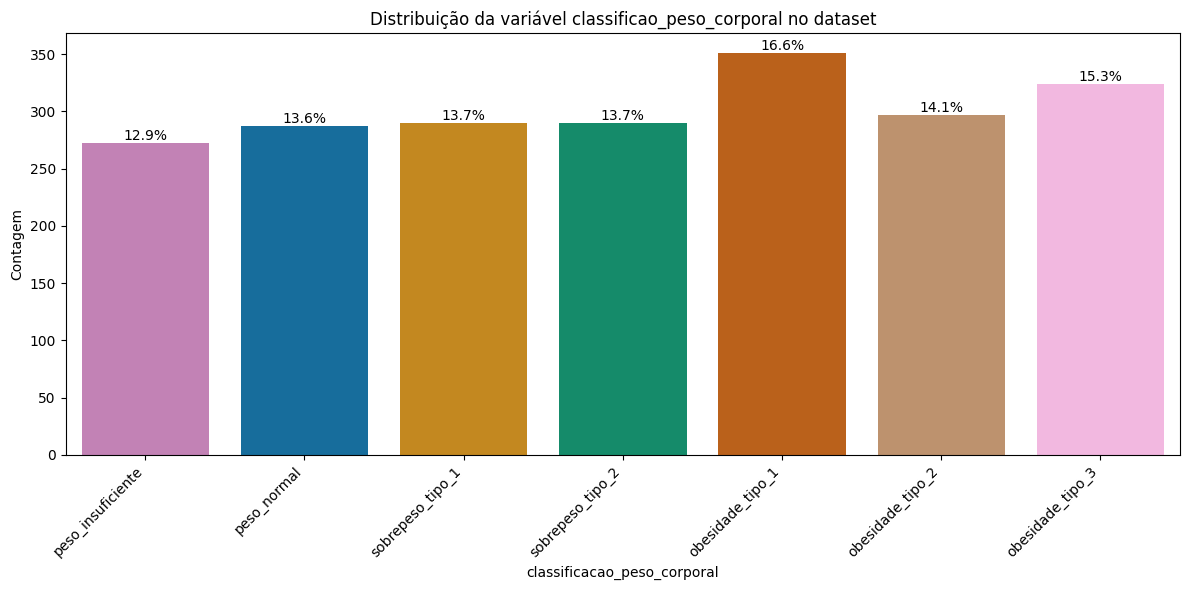

In [256]:
gera_grafico_barras(df, 'classificacao_peso_corporal', title = "Distribuição da variável classificao_peso_corporal no dataset", order = ordem_classificao_peso_corporal)

**Teste de Aderência utilizando Qui-Quadrado**

In [257]:
frequencias_observadas_classificacao_peso = tab_freq_classificacao_peso_corporal['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_classificacao_peso, f_esperadas=None)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 14.3306
Valor-p (p-value): 0.0262
Como p (0.0262) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(14.330648981525345), np.float64(0.02615299868612885))

**Razão de desbalanceamento**

In [258]:
qtd_min_classificacao_peso_corporal = tab_freq_classificacao_peso_corporal['porcentagem'].min()
qtd_max_classificacao_peso_corporal = tab_freq_classificacao_peso_corporal['porcentagem'].max()
razao_balancemento_classificacao_peso_corporal = calcular_razao_desbalanceamento(quantidade_maxima = qtd_max_classificacao_peso_corporal, quantidade_minima = qtd_min_classificacao_peso_corporal)



--- Razão de Desbalanceamento (IR) ---
Quantidade da classe majoritária: 16.63
Quantidade da classe minoritária: 12.88
Razão de Desbalanceamento (IR): 1.29

--- Interpretação da Razão de Desbalanceamento ---
🟢 Balanceado. Não faça nada.


## **Análise variáveis categóricas nominais**

`genero`, `historico_familiar`, `favc`,  `fumante`, `scc`, `mtrans`

**Técnicas utilizadas:**

**Analise univarida:**

- Tabela de frequência
- Gráfico de barras
- Teste de aderência (univariado) utilizando qui-quadrado

**Análise bi-variada:**

- Tabela cruzada
- Gráfico de barras emoilhado
- Teste de Independência (Bivariado) utilizando qui-quadrado

### **Análise variável `genero`**

In [259]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['genero']['novo_nome']}: {dicionario_dados_nivel_obesidade['genero']['descricao']}")

Descrição da variavel genero: Genero


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente balanceada em relação aos grupos que compõe a variável gênero.

A análise bi-variada apresenta um gráfico empilhado onde as barras de feminino e masculino da variável gênero estão distribuídas de forma diferente o que mostra um poder preditivo em relação a variável alvo. Isto é confirmado pelo retorno de estatisticamente relevante a associação entre as variáveis do teste qui-quadrado.

Essa feature é candidata para ser utilizada no modelo preditivo.

**Sugestão para a feature `genero`:**

- Realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando a técnica de `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [260]:
tab_freq_classificacao_genero = criar_dataframe_frequencia(df = df, coluna = 'genero')
display(tab_freq_classificacao_genero)

,categoria,quantidade,porcentagem
0,Male,1068,50.59
1,Female,1043,49.41


**Gráfico de barras**

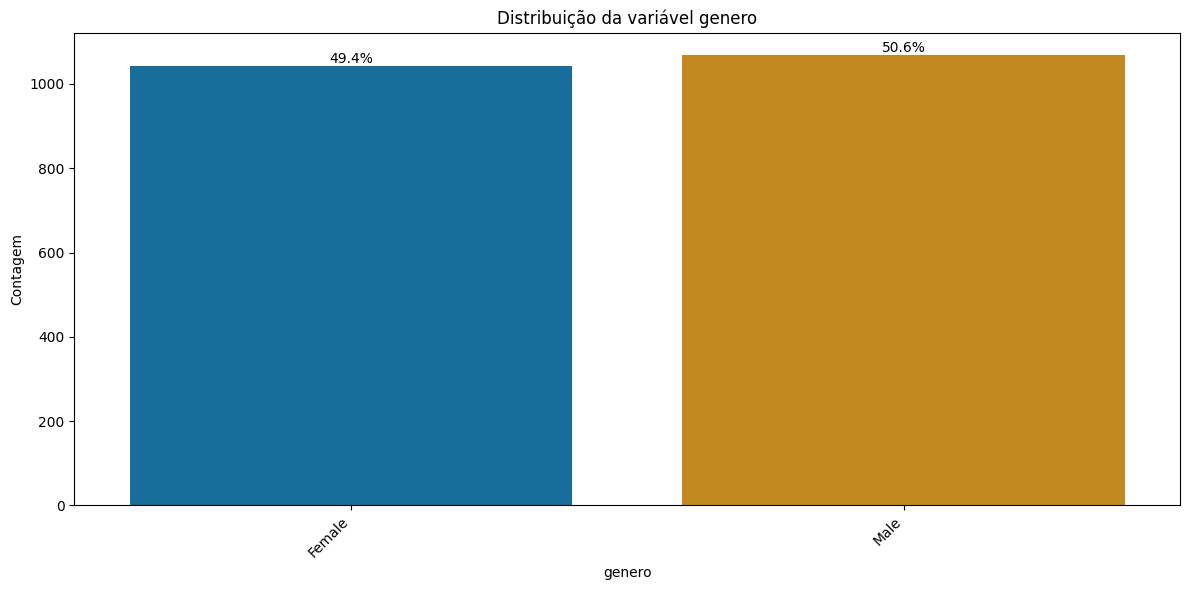

In [261]:
gera_grafico_barras(df = df , x_col = 'genero', title = "Distribuição da variável genero")

***Teste de aderência (univariado)***

In [262]:
frequencias_observadas_genero = tab_freq_classificacao_genero['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_genero)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 0.2961
Valor-p (p-value): 0.5864
Como p (0.5864) > 0.05, não podemos rejeitar a Hipótese Nula (H0).
Conclusão: A distribuição PODE ser considerada estatisticamente balanceada.


(np.float64(0.29606821411653245), np.float64(0.5863578616481406))

**Análise Bi-variada**

`genero` vs `classificacao_peso_alvo`

--- Análise da Feature: 'genero' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 657.7462
P-valor (p-value): 8.089e-139
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
genero,,,,,,,
Female,16.59,13.52,13.90,9.88,14.96,0.19,30.97
Male,9.27,13.67,13.58,17.51,18.26,27.62,0.09


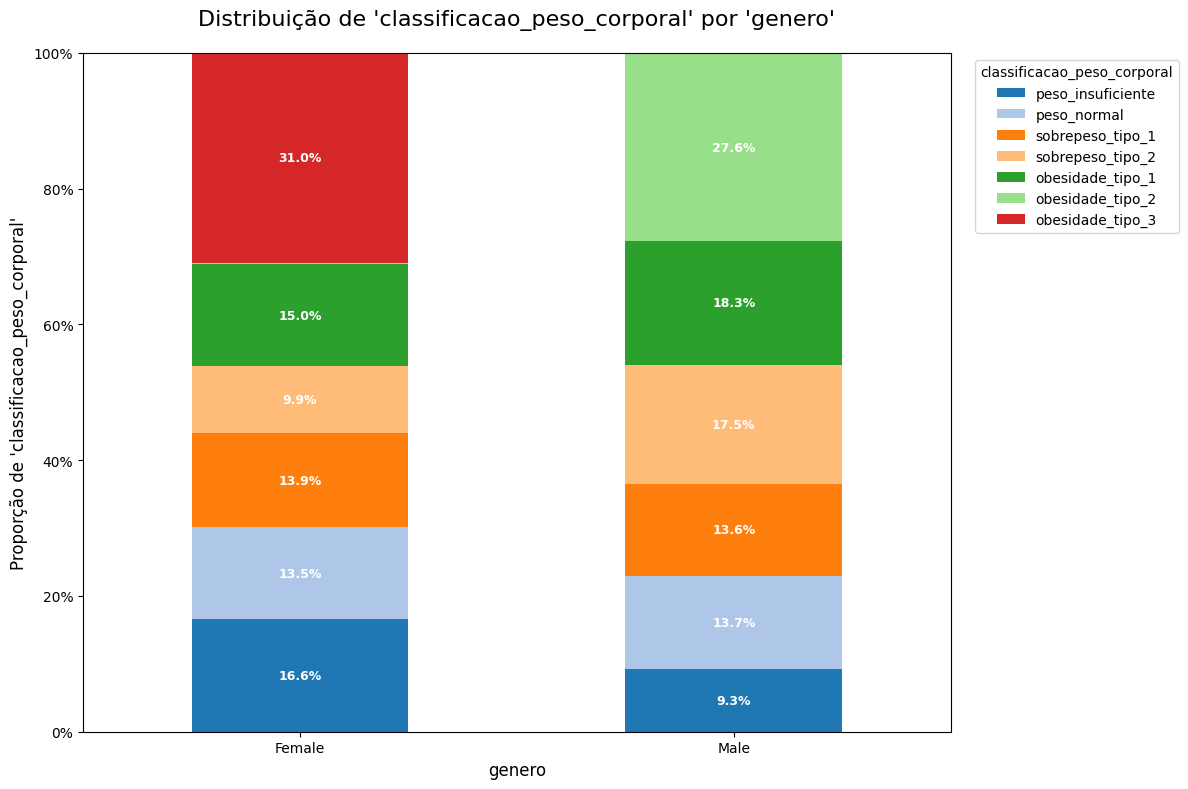

In [263]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'genero',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `historico_familiar`**

In [264]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['historico_familiar']['novo_nome']}: {dicionario_dados_nivel_obesidade['historico_familiar']['descricao']}")

Descrição da variavel historico_familiar: Algum membro da familia sofreu ou sofre de excesso de peso?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável historico_familiar. No entanto, ainda temos uma amostra grande o suficiente do grupo minotário para alimentar o modelo de machine learning.

A análise bi-variada apresenta um gráfico empilhado onde as barras de sim e  não da variável historico_familiar estão distribuídas de forma diferente o que mostra um poder preditivo em relação a variável alvo. Isto é confirmado pelo retorno de estatisticamente relevante a associação entre as variáveis do teste qui-quadrado.

Essa feature é uma candidata para ser utilizada no modelo preditivo.

**Sugestão para a feature `historico_familiar`:**

- Realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando a técnica de `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [265]:
tab_freq_classificacao_historico_familiar = criar_dataframe_frequencia(df = df, coluna = 'historico_familiar')
display(tab_freq_classificacao_historico_familiar)

,categoria,quantidade,porcentagem
0,yes,1726,81.76
1,no,385,18.24


**Gráfico de barras**

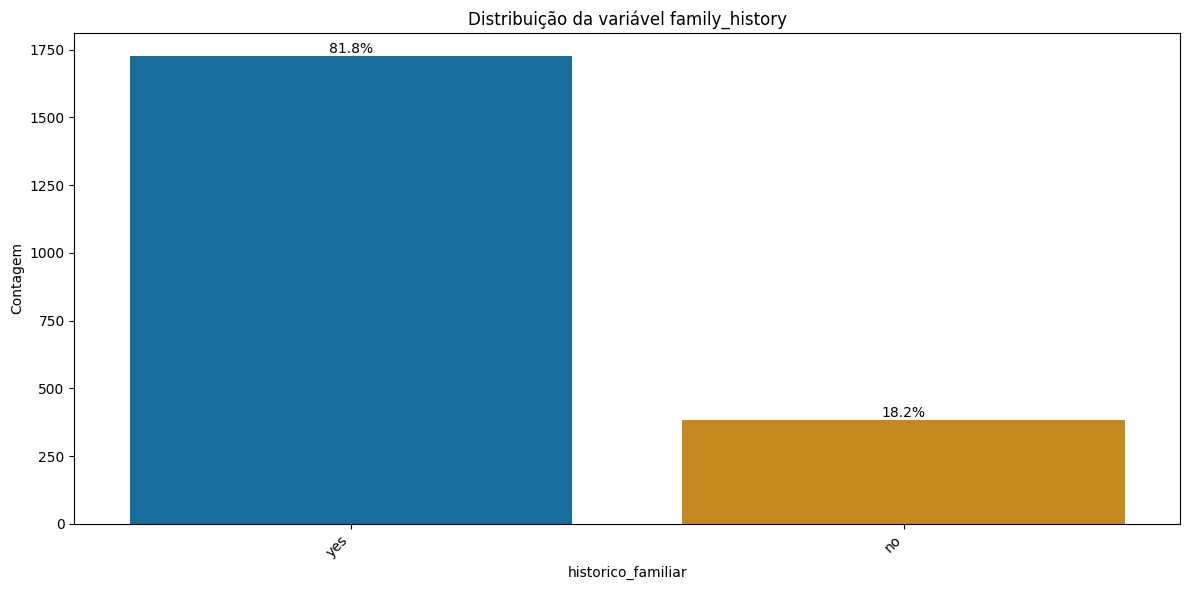

In [266]:
gera_grafico_barras(df = df , x_col = 'historico_familiar', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['historico_familiar']['nome_original']}")

***Teste de aderência (univariado)***

In [267]:
frequencias_observadas_historico_familiar = tab_freq_classificacao_historico_familiar['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_historico_familiar)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 851.8622
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(851.8621506395074), np.float64(2.862407015229573e-187))

**Análise Bi-variada**

`frequencias_observadas_historico_familiar` vs `classificacao_peso_alvo`

--- Análise da Feature: 'historico_familiar' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 621.9794
P-valor (p-value): 4.228e-131
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
historico_familiar,,,,,,,
no,37.92,34.29,21.04,4.68,1.82,0.26,0.00
yes,7.30,8.98,12.11,15.76,19.93,17.15,18.77


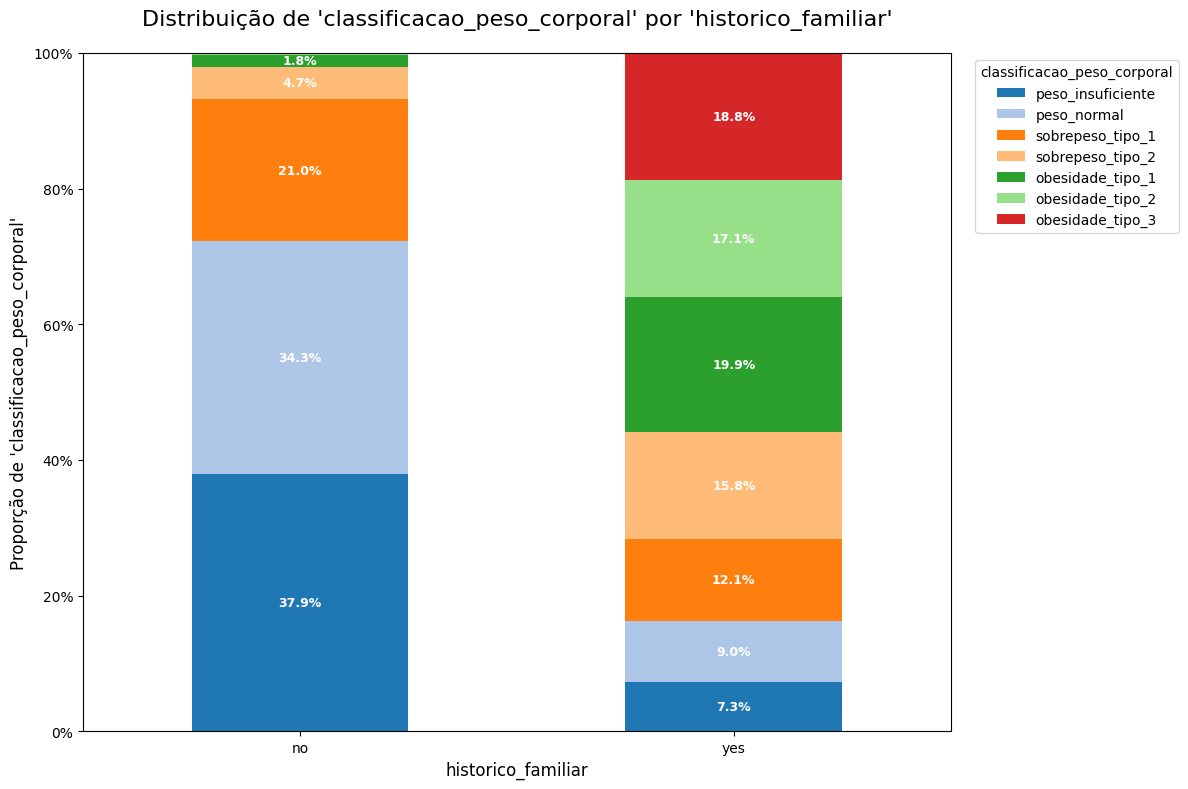

In [268]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'historico_familiar',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `favc`**

In [269]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['favc']['nome_original']}: {dicionario_dados_nivel_obesidade['favc']['descricao']}")

Descrição da variavel FAVC: Voce come alimentos altamente caloricos com frequencia?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável favc. No entanto, ainda temos uma amostra grande o suficiente do grupo minotário para alimentar o modelo de machine learning.

A análise bi-variada apresenta um gráfico empilhado onde as barras de sim e  não da variável favc estão distribuídas de forma diferente o que mostra um poder preditivo em relação a variável alvo. Isto é confirmado pelo retorno de estatisticamente relevante a associação entre as variáveis do teste qui-quadrado.

Essa feature é uma candidata para ser utilizada no modelo preditivo.

**Sugestão para a feature `favc`:**

- Realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando uma técnica de `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [270]:
tab_freq_classificacao_favc = criar_dataframe_frequencia(df = df, coluna = 'favc')
display(tab_freq_classificacao_favc)

,categoria,quantidade,porcentagem
0,yes,1866,88.39
1,no,245,11.61


**Gráfico de barras**

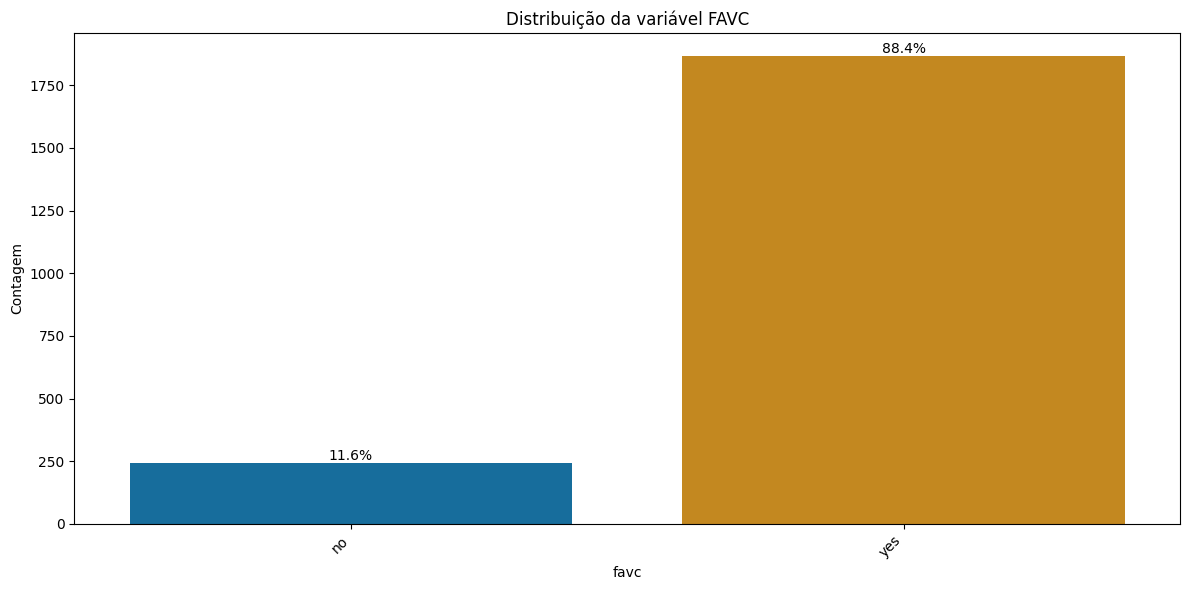

In [271]:
gera_grafico_barras(df = df , x_col = 'favc', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['favc']['nome_original']}")

***Teste de aderência (univariado)***

In [272]:
frequencias_observadas_favc = tab_freq_classificacao_favc['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_favc)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 1244.7376
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(1244.7375651350071), np.float64(1.1553803549669082e-272))

**Análise Bi-variada**

`favc` vs `classificacao_peso_alvo`

--- Análise da Feature: 'favc' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 233.3413
P-valor (p-value): 1.482e-47
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
favc,,,,,,,
no,20.82,32.24,8.98,30.20,4.49,2.86,0.41
yes,11.84,11.15,14.36,11.58,18.22,15.54,17.31


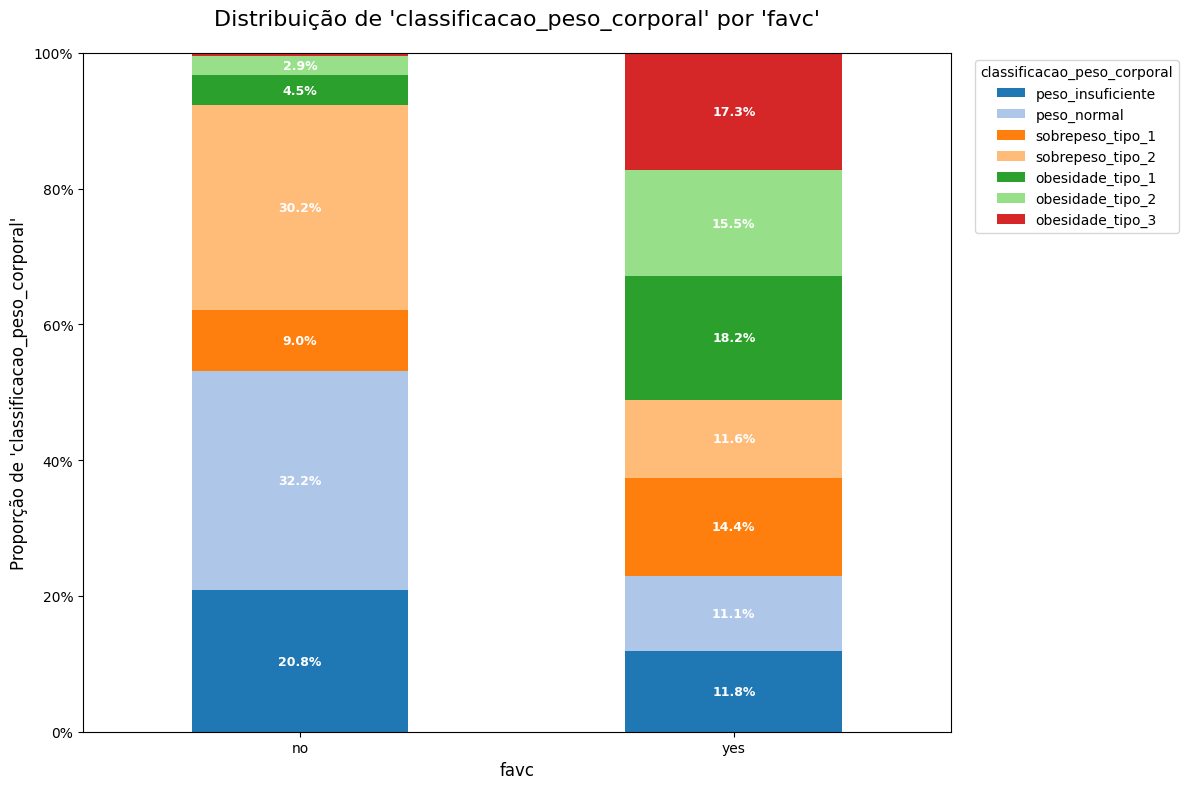

In [273]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'favc',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `fumante`**

In [274]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['fumante']['novo_nome']}: {dicionario_dados_nivel_obesidade['fumante']['descricao']}")

Descrição da variavel fumante: Voce fuma?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável fumante e temos uma amostra pequena do grupo sim.

Devido a esse motivo, apesar da análise bi-variada uma associação estatisticamente relevante no teste qui-quadrado, a recomendação é de não usar essa feature no modelo preditivo pois o risco de overfiting é maior que o possível ganho.


**Sugestão para a feature `fumante`:**

- Excluir a feature do modelo preditivo.

- Caso optem por utilizar a feature é necessário realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando uma técnica de `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [275]:
tab_freq_classificacao_fumante = criar_dataframe_frequencia(df = df, coluna = 'fumante')
display(tab_freq_classificacao_fumante)

,categoria,quantidade,porcentagem
0,no,2067,97.92
1,yes,44,2.08


**Gráfico de barras**

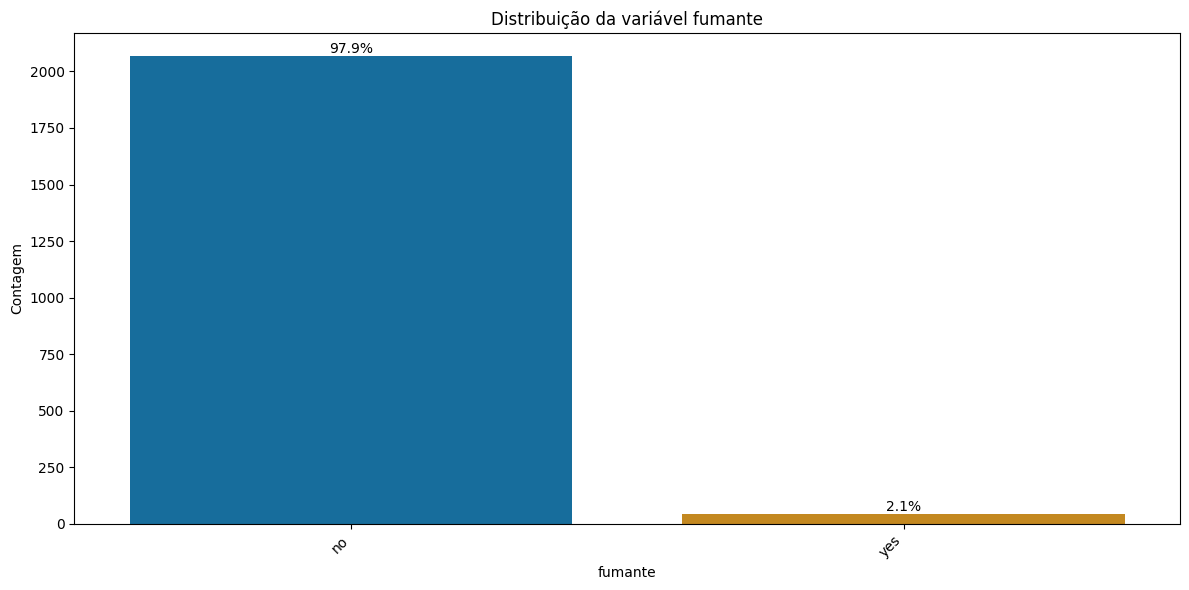

In [276]:
gera_grafico_barras(df = df , x_col = 'fumante', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['fumante']['novo_nome']}")

***Teste de aderência (univariado)***

In [277]:
frequencias_observadas_fumante = tab_freq_classificacao_fumante['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_fumante)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 1938.6684
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(1938.6684036001895), np.float64(0.0))

**Análise Bi-variada**

`favc` vs `classificacao_peso_alvo`

--- Análise da Feature: 'fumante' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 32.1378
P-valor (p-value): 1.535e-05
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
fumante,,,,,,,
no,13.11,13.26,13.88,13.79,16.69,13.64,15.63
yes,2.27,29.55,6.82,11.36,13.64,34.09,2.27


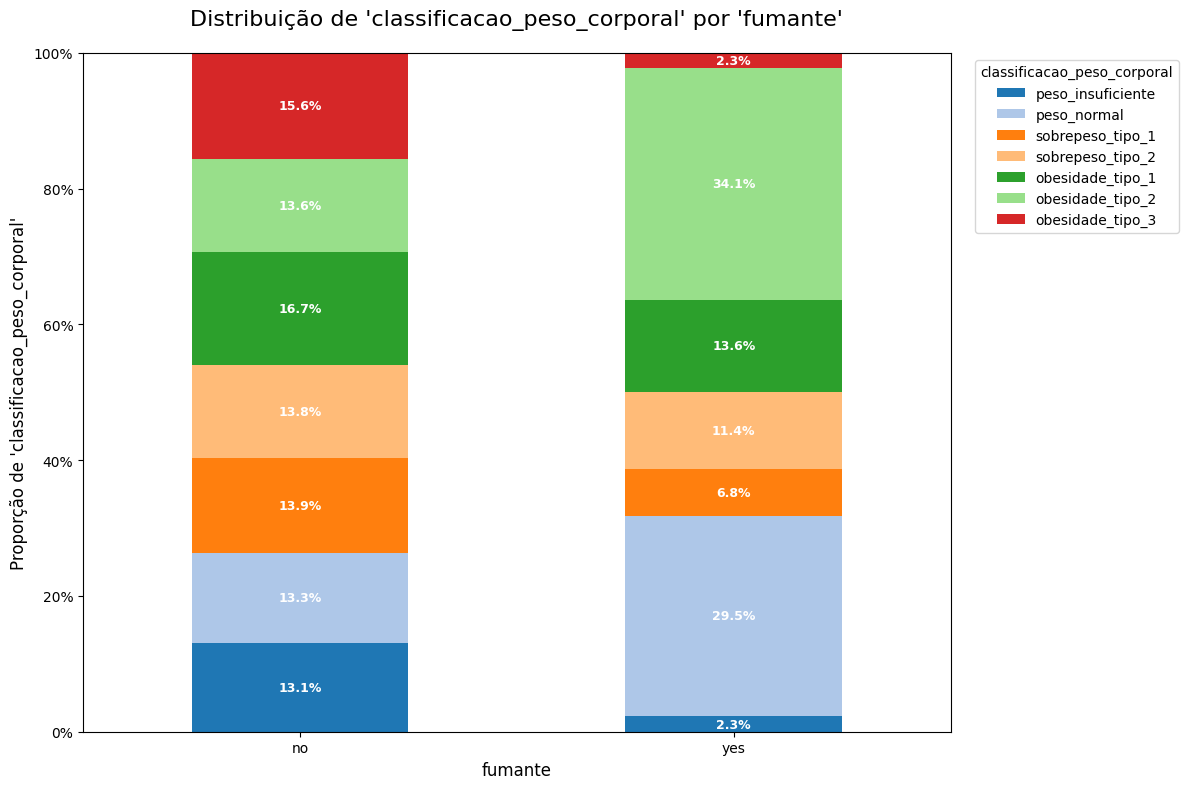

In [278]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'fumante',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `scc`**

In [279]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['scc']['nome_original']}: {dicionario_dados_nivel_obesidade['scc']['descricao']}")

Descrição da variavel SCC: Voce monitora as calorias que ingere diariamente?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável fumante e temos uma amostra pequena do grupo sim. O volume de amostras está em uma zona de atenção devido ao risco de overfitting. No entanto a associação preditiva é significativamente relevante.


**Sugestão para a feature `scc`:**

- Manter a feature para o treinamento do modelo preditivo.

- Após o treinamento Verificar a importância da feature. Se a importância dela for pequena para o modelo,  retirar a feature do treinamento do modelo é uma boa opção.

- Realizar a validação cruzada para ter certeza  se devemos continuar ou não com a feature.

- Caso optem por utilizar a feature é necessário realizar a transformação dos valores que atualmente são do tipo objeto, em inteiro utilizando `label_encoding`.

**Análise univariada**

**Tabela de Frequência**

In [280]:
tab_freq_classificacao_scc = criar_dataframe_frequencia(df = df, coluna = 'scc')
display(tab_freq_classificacao_scc)

,categoria,quantidade,porcentagem
0,no,2015,95.45
1,yes,96,4.55


**Gráfico de barras**

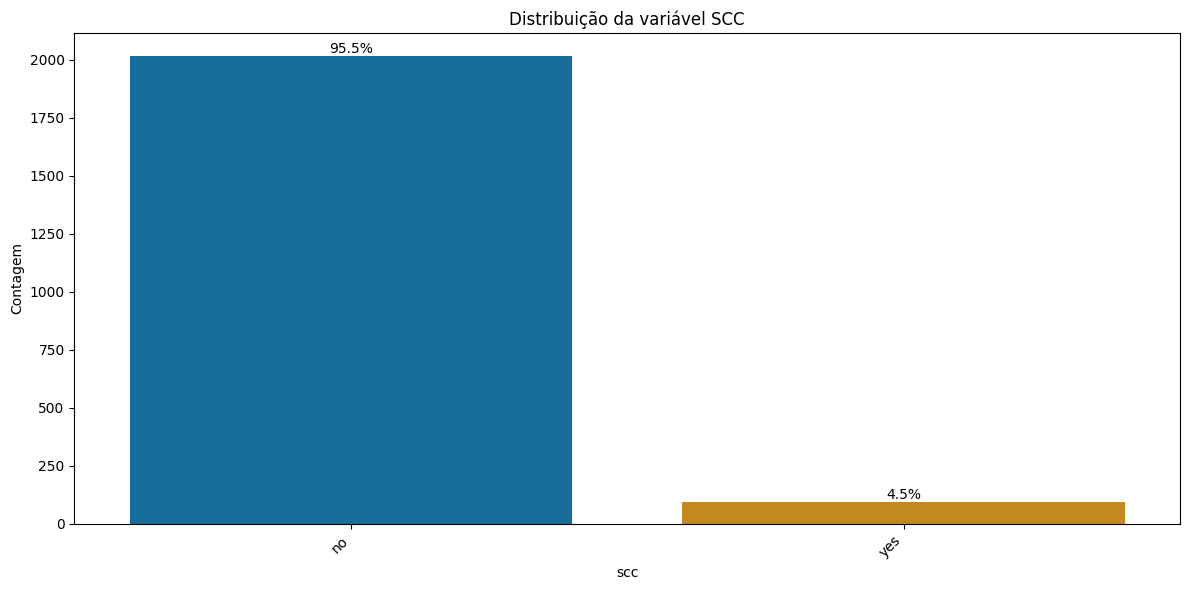

In [281]:
gera_grafico_barras(df = df , x_col = 'scc', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['scc']['nome_original']}")

***Teste de aderência (univariado)***

In [282]:
frequencias_observadas_scc = tab_freq_classificacao_scc['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_scc)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 1744.4628
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(1744.462813832307), np.float64(0.0))

**Análise Bi-variada**

`scc` vs `classificacao_peso_alvo`

--- Análise da Feature: 'scc' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 123.0239
P-valor (p-value): 3.773e-24
Graus de Liberdade (dof): 6


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
scc,,,,,,,
no,12.41,12.75,12.56,14.19,17.32,14.69,16.08
yes,22.92,31.25,38.54,4.17,2.08,1.04,0.00


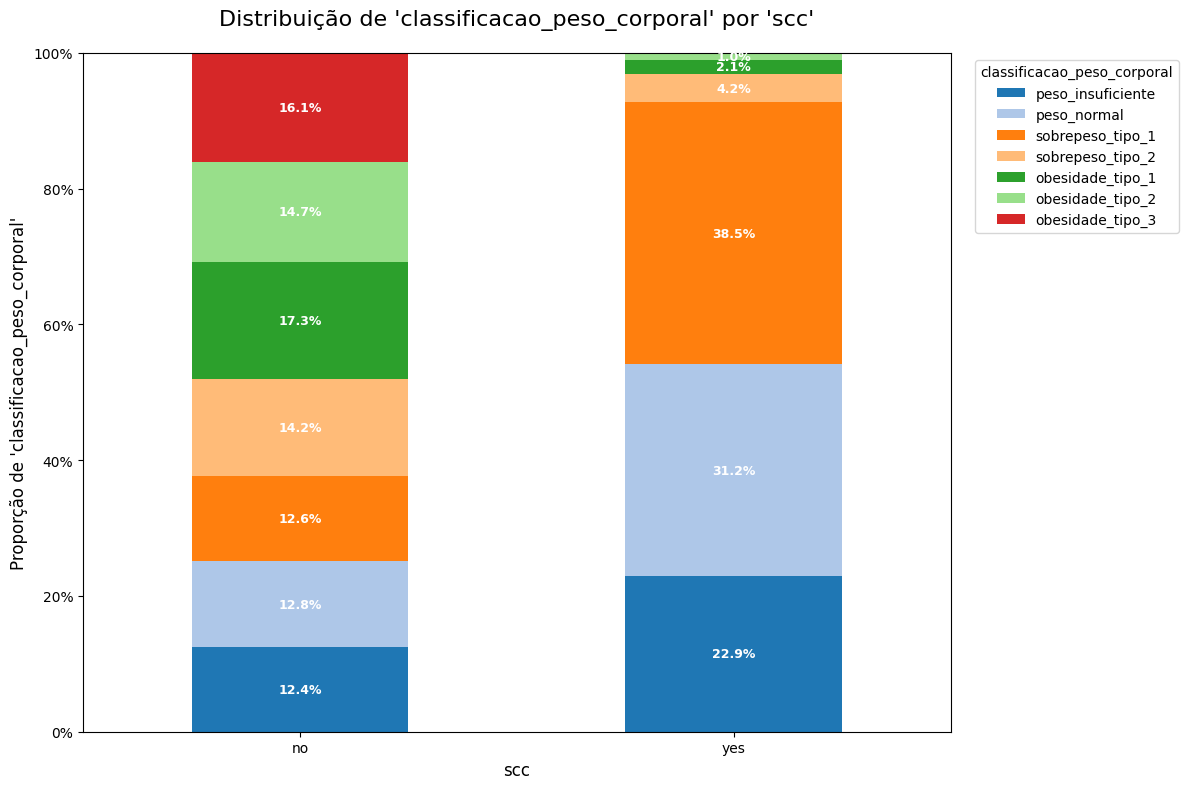

In [283]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'scc',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `mtrans`**

In [284]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['mtrans']['nome_original']}: {dicionario_dados_nivel_obesidade['mtrans']['descricao']}")

Descrição da variavel MTRANS: Qual meio de transporte voce costuma usar?


**Conclusão:**

A análise univariada mostrou que a amostra é estatisticamente desbalanceada em relação aos grupos que compõe a variável mtrans. No entanto as amostras de `transporte_publico` (1580), `carro` (457) possuem uma boa quantidade de registros para realizar o treinamento do modelo. A quantidade de valores de `bicicleta` (7),  `moto`(11) estão em uma zonas de descarte devido a baixa volumetria, enquanto `caminhando` (56) está em uma zona de cuidado.

A análise bivariada mostrou uma associação estatisticamente relevante entre as categorias e a variável alvo. As categorias raras `bicicleta` (7),  `moto`(11) e  `andando` (56) possuem um padrão parecido com acumulo de registros relacionados a `peso_normal`e `baixa obesidade`. Dessa forma é possível agrupá-las em uma única categoria para treinamento, deixando elas ainda na zona de atenção devido a quantidade de 74 casos, mas com a possibilidade de utilização devido ao potencial preditivo.


**Sugestão para a feature `mtrans`:**

- Transformar as categorias `bicicleta`,  `moto` e  `caminhando` em uma única categoria .

- Utilizar a técnica `one_hot_encoding` transformando em 2 categorias para evitar a armadilha das Variáveis Dummy.

- Após o treinamento Verificar a importância da feature. Se a importância dela for pequena para o modelo, retirar a feature do treinamento do modelo é uma boa opção.

- Realizar a validação cruzada para ter certeza  se devemos continuar ou não com a feature.



**Análise univariada**

**Tabela de Frequência**

In [285]:
tab_freq_classificacao_mtrans = criar_dataframe_frequencia(df = df, coluna = 'mtrans')
display(tab_freq_classificacao_mtrans)

,categoria,quantidade,porcentagem
0,transporte_publico,1580,74.85
1,carro,457,21.65
2,caminhando,56,2.65
3,moto,11,0.52
4,bicicleta,7,0.33


**Gráfico de barras**

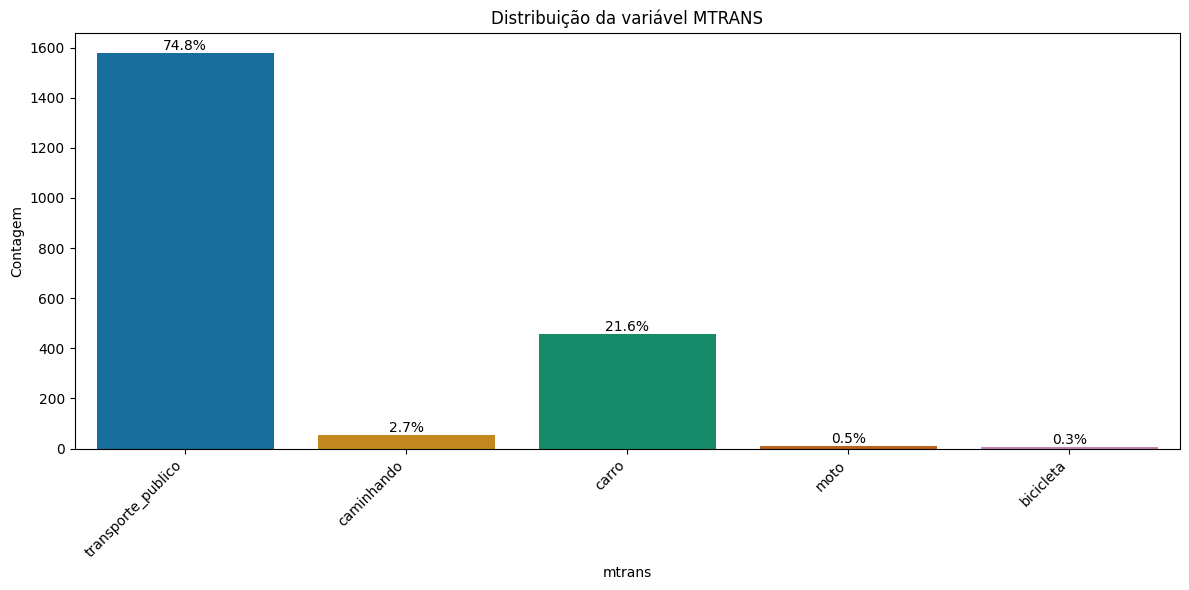

In [286]:
gera_grafico_barras(df = df , x_col = 'mtrans', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['mtrans']['nome_original']}")

***Teste de aderência (univariado)***

In [287]:
frequencias_observadas_mtrans = tab_freq_classificacao_mtrans['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_mtrans)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 4304.3363
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(4304.3363334912365), np.float64(0.0))

**Análise Bi-variada**

`mtrans` vs `classificacao_peso_alvo`

--- Análise da Feature: 'mtrans' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 292.5939
P-valor (p-value): 5.178e-48
Graus de Liberdade (dof): 24


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
mtrans,,,,,,,
bicicleta,0.00,57.14,28.57,0.00,0.00,14.29,0.00
caminhando,10.71,57.14,16.07,10.71,3.57,1.79,0.00
carro,10.07,9.85,14.44,20.57,24.07,20.79,0.22
moto,0.00,54.55,9.09,9.09,27.27,0.00,0.00
transporte_publico,13.92,12.66,13.42,11.96,14.94,12.66,20.44


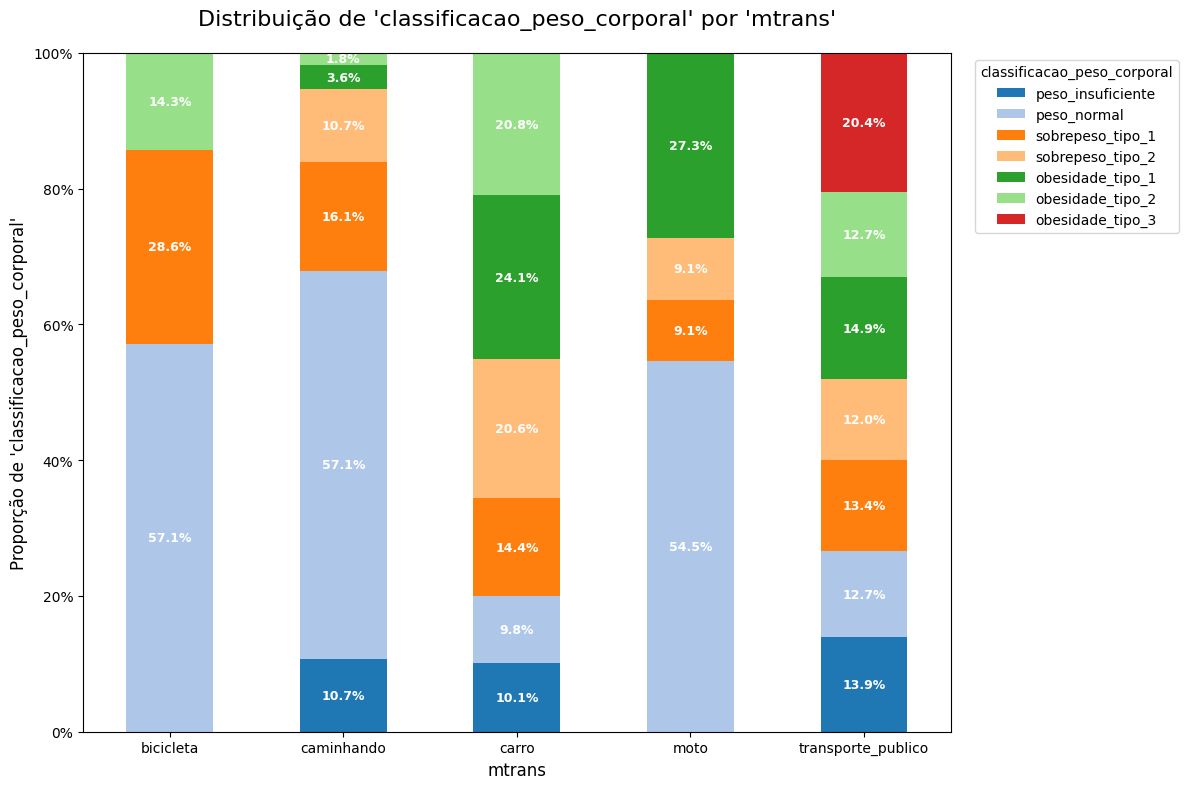

In [288]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'mtrans',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_colunas = ordem_classificao_peso_corporal
)

## **Análise variáveis categóricas ordinais**

**Variáveis categóricas ordinais:**

`caec`, `calc`

**Técnicas utilizadas:**

**Analise univarida:**

- Tabela de frequência
- Gráfico de barras
- Teste de aderência (univariado) utilizando qui-quadrado

**Análise bi-variada:**

- Tabela cruzada
- Gráfico de barras emoilhado
- Teste de Independência (Bivariado) utilizando qui-quadrado

### **Análise variável `caec`**

In [289]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['caec']['novo_nome']}: {dicionario_dados_nivel_obesidade['caec']['descricao']}")

Descrição da variavel caec: Voce come alguma coisa entre as refeicoes?


**Valores únicos da variável**

In [290]:
print(f'Os valores únicos da variável {dicionario_dados_nivel_obesidade["caec"]["novo_nome"]} são: {df.caec.unique()}')

Os valores únicos da variável caec são: ['as_vezes' 'frequentemente' 'sempre' 'nunca']


**Conclusão:**

A variável caec é uma amostra desbalanceada, com `nunca` e `sempre` no limite inferior entre a zona de perigo e descarte de uma variável. A analise bivariada sinalizou um associação estatisticamente significante. Diferente da coluna `mtrans` juntar categorias não é uma opção, pois elas possuem associações bem diferentes com a variavel alvo.

Neste caso devido ao poder preditivo sugiro manter a feature no treinamento utilizando a tecnica de ordinal_encoder, mas analisaria a relevancia da mesma no treinamento do modelo para verificar se devemos mante-la e assumir o risco de overfitting.


**Sugestão para a feature `caec`:**

- Utilizar a técnica `OrdinalEncoder`.

- Verificar a importância da feature.

- Teste A/B comparando os scores na validação cruzada

- Caso a importância da feature  e o teste A/B voltem sem relevância ou indicando overfitting retirar a mesma do treinamento.



**Análise univariada**

**Tabela de Frequência**

In [291]:
tab_freq_classificacao_caec = criar_dataframe_frequencia(df = df, coluna = 'caec', ordem_categorias = ordem_frequencia)
display(tab_freq_classificacao_caec)

,categoria,quantidade,porcentagem
0,nunca,51,2.42
1,as_vezes,1765,83.61
2,frequentemente,242,11.46
3,sempre,53,2.51


**Gráfico de barras**

In [292]:
ordem_frequencia

['nunca', 'as_vezes', 'frequentemente', 'sempre']

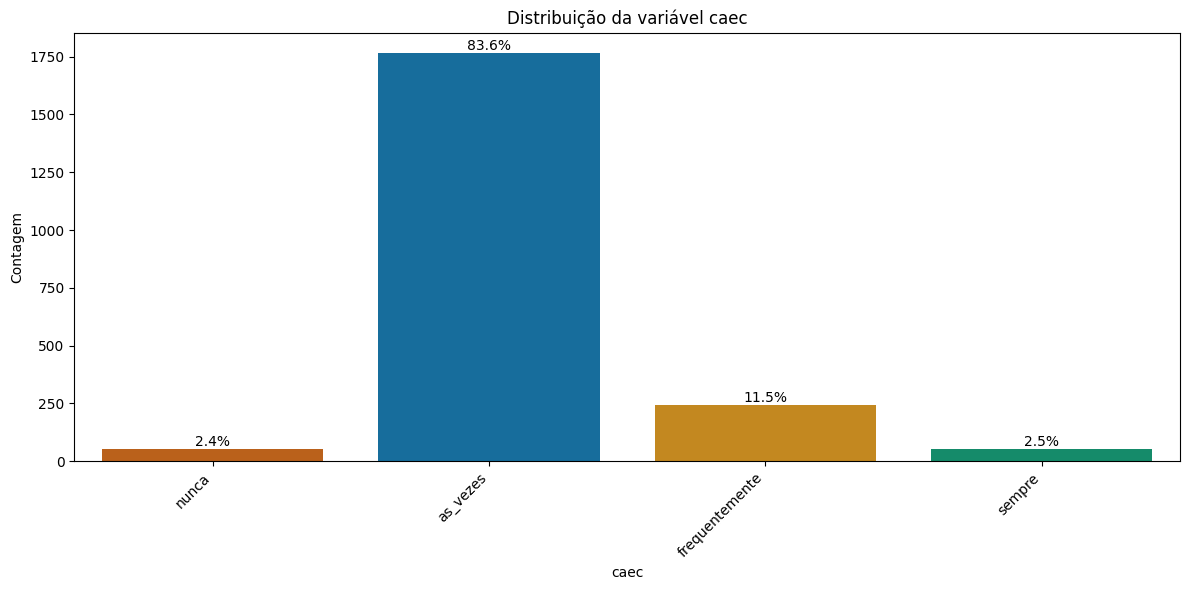

In [293]:
gera_grafico_barras(df = df , x_col = 'caec', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['caec']['novo_nome']}", order = ordem_frequencia)

***Teste de aderência (univariado)***

In [294]:
frequencias_observadas_caec = tab_freq_classificacao_caec['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_caec)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 3913.0625
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(3913.0625296068215), np.float64(0.0))

**Análise Bi-variada**

`caec` vs `classificacao_peso_alvo`

--- Análise da Feature: 'caec' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 802.9773
P-valor (p-value): 7.384e-159
Graus de Liberdade (dof): 18


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de linhas (eixo X) aplicada: ['nunca', 'as_vezes', 'frequentemente', 'sempre']
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
caec,,,,,,,
nunca,5.88,19.61,68.63,1.96,1.96,1.96,0.00
as_vezes,8.27,9.01,13.37,15.30,19.15,16.60,18.30
frequentemente,50.00,34.30,5.79,6.61,2.48,0.41,0.41
sempre,3.77,66.04,9.43,5.66,11.32,3.77,0.00


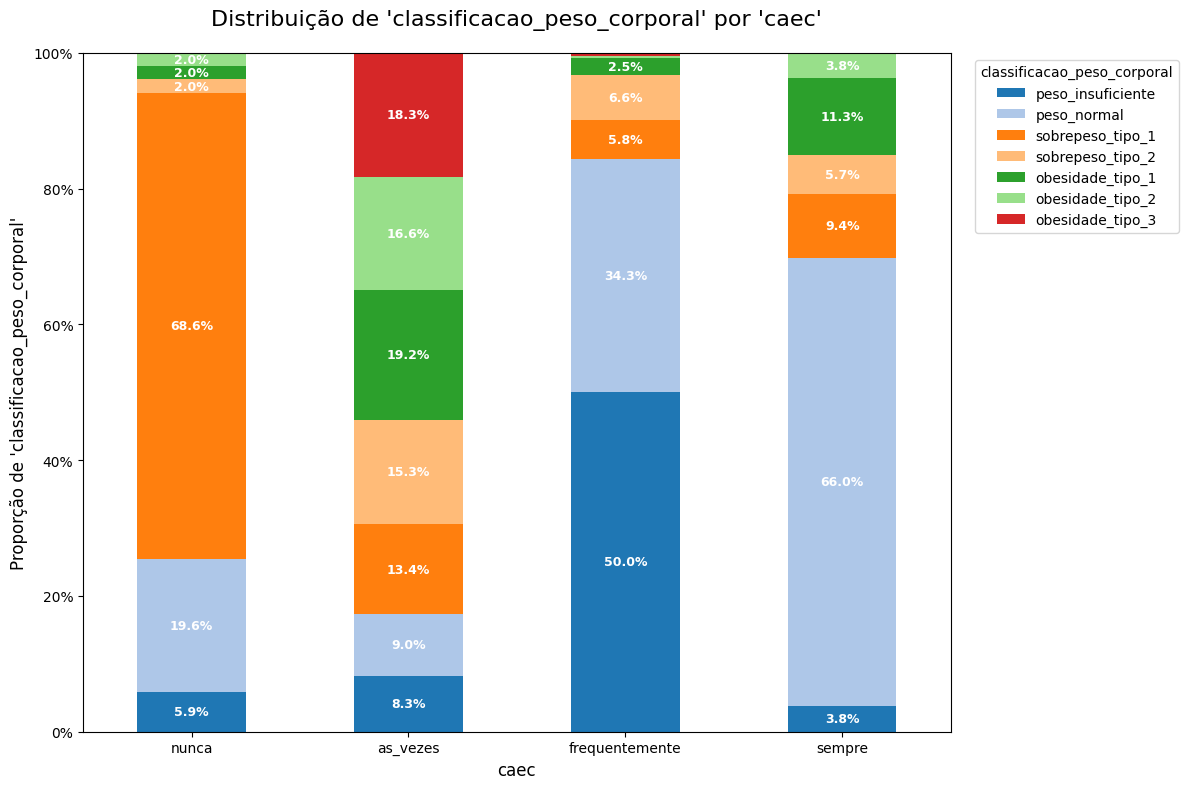

In [295]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'caec',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_linhas = ordem_frequencia,
    ordem_colunas = ordem_classificao_peso_corporal
)

### **Análise variável `caec`**

In [296]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['calc']['novo_nome']}: {dicionario_dados_nivel_obesidade['calc']['descricao']}")

Descrição da variavel calc: Com que frequencia voce bebe alcool?


**Valores únicos da variável**

In [297]:
print(f'Os valores únicos da variável {dicionario_dados_nivel_obesidade["calc"]["novo_nome"]} são: {df.calc.unique()}')

Os valores únicos da variável calc são: ['nunca' 'as_vezes' 'frequentemente' 'sempre']


**Conclusão:**

A variável calc é estatisticamente desbalanceada e possui a categoria ´sempre´ com apenas 1 registro, o que a torna rara e inviável para o treinamento.

A categoria ´frequentemente´ está na zona de perigo para ser utilizada no trenamento de aprendizado de máquina, com 70 registros.

A análise Bi-variada mostra que existe poder preditivo entre as categorias e a variavel alvo. A categoria ´frequentemente´, em ordem de grandeza, é mais proxima da categoria ´sempre, por esse motivo ´sugiro juntá-las. Outra opção seria excluir o registro.

Em qualquer um dos casos é interessante verifcar após o treinamento a relevancia da feature e da avaliacao do teste A/B




**Sugestão para a feature `caec`:**

- Manter a variável juntando as categorias frequentemente e sempre.

- Utilizar a técnica `OrdinalEncoder`.

- Verificar a importância da feature.

- Teste A/B comparando os scores na validação cruzada

- Caso a importância da feature  e o teste A/B voltem sem relevância, ou indicando overfitting, retirar a mesma do treinamento.



**Análise univariada**

**Tabela de Frequência**

In [298]:
tab_freq_classificacao_calc = criar_dataframe_frequencia(df = df, coluna = 'calc', ordem_categorias = ordem_frequencia)
display(tab_freq_classificacao_calc)

,categoria,quantidade,porcentagem
0,nunca,639,30.27
1,as_vezes,1401,66.37
2,frequentemente,70,3.32
3,sempre,1,0.05


**Gráfico de barras**

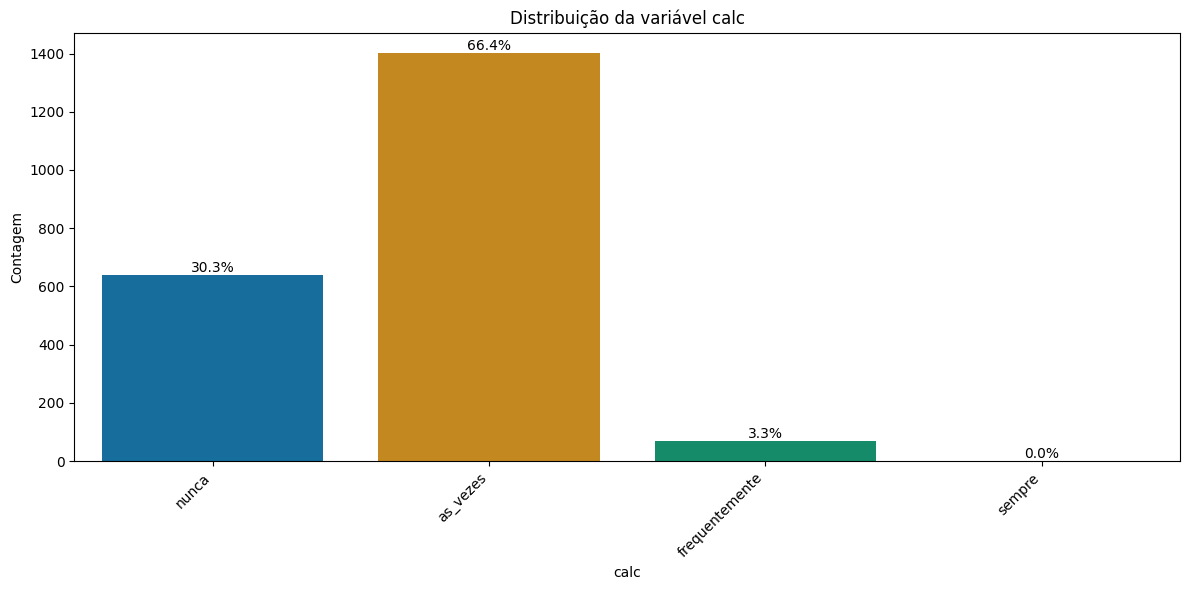

In [299]:
gera_grafico_barras(df = df , x_col = 'calc', title = f"Distribuição da variável {dicionario_dados_nivel_obesidade['calc']['novo_nome']}", order = ordem_frequencia)

***Teste de aderência (univariado)***

In [300]:
frequencias_observadas_calc = tab_freq_classificacao_calc['quantidade']
realizar_teste_qui_quadrado(frequencias_observadas_calc)


--- Interpretação ---
Estatística Qui-Quadrado (χ²): 2391.1753
Valor-p (p-value): 0.0000
Como p (0.0000) <= 0.05, rejeitamos a Hipótese Nula (H0).
Conclusão: A distribuição NÃO é estatisticamente balanceada.


(np.float64(2391.175272382757), np.float64(0.0))

**Análise Bi-variada**

`calc` vs `classificacao_peso_alvo`

--- Análise da Feature: 'calc' vs. Alvo: 'classificacao_peso_corporal' ---


--- 1. Resultados do Teste Qui-Quadrado ---
Estatística Qui-Quadrado (χ²): 338.5775
P-valor (p-value): 5.287e-61
Graus de Liberdade (dof): 18


Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma associação ESTATISTICAMENTE SIGNIFICATIVA entre as variáveis.


--- 2. Visualização (Gráfico de Barras Empilhado 100%) ---
Ordenação de linhas (eixo X) aplicada: ['nunca', 'as_vezes', 'frequentemente', 'sempre']
Ordenação de colunas (legenda) aplicada: ['peso_insuficiente', 'peso_normal', 'sobrepeso_tipo_1', 'sobrepeso_tipo_2', 'obesidade_tipo_1', 'obesidade_tipo_2', 'obesidade_tipo_3']




classificacao_peso_corporal,peso_insuficiente,peso_normal,sobrepeso_tipo_1,sobrepeso_tipo_2,obesidade_tipo_1,obesidade_tipo_2,obesidade_tipo_3
calc,,,,,,,
nunca,18.31,16.74,7.82,20.03,25.82,11.11,0.16
as_vezes,10.99,11.49,15.99,10.21,12.28,15.99,23.05
frequentemente,1.43,25.71,22.86,27.14,20.00,2.86,0.00
sempre,0.00,100.00,0.00,0.00,0.00,0.00,0.00


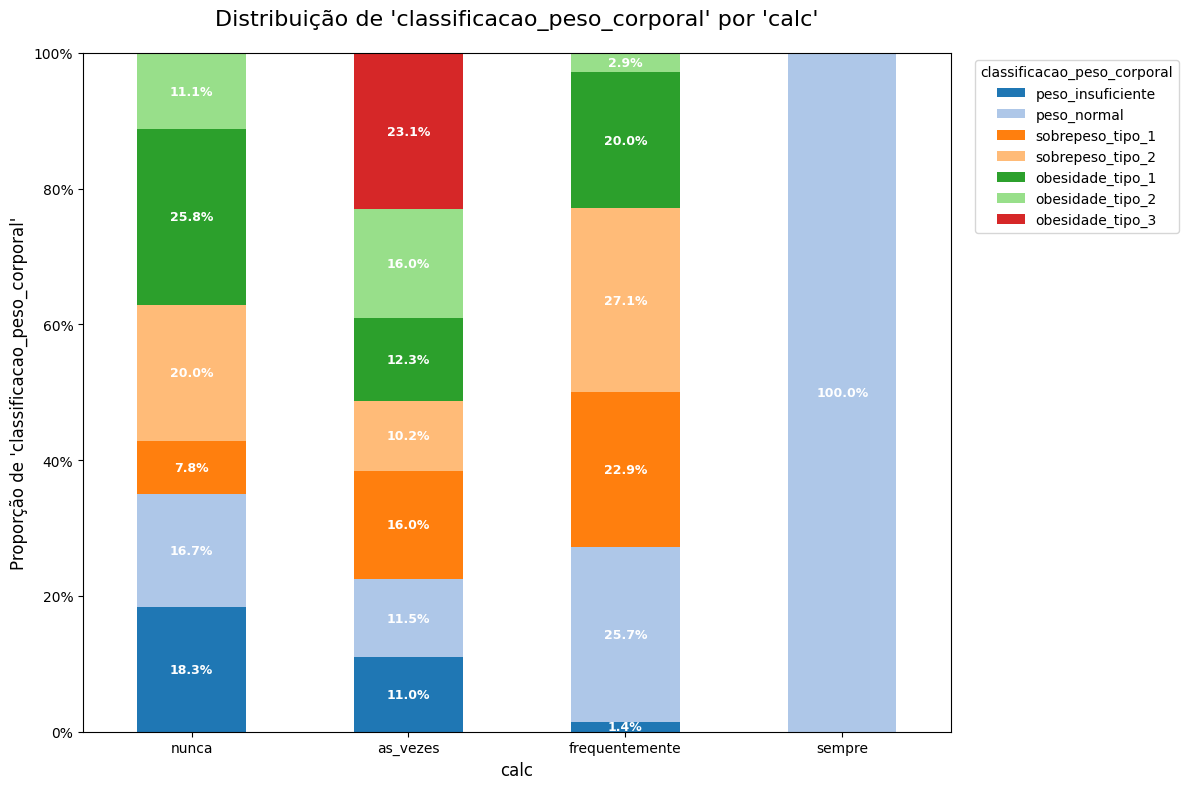

In [301]:
analisar_variavel_categorica_bi_variada(
    df= df,
    coluna_feature = 'calc',
    coluna_alvo= 'classificacao_peso_corporal',
    ordem_linhas = ordem_frequencia,
    ordem_colunas = ordem_classificao_peso_corporal
)

## **Análise variáveis numéricas**

**Veriáveis numéricas**

`idade`, `altura`, `peso`, `fcvc`, `ncp`, `ch20`, `faf`, `tue`

**Técnicas utilizadas**

**Análise Univariada**

- Estatística descritiva

- Histograma

- Boxplot

**Análise Bivariada**

- Boxplot agrupado

- Teste estatístico de análise de variância (ANOVA)

- Hipótese Nula(H0)

### **Análise variável `idade`**

In [302]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['idade']['novo_nome']}: {dicionario_dados_nivel_obesidade['idade']['descricao']}")

Descrição da variavel idade: Idade


**Conclusão**

Na analise univariada percebemos que a variável idade não possui erris erros, mas é fortemente assimétrica à direita, com uma concentração de pacientes jovens.

Na análise Bivariada temos diferença nas medianas de idade entreo os grupos da variável alvo e o teste estatístico confirma a diferença estatisticamente relevante da distribuição da variavel idade.


**Sugestões**

- Incluir a variável `idade` no treinamento do modelo

- Devido a assimetri a variável idade deve passar por Feature Scaling (como `StandardScaler` ou `MinMaxScaler`) para normalizar sua distribuição.

**Visualização prévia dos dados**

Esse dataset estava pronto quando recebemos para esse estudo. Analisando os dados da variável idade percebemos registros com 6 casas decimais, indicando que algum método estatístico foi utilzado na amostra. Seja para tratamento de dados ausentes ou  para uma geração de dados sintéticos.

Para o objetivo do estudo podemos continuar.

In [303]:
df.idade

,idade
0,21.000000
1,21.000000
2,23.000000
3,27.000000
4,22.000000
...,...
2106,20.976842
2107,21.982942
2108,22.524036
2109,24.361936


**Análise Univariada**

**Estatística descritiva**

**Análise:**

- Os valores mínimos e máximos da amostra estão dentro do esperado para uma mostra de idade populacional.

- A média é maior que a mediana indicando assimetria

In [304]:
df['idade'].describe()

,idade
count,2111.000000
mean,24.312600
std,6.345968
min,14.000000
25%,19.947192
50%,22.777890
75%,26.000000
max,61.000000


**Histograma**

O histograma revela uma distribuição assimétrica para a direita, confirmando a análise da estatística básica.

Temos uma maior concentração de pacientes jovens.

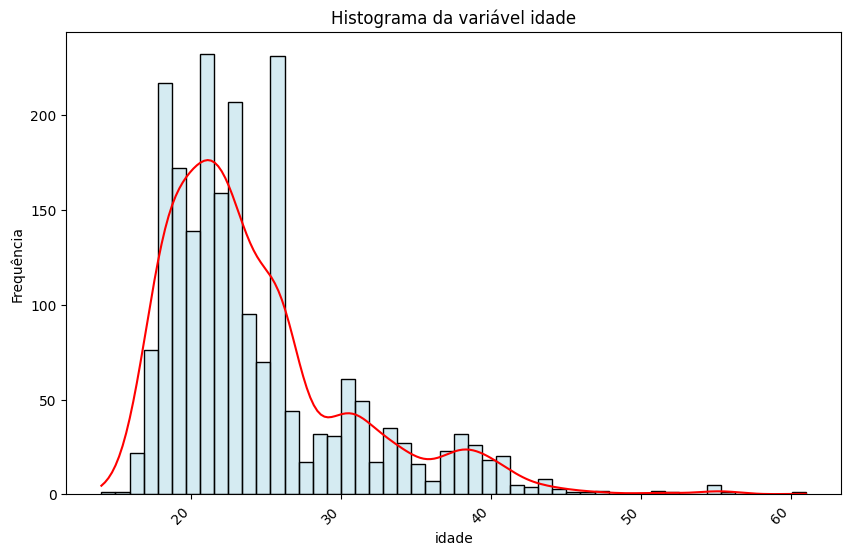

In [305]:
gera_histograma(df = df,  coluna = "idade", titulo = f"Histograma da variável {dicionario_dados_nivel_obesidade['idade']['novo_nome']}", cor="lightblue", cor_kde="red")

**Boxplot**

O boxplot confirma a assimetria e mostra que temos outliers a direita com idade superior a 35 anos.

No entanto esses outliers estão dentro de um limite esperado para uma amostra de idade populacional,não sendo necessário o tratamento desses dados.

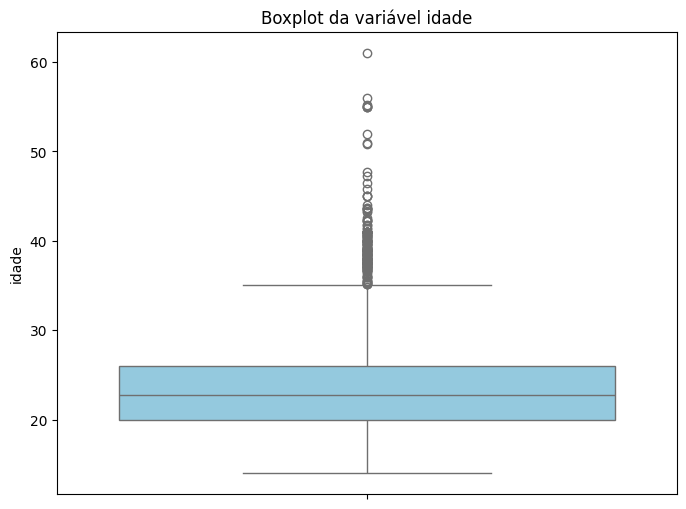

In [306]:
# Chamar a nova função para plotar o boxplot da variável 'idade'
plotar_boxplot_numerica(
    df,
    'idade',
    titulo= f"Boxplot da variável {dicionario_dados_nivel_obesidade['idade']['novo_nome']}",
    cor = 'skyblue'
    )

**Análise Bivariada**

`idade` vs `classificacao_peso_corporal`

**Boxplot agrupado**

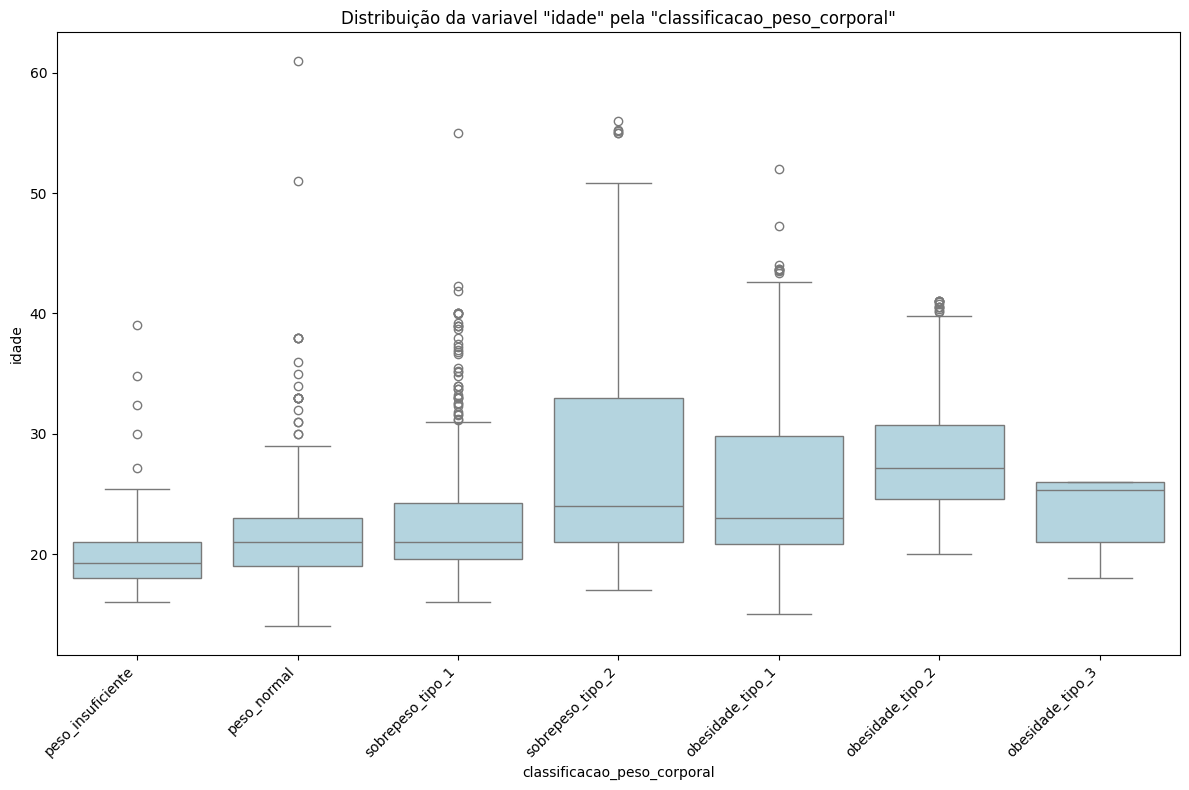

In [307]:
plotar_boxplot_agrupado_horizontal(
    df = df,
    variavel = 'idade',
    variavel_alvo = 'classificacao_peso_corporal',
    ordem=ordem_classificao_peso_corporal,
    cor='lightblue')

**Teste ANOVA**

In [308]:
teste_anova(df = df, agrupa_col = 'classificacao_peso_corporal', nome_col = 'idade')

--- Resultados do Teste ANOVA (idade vs classificacao_peso_corporal) ---
Estatística F: 77.9542
P-valor: 3.593e-88
Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma diferença ESTATISTICAMENTE SIGNIFICATIVA nas médias de 'idade' entre os grupos de 'classificacao_peso_corporal'.


(np.float64(77.95415423043558), np.float64(3.592579516699011e-88))

### **Análise variável `altura`**

In [309]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['altura']['novo_nome']}: {dicionario_dados_nivel_obesidade['altura']['descricao']}")

Descrição da variavel altura: Altura em metros


**Conclusão**

Na analise univariada percebemos que a variável altura é assimetrica , mas possui uma curva bimodal

Na análise Bivariada temos diferença nas medianas de altura entre o os grupos da variável alvo e o teste estatístico confirma a diferença estatisticamente relevante da distribuição da variavel idade.


**Sugestões**

- Incluir a variável `altura` no treinamento do modelo

- Com o intuito de padronizar as escalas entre as variáveis, indicamos executar Feature Scaling (como `StandardScaler` ou `MinMaxScaler`) na variável.

**Visualização prévia dos dados**

Esse dataset estava pronto quando recebemos para esse estudo. Analisando os dados da variável idade percebemos registros com 6 casas decimais, indicando que algum método estatístico foi utilzado na amostra. Seja para tratamento de dados ausentes ou  para uma geração de dados sintéticos.

Para o objetivo do estudo podemos continuar.

In [310]:
df.altura

,altura
0,1.620000
1,1.520000
2,1.800000
3,1.800000
4,1.780000
...,...
2106,1.710730
2107,1.748584
2108,1.752206
2109,1.739450


**Análise Univariada**

**Estatística descritiva**

**Análise:**

- Os valores mínimos e máximos da amostra estão dentro do esperado para uma amostra de altura.

- A média e mediana são quase idênticas indicando simetria dos dados

In [311]:
df['altura'].describe()

,altura
count,2111.000000
mean,1.701677
std,0.093305
min,1.450000
25%,1.630000
50%,1.700499
75%,1.768464
max,1.980000


**Histograma**

O histograma revela uma distribuição simétrica, confirmando a análise da estatística básica. No entanto, não possui uma curva de sino normal, mas sim bimodal.


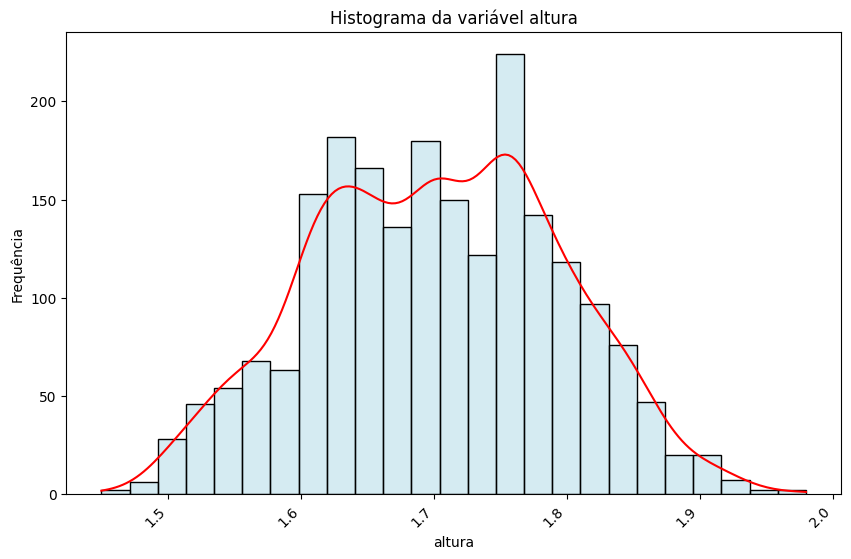

In [312]:
gera_histograma(df = df,  coluna = "altura", titulo = f"Histograma da variável {dicionario_dados_nivel_obesidade['altura']['novo_nome']}", cor="lightblue", cor_kde="red")

**Boxplot**

O boxplot confirma a simetria


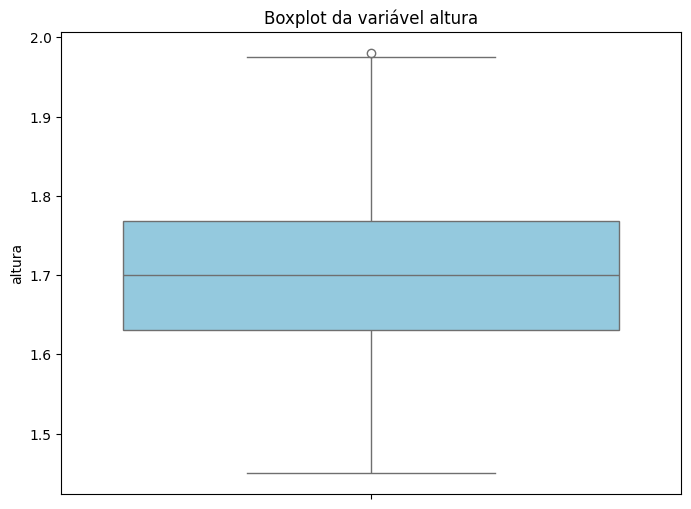

In [313]:
# Chamar a nova função para plotar o boxplot da variável 'idade'
plotar_boxplot_numerica(
    df,
    'altura',
    titulo= f"Boxplot da variável {dicionario_dados_nivel_obesidade['altura']['novo_nome']}",
    cor = 'skyblue'
    )

**Análise Bivariada**

`altura` vs `classificacao_peso_corporal`

**Boxplot agrupado**

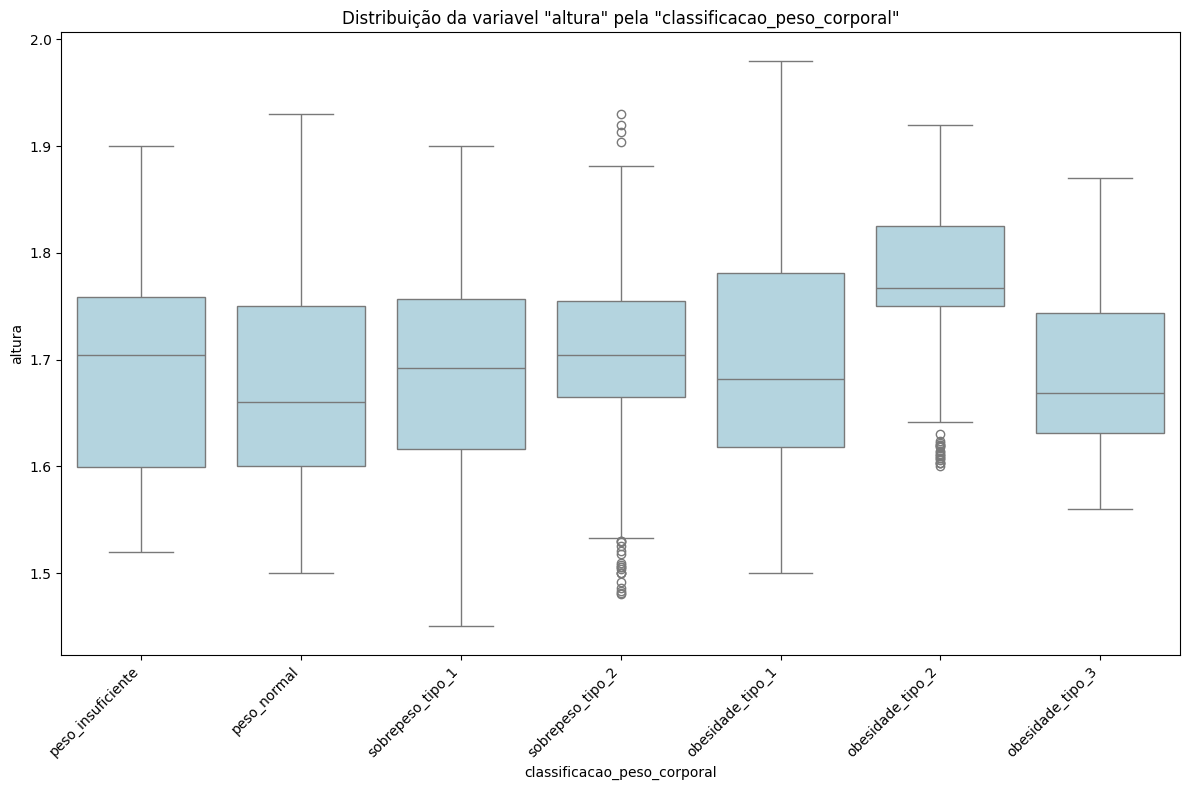

In [314]:
plotar_boxplot_agrupado_horizontal(
    df = df,
    variavel = 'altura',
    variavel_alvo = 'classificacao_peso_corporal',
    ordem=ordem_classificao_peso_corporal,
    cor='lightblue')

**Teste ANOVA**

In [315]:
teste_anova(df = df, agrupa_col = 'classificacao_peso_corporal', nome_col = 'altura')

--- Resultados do Teste ANOVA (altura vs classificacao_peso_corporal) ---
Estatística F: 38.4323
P-valor: 1.686e-44
Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma diferença ESTATISTICAMENTE SIGNIFICATIVA nas médias de 'altura' entre os grupos de 'classificacao_peso_corporal'.


(np.float64(38.43231255660025), np.float64(1.6858535844061656e-44))

### **Análise variável `peso`**

In [316]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['peso']['novo_nome']}: {dicionario_dados_nivel_obesidade['peso']['descricao']}")

Descrição da variavel peso: Peso em kgs.


**Conclusão**

A variável peso é limpa, multimodal e levemente assimétrica à direita.

Na análise Bivariada indica uma forte signifiância estatistica. Os valores de Estatística F = 1966.5180, P-valor = 0 indicama possível vazamento de dados da variável alvo.

Como se trata de um modelo para prever obesidade, comparar a variável alvo com a classificação de IMC que utiliza peso e altura no cálculo foi o caminho escolhido.

Realizamos teste de acerto = 95,2% que confirmou a hipóstese de vazamento e confirmamos com a criação de uma crosstab, mapa de calor e a execução de um teste de independência que confirmaram o vazamento.


**Sugestão**

- Excluir a variável `peso` do treinamento do modelo. A variável `altura` também deve ser excluida porque está associada aocálculo do IMC.


**Visualização prévia dos dados**

Esse dataset estava pronto quando recebemos para esse estudo. Analisando os dados da variável idade percebemos registros com 6 casas decimais, indicando que algum método estatístico foi utilzado na amostra. Seja para tratamento de dados ausentes ou  para uma geração de dados sintéticos.

Para o objetivo do estudo podemos continuar.

In [317]:
df.peso

,peso
0,64.000000
1,56.000000
2,77.000000
3,87.000000
4,89.800000
...,...
2106,131.408528
2107,133.742943
2108,133.689352
2109,133.346641


**Análise Univariada**

**Estatística descritiva**

**Análise:**

- Os valores mínimos e máximos da amostra estão dentro do esperado para uma amostra de altura.

- A média e mediana são quase idênticas indicando simetria dos dados

In [318]:
df['peso'].describe()

,peso
count,2111.000000
mean,86.586058
std,26.191172
min,39.000000
25%,65.473343
50%,83.000000
75%,107.430682
max,173.000000


**Histograma**

O histograma revela uma distribuição simétrica, confirmando a análise da estatística básica. No entanto, não possui uma curva de sino normal, mas sim bimodal.


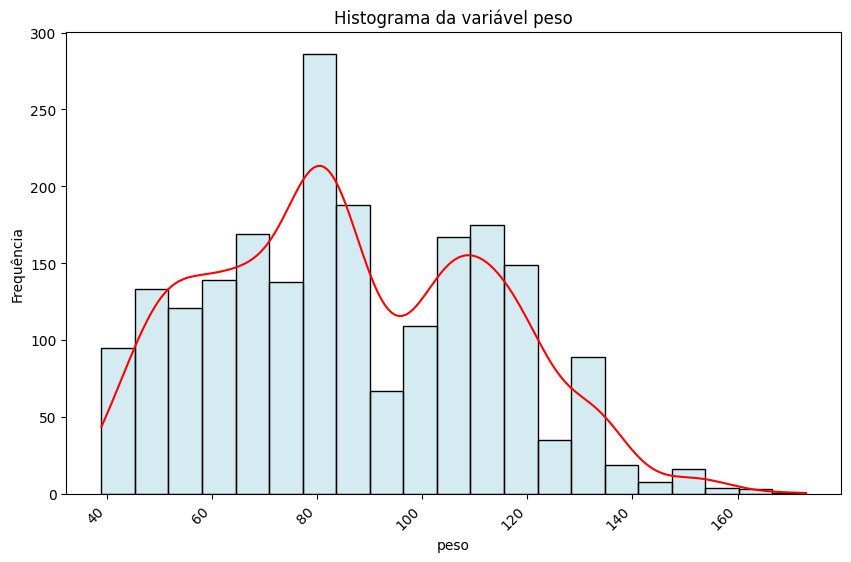

In [319]:
gera_histograma(df = df,  coluna = "peso", titulo = f"Histograma da variável {dicionario_dados_nivel_obesidade['peso']['novo_nome']}", cor="lightblue", cor_kde="red")

**Boxplot**

O boxplot confirma a simetria


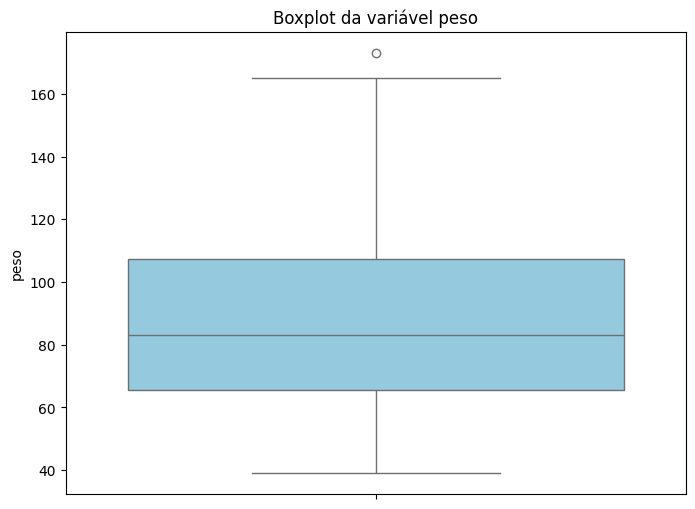

In [320]:
# Chamar a nova função para plotar o boxplot da variável 'idade'
plotar_boxplot_numerica(
    df,
    'peso',
    titulo= f"Boxplot da variável {dicionario_dados_nivel_obesidade['peso']['novo_nome']}",
    cor = 'skyblue'
    )

**Análise Bivariada**

`peso` vs `classificacao_peso_corporal`

**Boxplot agrupado**

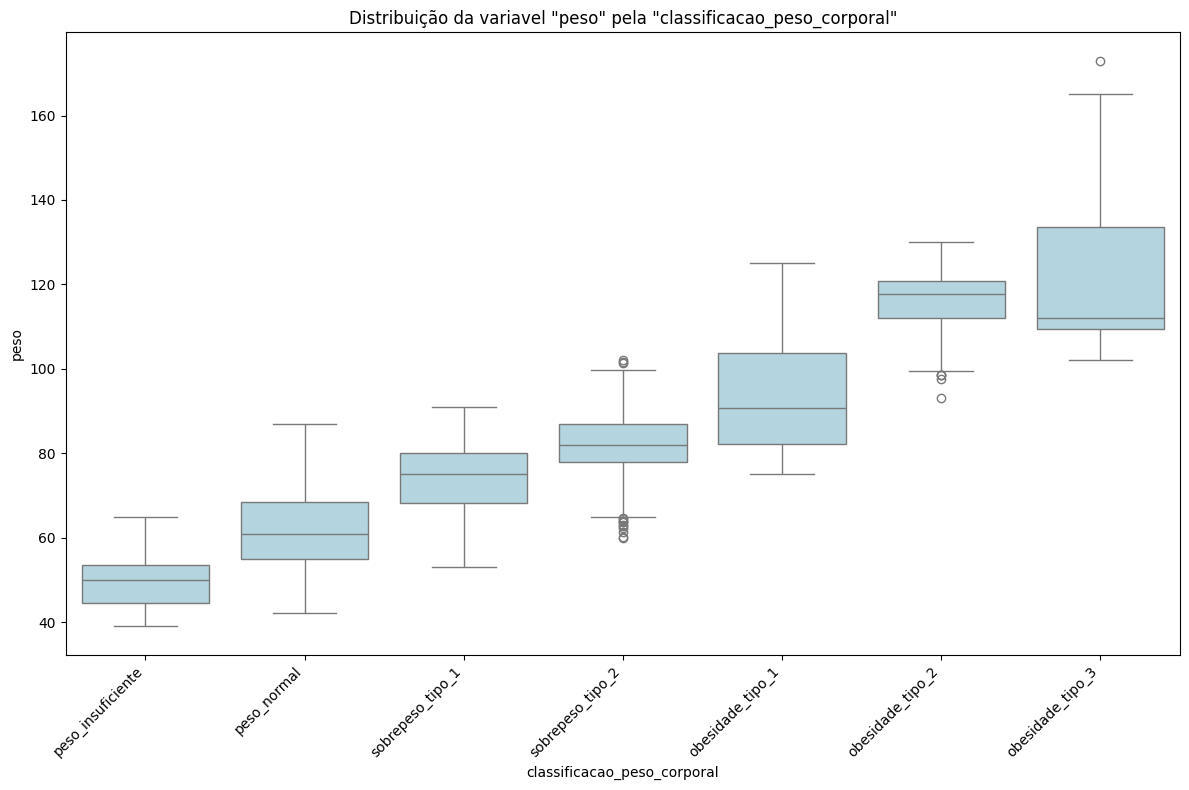

In [321]:
plotar_boxplot_agrupado_horizontal(
    df = df,
    variavel = 'peso',
    variavel_alvo = 'classificacao_peso_corporal',
    ordem=ordem_classificao_peso_corporal,
    cor='lightblue')

**Teste ANOVA**

In [322]:
teste_anova(df = df, agrupa_col = 'classificacao_peso_corporal', nome_col = 'peso')

--- Resultados do Teste ANOVA (peso vs classificacao_peso_corporal) ---
Estatística F: 1966.5180
P-valor: 0
Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma diferença ESTATISTICAMENTE SIGNIFICATIVA nas médias de 'peso' entre os grupos de 'classificacao_peso_corporal'.


(np.float64(1966.518017627475), np.float64(0.0))

**Verificando possível data Leakeage na variável peso**

**Variáveis criadas**

`imc` e `classificacao_imc`

**Teste de acerto**

**Nova variavel traduzindo os resultados da variável alvo `classificação peso` para corresponder a `classificacao imc` **

In [323]:

mapa_de_traducao = {
    'peso_insuficiente': 'abaixo_do_peso',
    'peso_normal': 'peso_normal',
    'sobrepeso_tipo_1': 'sobrepeso',       # Mapeia para 'sobrepeso'
    'sobrepeso_tipo_2': 'sobrepeso',       # Mapeia também para 'sobrepeso'
    'obesidade_tipo_1': 'obesidade_grau_1',
    'obesidade_tipo_2': 'obesidade_grau_2',
    'obesidade_tipo_3': 'obesidade_grau_3'
}


df['classificacao_peso_corporal_traduzido'] = df['classificacao_peso_corporal'].map(mapa_de_traducao)

# 3. AGORA sim, podemos comparar as duas colunas (ambas com os mesmos rótulos)
taxa_de_acerto_correta = (df['classificacao_peso_corporal_traduzido'] == df['classificacao_imc']).mean()

print(f"Taxa de correspondência correta: {taxa_de_acerto_correta * 100:.2f}%")

Taxa de correspondência correta: 95.22%


**Tabela de Contingência (Crosstab) `classificacao_peso_corporal` vs `classificacao_imc`**

In [324]:
tabela_comparacao = pd.crosstab(
    pd.Categorical(df['classificacao_peso_corporal'], categories=ordem_classificao_peso_corporal, ordered=True),
    df['classificacao_imc'],
    rownames=['classificacao_peso_corporal']
)
display(tabela_comparacao)

classificacao_imc,abaixo_do_peso,peso_normal,sobrepeso,obesidade_grau_1,obesidade_grau_2,obesidade_grau_3
classificacao_peso_corporal,,,,,,
peso_insuficiente,268,4,0,0,0,0
peso_normal,2,285,0,0,0,0
sobrepeso_tipo_1,0,12,278,0,0,0
sobrepeso_tipo_2,0,0,286,4,0,0
obesidade_tipo_1,0,0,2,346,3,0
obesidade_tipo_2,0,0,0,18,279,0
obesidade_tipo_3,0,0,0,0,56,268


**Mapa de Calor tabela_comparacao**

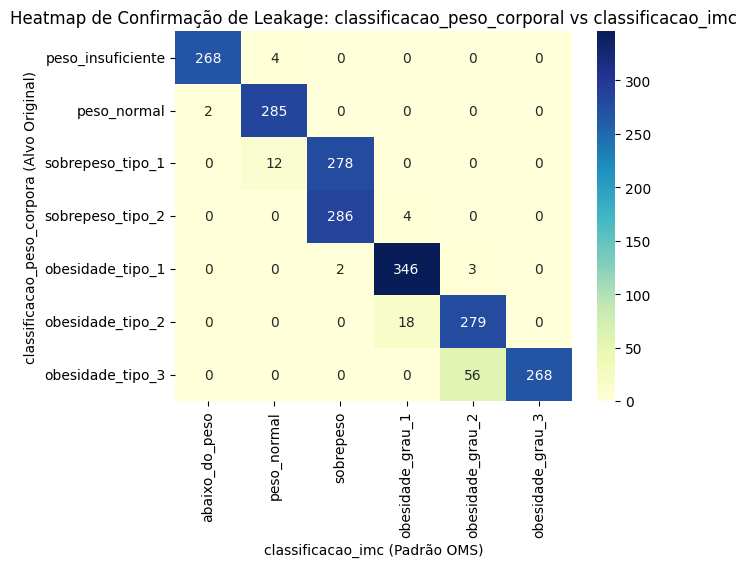

In [325]:
sns.heatmap(
    tabela_comparacao,
    annot=True,
    fmt='d',
    cmap="YlGnBu"
)

plt.title('Heatmap de Confirmação de Leakage: classificacao_peso_corporal vs classificacao_imc')
plt.xlabel('classificacao_imc (Padrão OMS)')
plt.ylabel('classificacao_peso_corpora (Alvo Original)')
plt.show()

In [326]:
# Assumindo que 'tabela_comparacao' é a sua crosstab
chi2, p_valor, _, _ = chi2_contingency(tabela_comparacao)

print(f"--- Teste Qui-Quadrado ---")
print(f"Estatística Chi2: {chi2:.2f}")
print(f"P-valor: {p_valor}")
print("CONCLUSÃO: As variáveis são EXTREMAMENTE dependentes.\n")


# --- Cálculo do V de Cramer ---
n = tabela_comparacao.sum().sum() # Número total de observações
min_dim = min(tabela_comparacao.shape) - 1

v_cramer = np.sqrt(chi2 / (n * min_dim))

print(f"--- Métrica de Força (V de Cramer) ---")
print(f"Força da Associação (0 a 1): {v_cramer:.4f}")
print("CONCLUSÃO: Um valor ~1.0 confirma uma associação quase perfeita (Leakage).")

--- Teste Qui-Quadrado ---
Estatística Chi2: 9395.13
P-valor: 0.0
CONCLUSÃO: As variáveis são EXTREMAMENTE dependentes.

--- Métrica de Força (V de Cramer) ---
Força da Associação (0 a 1): 0.9435
CONCLUSÃO: Um valor ~1.0 confirma uma associação quase perfeita (Leakage).


### **Análise variável `fcvc`**

In [327]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['fcvc']['novo_nome']}: {dicionario_dados_nivel_obesidade['fcvc']['descricao']}")

Descrição da variavel fcvc: Voce costuma comer vegetais nas suas refeicoes?


**Conclusão**

A variável `fcvc` devido a a sua pergunta (Voce costuma comer vegetais nas suas refeicoes?) indica ser uma variável ordinal. Baseado nos valores mínimos e máximos as categorias provavelmente correspondiam a 1, 2 e 3. Das 2111 linhas, 1285 correspondem a essas categorias e as outras corespondem a valores decimais das mesmas. Provalemente alguma técnica para preenchimento de valores nulos foi empregada.

O histograma revela uma distribuição assimétrica a esquerda. Ele não bate com a estatística basica muito provavelmente por temos dois picos relacionados aos valores 2 e 3. Percebemos tambem uma  barra em destaque no valor 1 reforçando a hispótese sugerida na análise inicial dos daos.

A analise bivariada confirma assimetria a esquerda e revela uma diferença estatisticamente significante em relação a variável alvo


**Sugestões**

- Realizar um processo de limpeza do ruído relacionado a  variável `fcvc` por meio de arredondamento dos dados.

- Após o arredondamento tratá-la como uma variável ordinal e usar a técnica de `ordinal encoding`. Mapeamento =  {1:1, 2:2, 3:3}

**Visualização prévia dos dados**

A variável `fcvc` devido a a sua pergunta (Voce costuma comer vegetais nas suas refeicoes?) indica ser uma variável ordinal. Baseado nos valores mínimos e máximos as categorias provavelmente correspondiam a 1, 2 e 3. Das 2111 linhas, 1285 correspondem a essas categorias e as outras corespondem a valores decimais das mesmas. Provalemente alguma técnica para preenchimento de valores nulos foi empregada.

Por isso vamos seguir com a análise dessa variável a considerando como númerica.

In [328]:
df.fcvc.unique()

array([2.      , 3.      , 1.      , 2.450218, 2.880161, 2.00876 ,
       2.596579, 2.591439, 2.392665, 1.123939, 2.027574, 2.658112,
       2.88626 , 2.714447, 2.750715, 1.4925  , 2.205439, 2.059138,
       2.310423, 2.823179, 2.052932, 2.596364, 2.767731, 2.815157,
       2.737762, 2.568063, 2.524428, 2.971574, 1.0816  , 1.270448,
       1.344854, 2.959658, 2.725282, 2.844607, 2.44004 , 2.432302,
       2.592247, 2.449267, 2.929889, 2.015258, 1.031149, 1.592183,
       1.21498 , 1.522001, 2.703436, 2.362918, 2.14084 , 2.5596  ,
       2.336044, 1.813234, 2.724285, 2.71897 , 1.133844, 1.757466,
       2.979383, 2.204914, 2.927218, 2.88853 , 2.890535, 2.530066,
       2.241606, 1.003566, 2.652779, 2.897899, 2.483979, 2.945967,
       2.478891, 2.784464, 1.005578, 2.938031, 2.842102, 1.889199,
       2.943749, 2.33998 , 1.950742, 2.277436, 2.371338, 2.984425,
       2.977018, 2.663421, 2.753752, 2.318355, 2.594653, 2.886157,
       2.967853, 2.619835, 1.053534, 2.530233, 2.8813  , 2.824

In [329]:
fcvc_amostra = len(df.fcvc)
fcvc_min = df.fcvc.min()
fcvc_max = df.fcvc.max()
fcvc_total_valores = len(df.fcvc.unique())
print(f'Valor mínimo na variável fcvc: {fcvc_min} ')
print(f'Valor máximo na variável fcvc: {fcvc_max} ')
print(f'Total de valores na variável fcvc: {fcvc_amostra} ')
print(f'Total de valores únicos na variável fcvc: {fcvc_total_valores} ')

Valor mínimo na variável fcvc: 1.0 
Valor máximo na variável fcvc: 3.0 
Total de valores na variável fcvc: 2111 
Total de valores únicos na variável fcvc: 810 


In [330]:
resposta_1 = len(df.query("fcvc == 1"))
resposta_2 = len(df.query("fcvc == 2"))
resposta_3 = len(df.query("fcvc == 3"))
total_inteiros = resposta_1 + resposta_2 + resposta_3
total_decimais = fcvc_amostra - total_inteiros


print(f'Quantidade de linhas na variável fcvc igual a 1: {resposta_1}')
print(f'Quantidade de linhas na variável fcvc igual a 2: {resposta_2}')
print(f'Quantidade de linhas na variável fcvc igual a 3: {resposta_3}')
print(f'Total de linhas com numeros inteiros: {total_inteiros}')
print(f'Total de linhas com numeros decimais: {total_decimais}')

Quantidade de linhas na variável fcvc igual a 1: 33
Quantidade de linhas na variável fcvc igual a 2: 600
Quantidade de linhas na variável fcvc igual a 3: 652
Total de linhas com numeros inteiros: 1285
Total de linhas com numeros decimais: 826


**Análise Univariada**

**Estatística descritiva**

**Análise:**

- Os valores mínimos e máximos da amostra estão dentro do esperado para uma amostra de altura.

- A média e mediana são quase idênticas indicando simetria dos dados

In [331]:
df['fcvc'].describe()

,fcvc
count,2111.000000
mean,2.419043
std,0.533927
min,1.000000
25%,2.000000
50%,2.385502
75%,3.000000
max,3.000000


**Histograma**

O histograma revela uma distribuição assimétrica a esquerda. Ele não bate com a estatística basica muito provavelmente por temos dois picos relacionados aos valores 2 e 3. Percebemos tambem uma  barra em destaque no valor 1 reforçando a hispótese sugerida na análise inicial dos daos.

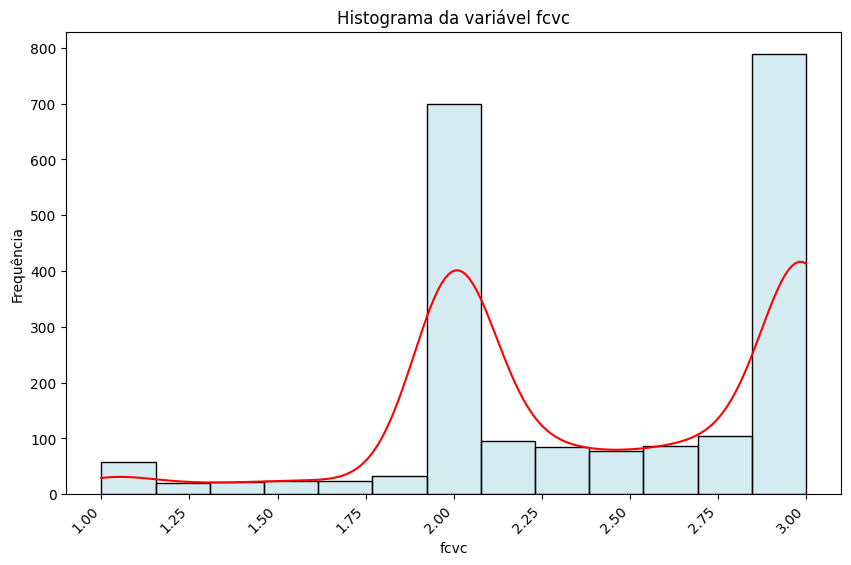

In [332]:
gera_histograma(
    df = df,
    coluna = "fcvc",
    titulo = f"Histograma da variável {dicionario_dados_nivel_obesidade['fcvc']['novo_nome']}",
    cor="lightblue",
    cor_kde="red"
    )

**Boxplot**

O boxplot confirma a simetria


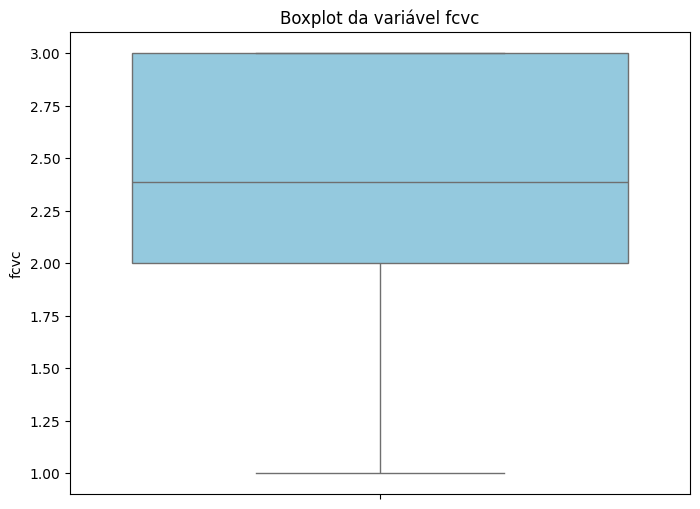

In [333]:
# Chamar a nova função para plotar o boxplot da variável 'idade'
plotar_boxplot_numerica(
    df,
    'fcvc',
    titulo= f"Boxplot da variável {dicionario_dados_nivel_obesidade['fcvc']['novo_nome']}",
    cor = 'skyblue'
    )

**Análise Bivariada**

`altura` vs `classificacao_peso_corporal`

**Boxplot agrupado**

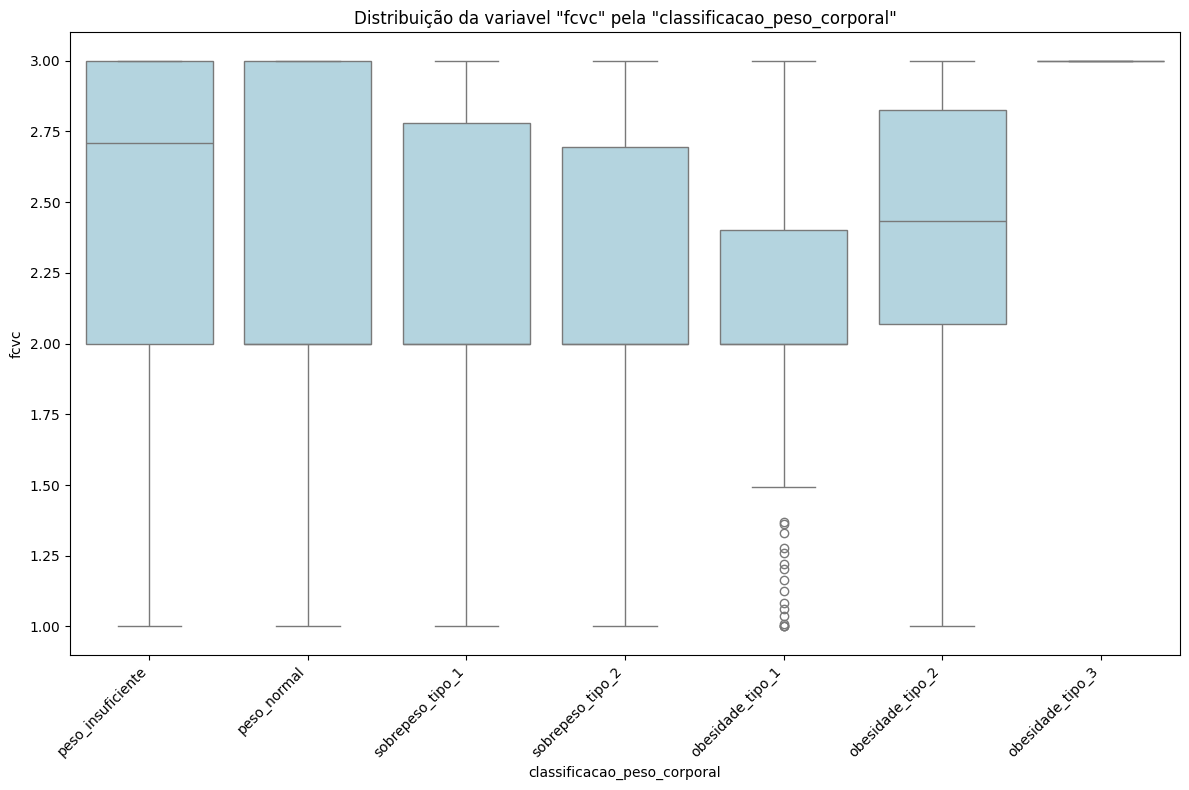

In [334]:
plotar_boxplot_agrupado_horizontal(
    df = df,
    variavel = 'fcvc',
    variavel_alvo = 'classificacao_peso_corporal',
    ordem=ordem_classificao_peso_corporal,
    cor='lightblue')

**Teste ANOVA**

In [335]:
teste_anova(df = df, agrupa_col = 'classificacao_peso_corporal', nome_col = 'fcvc')

--- Resultados do Teste ANOVA (fcvc vs classificacao_peso_corporal) ---
Estatística F: 112.3155
P-valor: 3.732e-123
Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma diferença ESTATISTICAMENTE SIGNIFICATIVA nas médias de 'fcvc' entre os grupos de 'classificacao_peso_corporal'.


(np.float64(112.31546186980427), np.float64(3.73246930865404e-123))

### **Análise variável `ncp`**

In [336]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['ncp']['novo_nome']}: {dicionario_dados_nivel_obesidade['ncp']['descricao']}")

Descrição da variavel ncp: Quantas refeicoes principais voce faz diariamente?


**Conclusão**

A variável `ncp`  demostra o mesmo padrao da variavel `fcvc` no que tanje a ser uma variavel originalmente categorica ordinal, mas que sofreu algum pre-processamento para inclusao de valores.
Estranho é nao ter nenhum valor inteiro == 2, visto que o valor minimo é igual a 1 e maximo igual a 4, o que sugeriria quatro categorias.

Outro ponto que pensando sobre o prisma de uma variável categórica, temos a categoria == 4 pode ser considerada rara com 69 registros. No entanto, possui uma quantidade sufiente para seguirmos com o treinamento e executar um teste A\B para pesar risco versus benefício.

A análise univariada mostra uma assimetria a esquerda, mas com uma grande concentração de valores no valor 3. Temos tambem notavelmente dois pequenos picos nos valor 1 e 4 confirmando a a analise inicial.

A analise bivariada informa que temos associação estatistica relevante entre as variaveis. Temos 2 categorias sem nenhuma associação o que a torna boa para identificar grupos específicos


**Sugestões**

- Realizar um processo de limpeza do ruído relacionado a  variável `ncp` por meio de arredondamento dos dados.

- Após o arredondamento tratá-la como uma variável ordinal e usar a técnica de `ordinal encoding`. Mapeamento =  {1:1, 3:3, 4:4}

- Monitorar risco devido a raridade da categoria 4. Usar as técnicas de importância de feature e Teste A/B pós treinamento.

**Visualização prévia dos dados**

In [337]:
df.ncp.unique()

array([3.      , 1.      , 4.      , 3.28926 , 3.995147, 1.72626 ,
       2.581015, 1.600812, 1.73762 , 1.10548 , 2.0846  , 1.894384,
       2.857787, 3.765526, 3.285167, 3.691226, 3.156153, 1.07976 ,
       3.559841, 3.891994, 3.240578, 3.904858, 3.11158 , 3.590039,
       2.057935, 3.558637, 2.000986, 3.821168, 3.897078, 3.092116,
       3.286431, 3.592415, 3.754599, 3.566082, 3.725797, 3.520555,
       3.731212, 1.259803, 1.273128, 3.304123, 3.647154, 3.300666,
       3.535016, 1.717608, 2.884479, 3.626815, 1.473088, 3.16645 ,
       3.494849, 2.99321 , 2.127797, 3.90779 , 3.699594, 3.179995,
       1.075553, 3.238258, 3.804944, 1.630846, 3.762778, 3.371832,
       2.705445, 3.34175 , 2.217651, 2.893778, 3.502604, 3.998766,
       3.193671, 1.69608 , 2.812377, 1.612747, 1.082304, 1.882158,
       2.326233, 1.989398, 1.735493, 2.974568, 3.715118, 3.489918,
       3.378859, 3.263201, 3.994588, 3.24934 , 3.087544, 1.163666,
       3.409363, 3.281391, 3.98525 , 3.207071, 3.471536, 3.488

In [338]:
ncp_amostra = len(df.ncp)
ncp_min = df.ncp.min()
ncp_max = df.ncp.max()
ncp_total_valores = len(df.ncp.unique())
print(f'Valor mínimo na variável ncp: {ncp_min} ')
print(f'Valor máximo na variável ncp: {ncp_max} ')
print(f'Total de valores na variável ncp: {ncp_amostra} ')
print(f'Total de valores únicos na variável ncp: {ncp_total_valores} ')

Valor mínimo na variável ncp: 1.0 
Valor máximo na variável ncp: 4.0 
Total de valores na variável ncp: 2111 
Total de valores únicos na variável ncp: 635 


In [339]:
resposta_ncp_1 = len(df.query("ncp == 1"))
resposta_ncp_2 = len(df.query("ncp == 2"))
resposta_ncp_3 = len(df.query("ncp == 3"))
resposta_ncp_4 = len(df.query("ncp == 4"))
total_inteiros_ncp = resposta_ncp_1 + resposta_ncp_2 + resposta_ncp_3 + resposta_ncp_4
total_decimais_ncp = ncp_amostra - total_inteiros_ncp


print(f'Quantidade de linhas na variável ncp igual a 1: {resposta_ncp_1}')
print(f'Quantidade de linhas na variável ncp igual a 2: {resposta_ncp_2}')
print(f'Quantidade de linhas na variável ncp igual a 3: {resposta_ncp_3}')
print(f'Quantidade de linhas na variável ncp igual a 4: {resposta_ncp_4}')
print(f'Total de linhas com numeros inteiros: {total_inteiros_ncp}')
print(f'Total de linhas com numeros decimais: {total_decimais_ncp}')

Quantidade de linhas na variável ncp igual a 1: 199
Quantidade de linhas na variável ncp igual a 2: 0
Quantidade de linhas na variável ncp igual a 3: 1203
Quantidade de linhas na variável ncp igual a 4: 69
Total de linhas com numeros inteiros: 1471
Total de linhas com numeros decimais: 640


**Análise Univariada**

**Estatística descritiva**

**Análise:**

- Os valores mínimos e máximos da amostra estão dentro do esperado para uma amostra de altura.

- A média e mediana são quase idênticas indicando simetria dos dados

In [340]:
df['ncp'].describe()

,ncp
count,2111.000000
mean,2.685628
std,0.778039
min,1.000000
25%,2.658738
50%,3.000000
75%,3.000000
max,4.000000


**Histograma**

O histograma revela uma distribuição assimétrica a esquerda. Ele não bate com a estatística basica muito provavelmente por temos dois picos relacionados aos valores 2 e 3. Percebemos tambem uma  barra em destaque no valor 1 reforçando a hispótese sugerida na análise inicial dos daos.

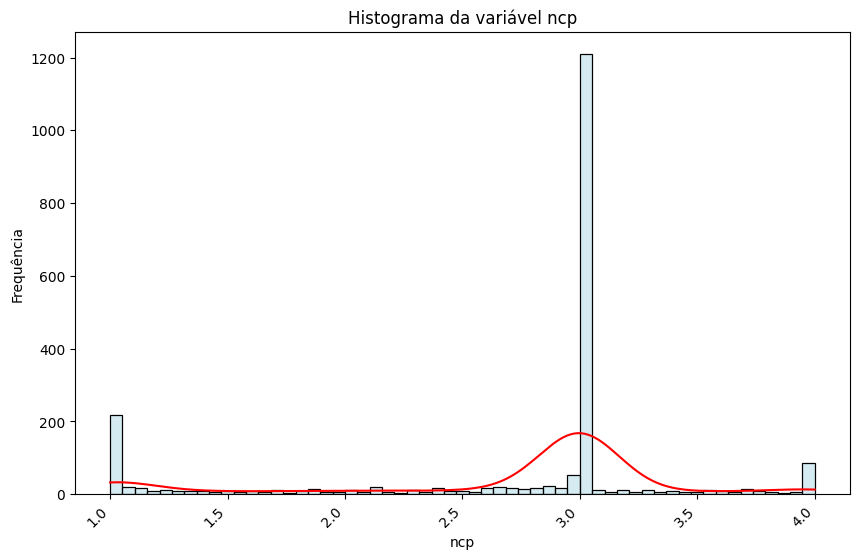

In [341]:
gera_histograma(
    df = df,
    coluna = "ncp",
    titulo = f"Histograma da variável {dicionario_dados_nivel_obesidade['ncp']['novo_nome']}",
    cor="lightblue",
    cor_kde="red"
    )

**Boxplot**

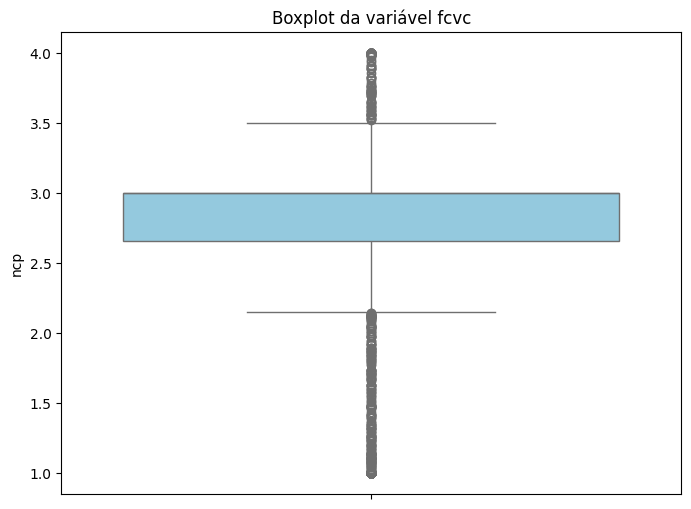

In [342]:
# Chamar a nova função para plotar o boxplot da variável 'idade'
plotar_boxplot_numerica(
    df,
    'ncp',
    titulo= f"Boxplot da variável {dicionario_dados_nivel_obesidade['fcvc']['novo_nome']}",
    cor = 'skyblue'
    )

**Análise Bivariada**

`ncp` vs `classificacao_peso_corporal`

**Boxplot agrupado**

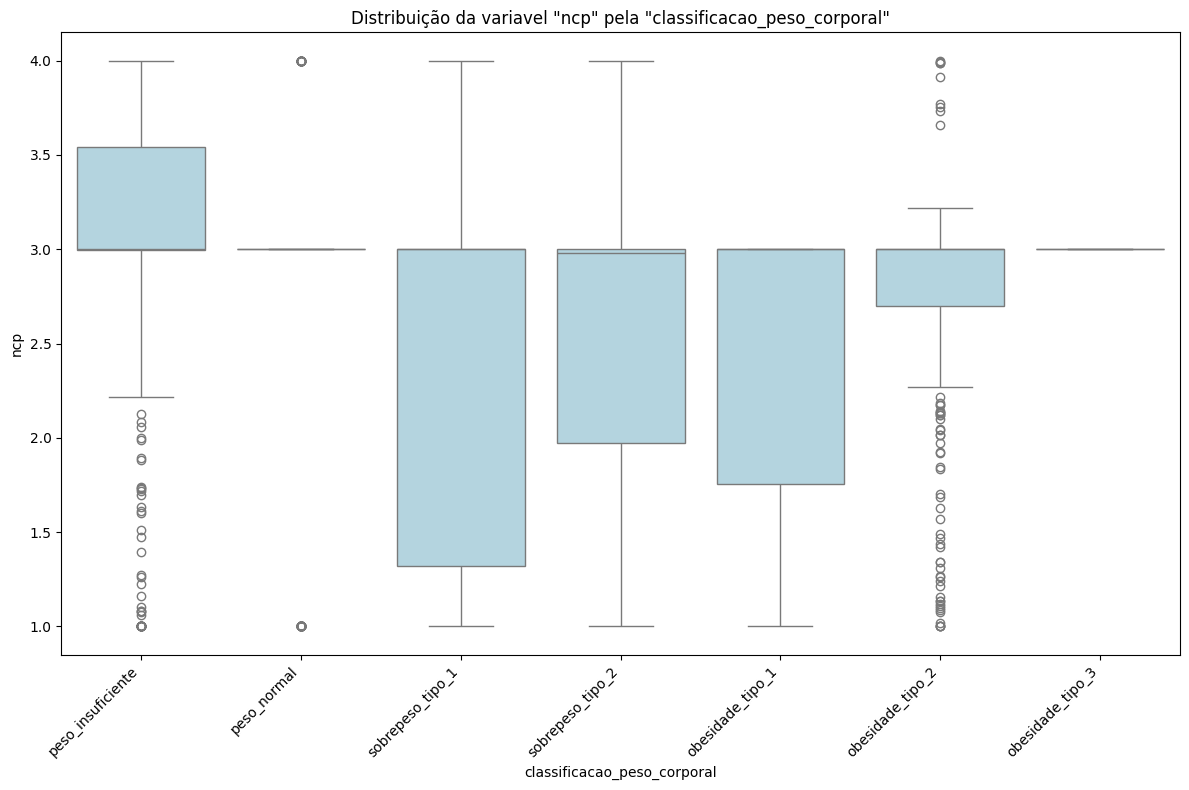

In [343]:
plotar_boxplot_agrupado_horizontal(
    df = df,
    variavel = 'ncp',
    variavel_alvo = 'classificacao_peso_corporal',
    ordem=ordem_classificao_peso_corporal,
    cor='lightblue')

**Teste ANOVA**

In [344]:
teste_anova(df = df, agrupa_col = 'classificacao_peso_corporal', nome_col = 'ncp')

--- Resultados do Teste ANOVA (ncp vs classificacao_peso_corporal) ---
Estatística F: 26.8117
P-valor: 6.259e-31
Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma diferença ESTATISTICAMENTE SIGNIFICATIVA nas médias de 'ncp' entre os grupos de 'classificacao_peso_corporal'.


(np.float64(26.81166184274833), np.float64(6.258631620911331e-31))

### **Análise variável `ch20`**

In [345]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['ch20']['novo_nome']}: {dicionario_dados_nivel_obesidade['ch20']['descricao']}")

Descrição da variavel ch20: Quanta agua voce bebe diariamente?


**Conclusão**

A variável `ch20` devido a a sua pergunta (Quanta agua voce bebe diariamente?) pode indicar tanto uma variável contínua se prensarmos em quantidade de água em litros, quando categórica se pensar em pouco, normal e muito. Na análise incial veriifcamos os valor minimo como 1 e maximo como 3 e o comportamento identificado em outras variáveis que sugere um preenchimento de dados nulos.

O histograma revela três picos relacionados aos valores inteiros com maior quantidade no valor 2 o que atesta o dado apresentado na estatística descritiva de média e mediana idênticas. Aqui temos uma distribuição simétrica que corrobora a hispótese inicial que se trata de uma variavel ordinal com 3 categorias.

A analise bivariada informa que temos associação estatistica relevante entre as variaveis.


**Sugestões**

- Realizar um processo de limpeza do ruído relacionado a  variável `ch20` por meio de arredondamento dos dados.

- Após o arredondamento tratá-la como uma variável ordinal e usar a técnica de `ordinal encoding`. Mapeamento =  {1:1, 2:2, 3:3}


**Visualização prévia dos dados**

A variável `ch20` devido a a sua pergunta (Quanta agua voce bebe diariamente?) pode indicar tanto uma variável contínua se prensarmos em quantidade de água em litros, quando categórica se pensar em pouco, normal e muito. Na análise incial veriifcamos os valor minimo como 1 e maximo como 3 e o comportamento identificado em outras variáveis que sugere um preenchimento de dados nulos.

Minha hipótese é que essa variável está mais para uma variavel categorica ordinal do que variável contínua.


In [346]:
df.ch20.unique()

array([2.      , 3.      , 1.      , ..., 2.054193, 2.852339, 2.863513])

In [347]:
ch20_amostra = len(df.ch20)
ch20_min = df.ch20.min()
ch20_max = df.ch20.max()
ch20_total_valores = len(df.ch20.unique())
print(f'Valor mínimo na variável ch20: {ch20_min} ')
print(f'Valor máximo na variável ch20: {ch20_max} ')
print(f'Total de valores na variável ch20: {ch20_amostra} ')
print(f'Total de valores únicos na variável ch20: {ch20_total_valores} ')

Valor mínimo na variável ch20: 1.0 
Valor máximo na variável ch20: 3.0 
Total de valores na variável ch20: 2111 
Total de valores únicos na variável ch20: 1268 


In [348]:
resposta_ch20_1 = len(df.query("ch20 == 1"))
resposta_ch20_2 = len(df.query("ch20 == 2"))
resposta_ch20_3 = len(df.query("ch20 == 3"))
total_inteiros_ch20 = resposta_ch20_1 + resposta_ch20_2 + resposta_ch20_3
total_decimais_ch20 = ch20_amostra - total_inteiros_ch20


print(f'Quantidade de linhas na variável ch20 igual a 1: {resposta_ch20_1}')
print(f'Quantidade de linhas na variável ch20 igual a 2: {resposta_ch20_2}')
print(f'Quantidade de linhas na variável ch20 igual a 3: {resposta_ch20_3}')
print(f'Total de linhas com numeros inteiros: {total_inteiros_ch20}')
print(f'Total de linhas com numeros decimais: {total_decimais_ch20}')

Quantidade de linhas na variável ch20 igual a 1: 211
Quantidade de linhas na variável ch20 igual a 2: 448
Quantidade de linhas na variável ch20 igual a 3: 162
Total de linhas com numeros inteiros: 821
Total de linhas com numeros decimais: 1290


**Análise Univariada**

**Estatística descritiva**

**Análise:**

- Os valores mínimos e máximos da amostra estão dentro do esperado para uma amostra de altura.

- A média e mediana são quase idênticas indicando simetria dos dados

In [349]:
df['ch20'].describe()

,ch20
count,2111.000000
mean,2.008011
std,0.612953
min,1.000000
25%,1.584812
50%,2.000000
75%,2.477420
max,3.000000


**Histograma**

O histograma revela três picos relacionados aos valores inteiros com maior quantidade no valor 2 o que atesta o dado apresentado na estatística descritiva de média e mediana idênticas. Aqui temos uma distribuição simétrica que corrobora a hispótese inicial que se trata de uma variavel ordinal com 3 categorias.

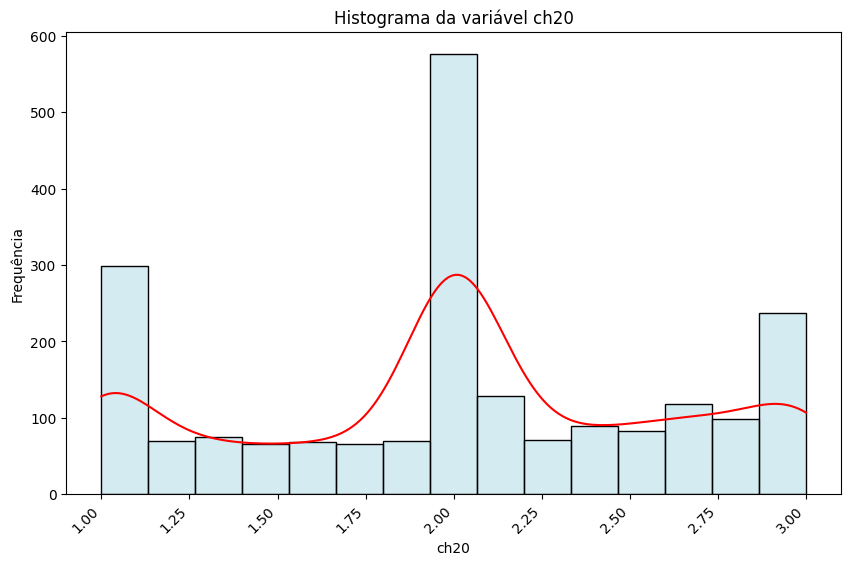

In [350]:
gera_histograma(
    df = df,
    coluna = "ch20",
    titulo = f"Histograma da variável {dicionario_dados_nivel_obesidade['ch20']['novo_nome']}",
    cor="lightblue",
    cor_kde="red"
    )

**Boxplot**

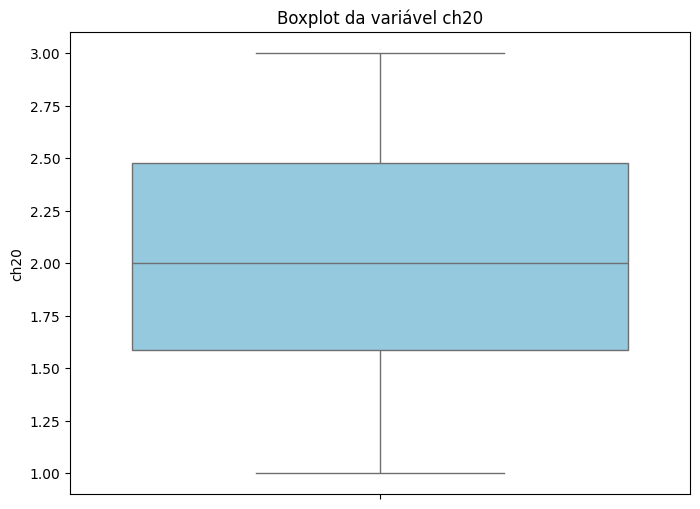

In [351]:
# Chamar a nova função para plotar o boxplot da variável 'idade'
plotar_boxplot_numerica(
    df,
    'ch20',
    titulo= f"Boxplot da variável {dicionario_dados_nivel_obesidade['ch20']['novo_nome']}",
    cor = 'skyblue'
    )

**Análise Bivariada**

`ch20` vs `classificacao_peso_corporal`

**Boxplot agrupado**

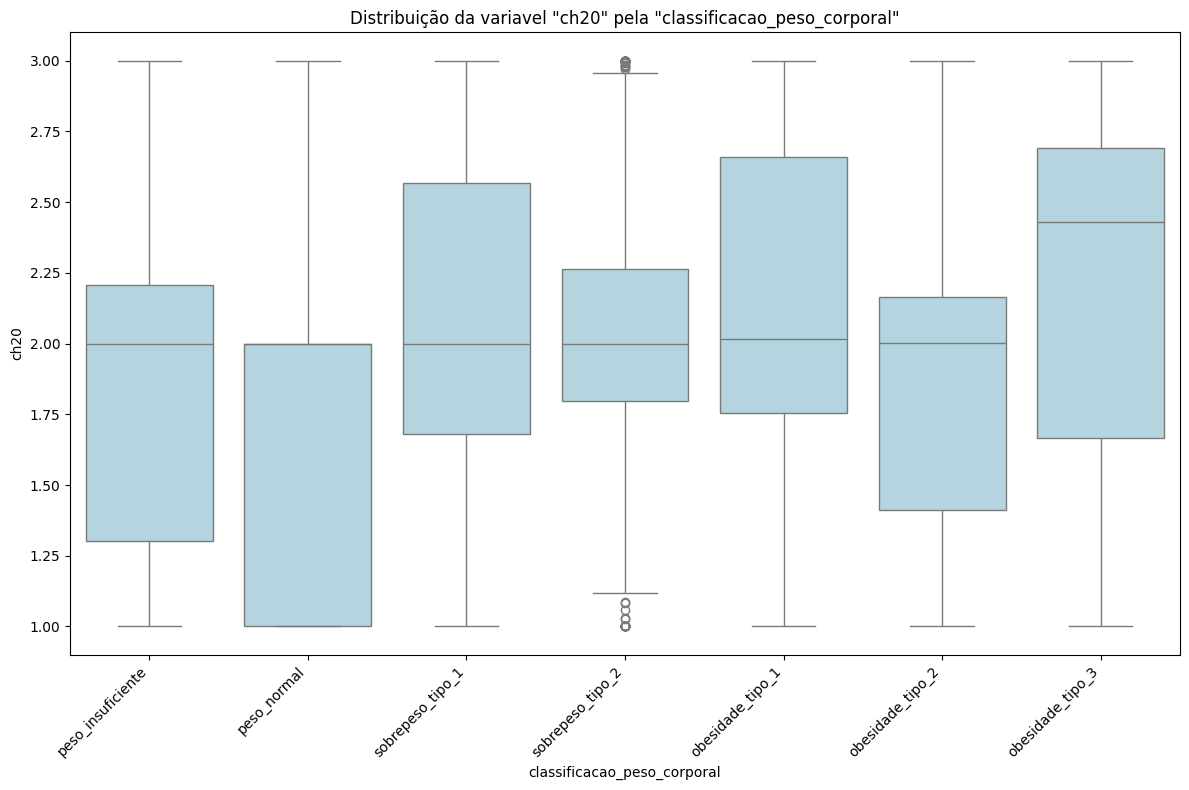

In [352]:
plotar_boxplot_agrupado_horizontal(
    df = df,
    variavel = 'ch20',
    variavel_alvo = 'classificacao_peso_corporal',
    ordem=ordem_classificao_peso_corporal,
    cor='lightblue')

**Teste ANOVA**

In [353]:
teste_anova(df = df, agrupa_col = 'classificacao_peso_corporal', nome_col = 'ch20')

--- Resultados do Teste ANOVA (ch20 vs classificacao_peso_corporal) ---
Estatística F: 16.1711
P-valor: 2.837e-18
Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma diferença ESTATISTICAMENTE SIGNIFICATIVA nas médias de 'ch20' entre os grupos de 'classificacao_peso_corporal'.


(np.float64(16.171142194378753), np.float64(2.8373240173998843e-18))

### **Análise variável `faf`**

In [354]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['faf']['novo_nome']}: {dicionario_dados_nivel_obesidade['faf']['descricao']}")

Descrição da variavel faf: Com que frequencia voce pratica atividade fisica?


**Conclusão**

A variável `faf` devido a a sua pergunta (Quanta agua voce bebe diariamente?) pode indicar tanto uma variável contínua se prensarmos em quantidade de água em litros, quando categórica ordinal com o padrão `['nunca', 'as_vezes', 'frequentemente', 'sempre']`.

Os valores minimos de 0 e maximo 4 corroboram as hipótese e também foi identificado o mesmo comportamento de outras variáveis que sugere um preenchimento de dados nulos.

Presumindo que se trata de uma variável categorica ordinal podemos considerar a categoria 3 como rara (75 registros)

O histograma revela 4 picos relacionados aos valores inteiros o que é mais um indício sobre a natureza da variável apresentada anteriormente. Aqui temos uma distribuição assimétrica a direita.

A análise bivariada informa uma associação estatística relevante entre a variável alvo e a variável `faf`. No entanto podemos perceber que essa relevância está fortemente associada a uma maior pratica de atividade física e insuficiência de peso e uma menor prática a obesidade 3



**Sugestões**

- Realizar um processo de limpeza do ruído relacionado a  variável `faf` por meio de arredondamento dos dados.

- Após o arredondamento tratá-la como uma variável ordinal e usar a técnica de `ordinal encoding`. Mapeamento =  {0:0, 1:1, 2:2, 3:3}

- Após o treinamento vericar a importância da feature e realizar o teste A/B para saber se vale o risco de manter essa variável no treinamento por conta da raridade da categoria 3.


**Visualização prévia dos dados**

A variável `faf` devido a a sua pergunta (Com que frequencia voce pratica atividade fisica?) indica ser uma variável categórica com o padrão . Na análise incial veriifcamos os valor minimo como 1 e maximo como 3 e o comportamento identificado em outras variáveis que sugere um preenchimento de dados nulos.

Minha hipótese é que essa variável está mais para uma variavel categorica ordinal do que variável contínua.


In [355]:
df.faf.unique()

array([0.      , 3.      , 2.      , ..., 1.414209, 1.139107, 1.026452])

In [356]:
faf_amostra = len(df.faf)
faf_min = df.faf.min()
faf_max = df.faf.max()
faf_total_valores = len(df.faf.unique())
print(f'Valor mínimo na variável faf: {faf_min} ')
print(f'Valor máximo na variável faf: {faf_max} ')
print(f'Total de valores na variável faf: {faf_amostra} ')
print(f'Total de valores únicos na variável faf: {faf_total_valores} ')

Valor mínimo na variável faf: 0.0 
Valor máximo na variável faf: 3.0 
Total de valores na variável faf: 2111 
Total de valores únicos na variável faf: 1190 


In [357]:
resposta_faf_0 = len(df.query("faf == 0"))
resposta_faf_1 = len(df.query("faf == 1"))
resposta_faf_2 = len(df.query("faf == 2"))
resposta_faf_3 = len(df.query("faf == 3"))
total_inteiros_faf = resposta_faf_0 + resposta_faf_1 + resposta_faf_2 + resposta_faf_3
total_decimais_faf = faf_amostra - total_inteiros_faf

print(f'Quantidade de linhas na variável faf igual a 0: {resposta_faf_0}')
print(f'Quantidade de linhas na variável faf igual a 1: {resposta_faf_1}')
print(f'Quantidade de linhas na variável faf igual a 2: {resposta_faf_2}')
print(f'Quantidade de linhas na variável faf igual a 3: {resposta_faf_3}')
print(f'Total de linhas com numeros inteiros: {total_inteiros_faf}')
print(f'Total de linhas com numeros decimais: {total_decimais_faf}')

Quantidade de linhas na variável faf igual a 0: 411
Quantidade de linhas na variável faf igual a 1: 234
Quantidade de linhas na variável faf igual a 2: 183
Quantidade de linhas na variável faf igual a 3: 75
Total de linhas com numeros inteiros: 903
Total de linhas com numeros decimais: 1208


**Análise Univariada**

**Estatística descritiva**

In [358]:
df['faf'].describe()

,faf
count,2111.000000
mean,1.010298
std,0.850592
min,0.000000
25%,0.124505
50%,1.000000
75%,1.666678
max,3.000000


**Histograma**

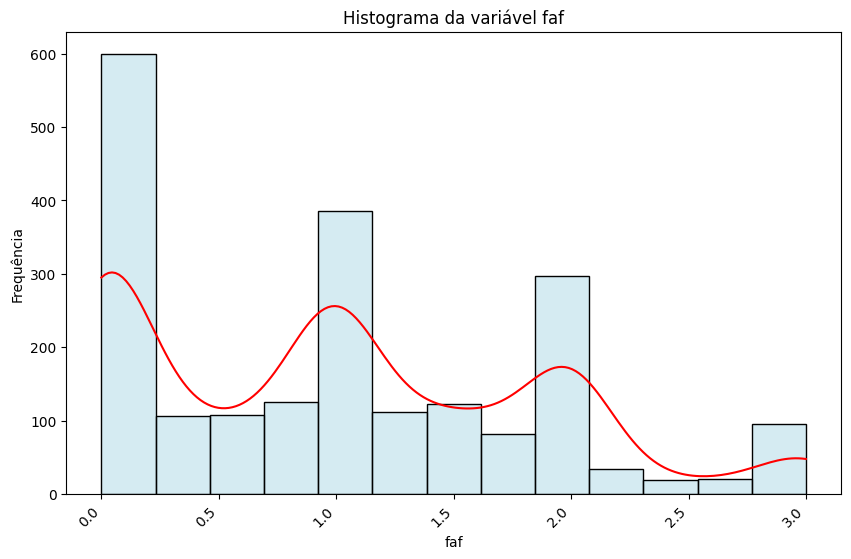

In [359]:
gera_histograma(
    df = df,
    coluna = "faf",
    titulo = f"Histograma da variável {dicionario_dados_nivel_obesidade['faf']['novo_nome']}",
    cor="lightblue",
    cor_kde="red"
    )

**Boxplot**

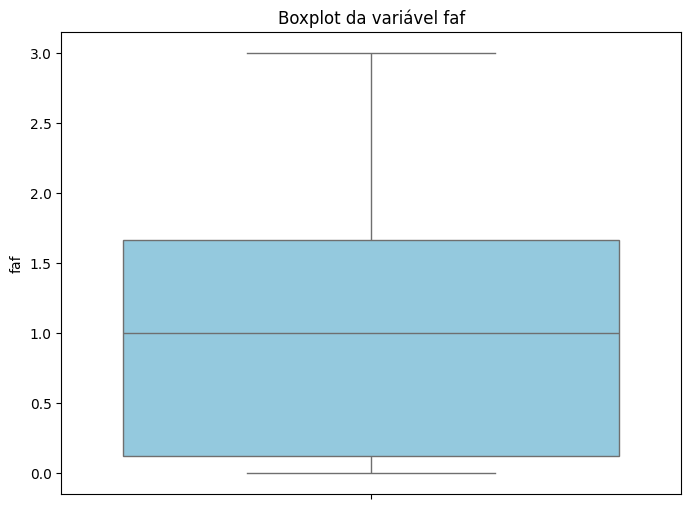

In [360]:
# Chamar a nova função para plotar o boxplot da variável 'idade'
plotar_boxplot_numerica(
    df,
    'faf',
    titulo= f"Boxplot da variável {dicionario_dados_nivel_obesidade['faf']['novo_nome']}",
    cor = 'skyblue'
    )

**Análise Bivariada**

`faf` vs `classificacao_peso_corporal`

**Boxplot agrupado**

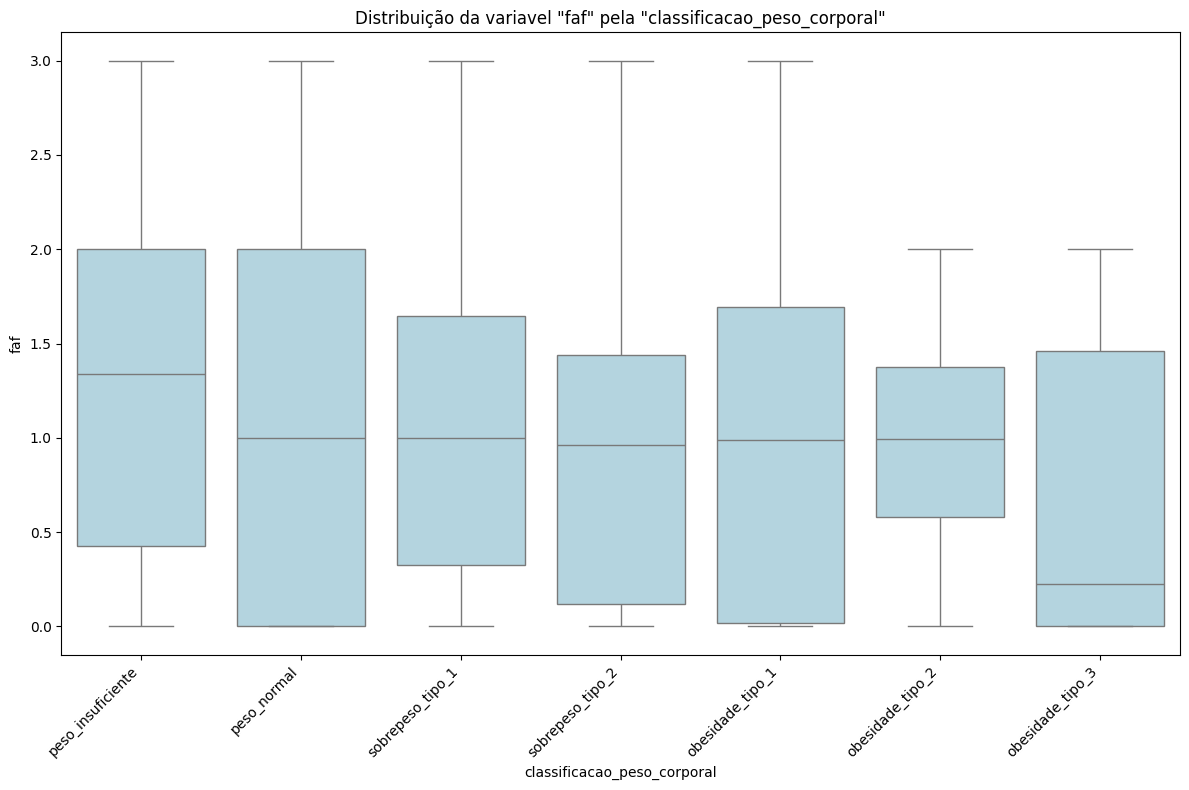

In [361]:
plotar_boxplot_agrupado_horizontal(
    df = df,
    variavel = 'faf',
    variavel_alvo = 'classificacao_peso_corporal',
    ordem=ordem_classificao_peso_corporal,
    cor='lightblue')

**Teste ANOVA**

In [362]:
teste_anova(df = df, agrupa_col = 'classificacao_peso_corporal', nome_col = 'faf')

--- Resultados do Teste ANOVA (faf vs classificacao_peso_corporal) ---
Estatística F: 17.4842
P-valor: 7.653e-20
Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma diferença ESTATISTICAMENTE SIGNIFICATIVA nas médias de 'faf' entre os grupos de 'classificacao_peso_corporal'.


(np.float64(17.484200429380497), np.float64(7.653252995698972e-20))

### **Análise variável `tue`**

In [363]:
print(f"Descrição da variavel {dicionario_dados_nivel_obesidade['tue']['novo_nome']}: {dicionario_dados_nivel_obesidade['tue']['descricao']}")

Descrição da variavel tue: Quanto tempo voce usa dispositivos tecnologicos como celular,


**Conclusão**

A variável `tue` devido a a sua pergunta (Quanto tempo voce usa dispositivos tecnologicos como celular?) pode indicar tanto uma variavel numérica continua que os valores representem o tempo de uso como uma variavel categórica que represente três categorias de uso visto que temos valor mínimo 0 e máximo 2, Foi observado um volume de resposta com o valores inteiros 0 (557), 1(292) e 2(109). A feature apresenta um comportamento parecida com o identificado em outras variáveis, sugerindo um preenchimento de dados nulos.


O histograma revela 3 picos relacionados aos valores inteiros o que é mais um indício sobre a natureza da variável apresentada anteriormente. Aqui temos uma distribuição assimétrica a direita.

A análise bivariada informa uma associação estatística relevante entre a variável alvo e a variável `tue`.

**Sugestões**

- Realizar um processo de limpeza do ruído relacionado a  variável `tue` por meio de arredondamento dos dados.

- Após o arredondamento tratá-la como uma variável ordinal e usar a técnica de `ordinal encoding`. Mapeamento =  {0:0, 1:1, 2:2}




**Visualização prévia dos dados**

A variável `tue` devido a a sua pergunta (Quanto tempo voce usa dispositivos tecnologicos como celular?) pode indicar tanto uma variavel numérica continua que os valores representem o tempo de uso como uma variavel categórica que represente três categorias de uso visto que temos valor mínimo 0 e máximo 2, Foi observado um volume de resposta com o valores inteiros 0 (557), 1(292) e 2(109). A feature apresenta um comportamento parecida com o identificado em outras variáveis, sugerindo um preenchimento de dados nulos.



In [364]:
df.tue.unique()

array([1.      , 0.      , 2.      , ..., 0.646288, 0.586035, 0.714137])

In [365]:
tue_amostra = len(df.tue)
tue_min = df.tue.min()
tue_max = df.tue.max()
tue_total_valores = len(df.tue.unique())
print(f'Valor mínimo na variável tue: {tue_min} ')
print(f'Valor máximo na variável tue: {tue_max} ')
print(f'Total de valores na variável faf: {tue_amostra} ')
print(f'Total de valores únicos na variável faf: {tue_total_valores} ')

Valor mínimo na variável tue: 0.0 
Valor máximo na variável tue: 2.0 
Total de valores na variável faf: 2111 
Total de valores únicos na variável faf: 1129 


In [366]:
resposta_tue_0 = len(df.query("tue == 0"))
resposta_tue_1 = len(df.query("tue == 1"))
resposta_tue_2 = len(df.query("tue == 2"))
total_inteiros_tue = resposta_tue_0 + resposta_tue_1 + resposta_tue_2
total_decimais_tue = tue_amostra - total_inteiros_tue

print(f'Quantidade de linhas na variável tue igual a 0: {resposta_tue_0}')
print(f'Quantidade de linhas na variável tue igual a 1: {resposta_tue_1}')
print(f'Quantidade de linhas na variável tue igual a 2: {resposta_tue_2}')
print(f'Total de linhas com numeros inteiros: {total_inteiros_tue}')
print(f'Total de linhas com numeros decimais: {total_decimais_tue}')

Quantidade de linhas na variável tue igual a 0: 557
Quantidade de linhas na variável tue igual a 1: 292
Quantidade de linhas na variável tue igual a 2: 109
Total de linhas com numeros inteiros: 958
Total de linhas com numeros decimais: 1153


**Análise Univariada**

**Estatística descritiva**

In [367]:
df['tue'].describe()

,tue
count,2111.000000
mean,0.657866
std,0.608927
min,0.000000
25%,0.000000
50%,0.625350
75%,1.000000
max,2.000000


**Histograma**

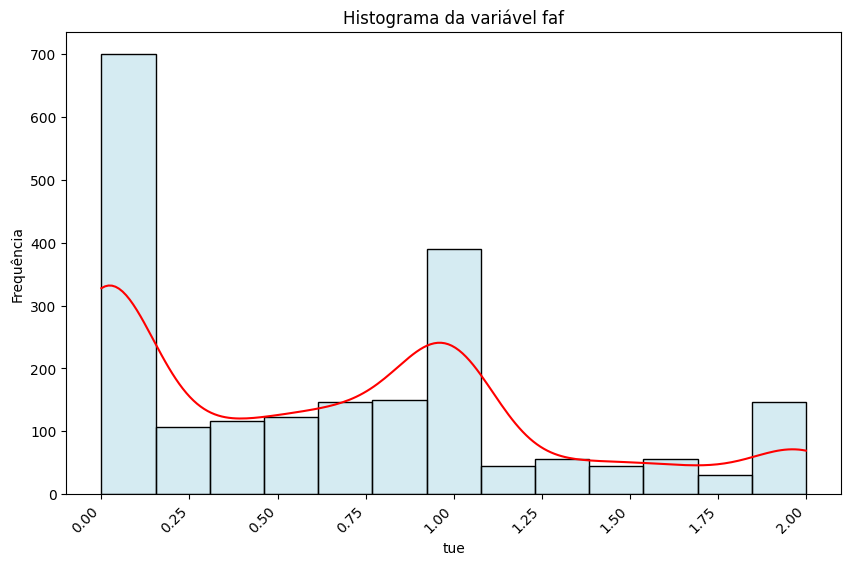

In [368]:
gera_histograma(
    df = df,
    coluna = "tue",
    titulo = f"Histograma da variável {dicionario_dados_nivel_obesidade['faf']['novo_nome']}",
    cor="lightblue",
    cor_kde="red"
    )

**Boxplot**

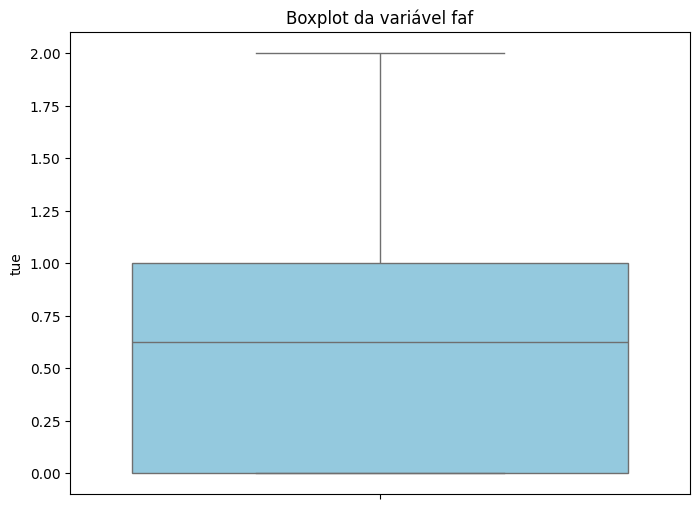

In [369]:
# Chamar a nova função para plotar o boxplot da variável 'idade'
plotar_boxplot_numerica(
    df,
    'tue',
    titulo= f"Boxplot da variável {dicionario_dados_nivel_obesidade['faf']['novo_nome']}",
    cor = 'skyblue'
    )

**Análise Bivariada**

`tue` vs `classificacao_peso_corporal`

**Boxplot agrupado**

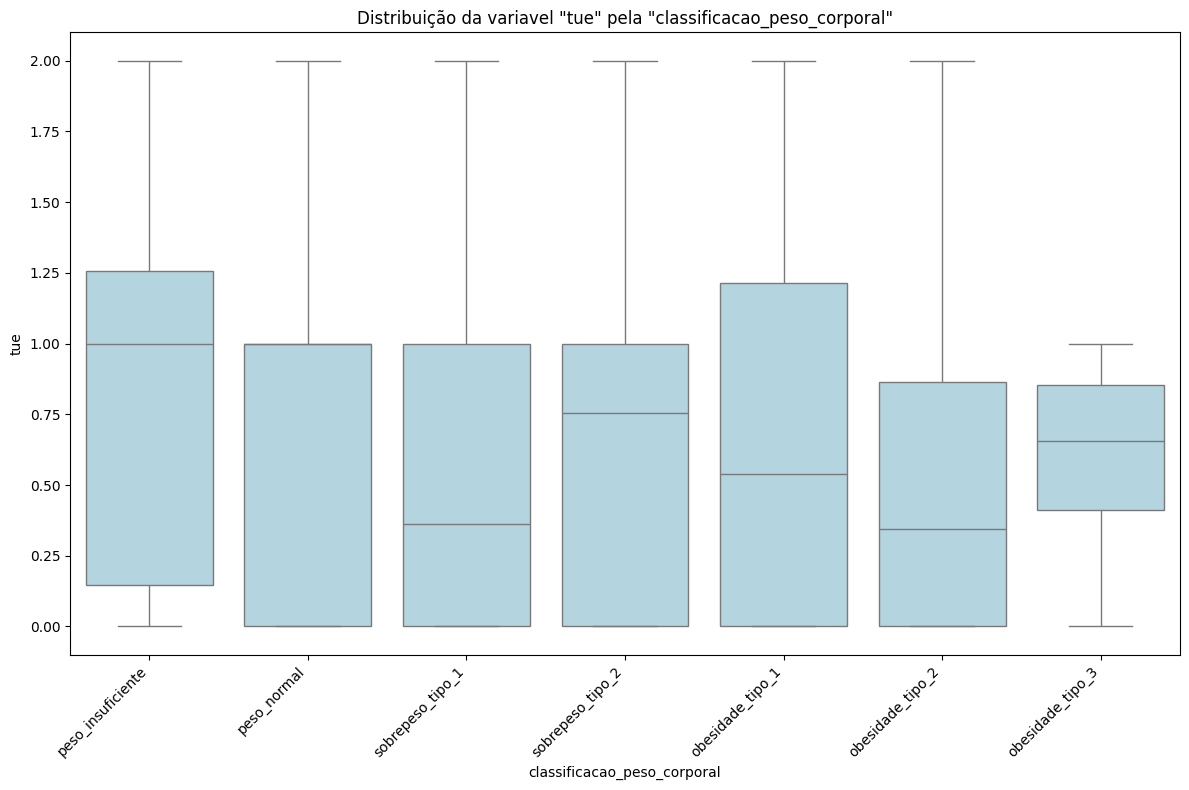

In [370]:
plotar_boxplot_agrupado_horizontal(
    df = df,
    variavel = 'tue',
    variavel_alvo = 'classificacao_peso_corporal',
    ordem=ordem_classificao_peso_corporal,
    cor='lightblue')

**Teste ANOVA**

In [371]:
teste_anova(df = df, agrupa_col = 'classificacao_peso_corporal', nome_col = 'tue')

--- Resultados do Teste ANOVA (tue vs classificacao_peso_corporal) ---
Estatística F: 7.8767
P-valor: 2.069e-08
Interpretação (p < 0.05): REJEITA H0.
CONCLUSÃO: Existe uma diferença ESTATISTICAMENTE SIGNIFICATIVA nas médias de 'tue' entre os grupos de 'classificacao_peso_corporal'.


(np.float64(7.876655737080659), np.float64(2.0687816228130554e-08))

# **Engenharia de Features**

## **Cópia do dataframe original**

In [372]:
df_processado = df.copy()

## **Limpeza de variáveis**

### **Arrendondamento de dados sintéticos e conversão de float para int.**

`fcvc`, `ncp`, `ch20`, `faf`, `tue`

In [373]:
# Rounding and converting to integer for specified columns
df_processado['fcvc_arredondada'] = df_processado['fcvc'].round(0).astype(int)
df_processado['ncp_arredondada'] = df_processado['ncp'].round(0).astype(int)
df_processado['ch20_arredondada'] = df_processado['ch20'].round(0).astype(int)
df_processado['faf_arredondada'] = df_processado['faf'].round(0).astype(int)
df_processado['tue_arredondada'] = df_processado['tue'].round(0).astype(int)

print("Colunas convertidas e arrendondas:")
display(df_processado[['fcvc_arredondada', 'ncp_arredondada', 'ch20_arredondada', 'faf_arredondada', 'tue_arredondada']].head())

Colunas convertidas e arrendondas:


,fcvc_arredondada,ncp_arredondada,ch20_arredondada,faf_arredondada,tue_arredondada
0,2,3,2,0,1
1,3,3,3,3,0
2,2,3,2,2,1
3,3,3,2,2,0
4,2,1,2,0,0


## **Agrupamento de categorias raras**



`mtrans`

  Ação: Agrupar o valores `moto`, `bicicleta` e `caminhando` em uma nova categorias chamada `outros`.

  Motivo: Devido à raridade e padrão bivariado similar

`calc`
  
  Ação: Agrupar os valores `frequente` e `sempre` em uma nova categoria `frequetemente_sempre`

  Motivo: Devido a raridade e próximidade por ordem de grandeza.

### **mtrans**

In [374]:
mapa_mtrans_agrupado = {
    'transporte_publico': 'transporte_publico',
    'carro': 'carro',
    'caminhando': 'outros',
    'moto': 'outros',
    'bicicleta': 'outros'
}

df_processado['mtrans_mod'] = df_processado['mtrans'].map(mapa_mtrans_agrupado)

print("Totais valores originais variável 'mtrans':")
display(df_processado['mtrans'].value_counts())

print("\nTotais valores modificados variável 'mtrans_mod':")
display(df_processado['mtrans_mod'].value_counts())


if dicionario_dados_nivel_obesidade is not None:
    atualizar_dicionario_novas_colunas(dicionario_dados_nivel_obesidade, df_processado)
    descricao_mtrans_mod = "Variável 'mtrans' com categorias raras (caminhando, moto, bicicleta) agrupadas em 'outros'."
    atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'mtrans_mod', 'descricao', descricao_mtrans_mod)
    transformacao_info = {
        'tipo': 'agrupamento_categorias',
        'mapa_aplicado': mapa_mtrans_agrupado
    }
    atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'mtrans_mod', 'transformacao', transformacao_info)

Totais valores originais variável 'mtrans':


,count
mtrans,
transporte_publico,1580
carro,457
caminhando,56
moto,11
bicicleta,7



Totais valores modificados variável 'mtrans_mod':


,count
mtrans_mod,
transporte_publico,1580
carro,457
outros,74


Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'classificacao_peso_corporal_traduzido' ao dicionário de dados.
Adicionada nova coluna 'fcvc_arredondada' ao dicionário de dados.
Adicionada nova coluna 'ncp_arredondada' ao dicionário de dados.
Adicionada nova coluna 'ch20_arredondada' ao dicionário de dados.
Adicionada nova coluna 'faf_arredondada' ao dicionário de dados.
Adicionada nova coluna 'tue_arredondada' ao dicionário de dados.
Adicionada nova coluna 'mtrans_mod' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'mtrans_mod' atualizado para: 'Variável 'mtrans' com categorias raras (caminhando, moto, bicicleta) agrupadas em 'outros'.'
Campo 'transformacao' da coluna 'mtrans_mod' atualizado com novos itens.


### **calc**

In [375]:
df_processado.calc.unique()

array(['nunca', 'as_vezes', 'frequentemente', 'sempre'], dtype=object)

In [376]:
mapa_calc_agrupado = {
    'nunca': 'nunca',
    'as_vezes': 'as_vezes',
    'frequentemente': 'freq_sempre',
    'sempre': 'freq_sempre'
  }

df_processado['calc_mod'] = df_processado['calc'].map(mapa_calc_agrupado)

print("Totais valores originais variável 'mtrans':")
display(df_processado['calc'].value_counts())

print("\nTotais valores modificados variável 'calc_mod':")
display(df_processado['calc_mod'].value_counts())


if dicionario_dados_nivel_obesidade is not None:
    atualizar_dicionario_novas_colunas(dicionario_dados_nivel_obesidade, df_processado)
    descricao_calc_mod = "Variável 'calc' com categorias raras (frequentemente, sempre) agrupadas em 'frenq_sempre'."
    atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'mtrans_mod', 'descricao', descricao_mtrans_mod)
    transformacao_info = {
        'tipo': 'agrupamento_categorias',
        'mapa_aplicado': mapa_calc_agrupado
    }
    atualizar_campo_dicionario(dicionario_dados_nivel_obesidade, 'calc_mod', 'transformacao', transformacao_info)

Totais valores originais variável 'mtrans':


,count
calc,
as_vezes,1401
nunca,639
frequentemente,70
sempre,1



Totais valores modificados variável 'calc_mod':


,count
calc_mod,
as_vezes,1401
nunca,639
freq_sempre,71


Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'calc_mod' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'mtrans_mod' atualizado para: 'Variável 'mtrans' com categorias raras (caminhando, moto, bicicleta) agrupadas em 'outros'.'
Campo 'transformacao' da coluna 'calc_mod' atualizado com novos itens.


## **Transformação de dados (Encoding)**

**Feature Alvo:** `classificacao_peso_corporal

  **Técnica:** Label Encoding (Mapear para 0/1).

**Features Nominais (Binárias):** `genero`, `historico_familiar`, `favc`, `scc`.

  **Técnica:** Label Encoding (Mapear para 0/1).

**Features Nominais (Multi-categoria):** `mtrans_mod`.

  **Técnica:** One-Hot Encoding (com drop_first=True para criar 2 colunas).

**Features Ordinais (Limpas):** `caec`, `calc_mod`, `fcvc_arredondada`, `ncp_arredondada`, `ch20_arredondada`, `faf_arredondada`, `tue_arredondada`.

  **Técnica:** Ordinal Encoding (Mapear para 0, 1, 2, 3...).

In [377]:
display(HTML(df_processado.head().to_html(index = False)))

genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,ch20,scc,faf,tue,calc,mtrans,classificacao_peso_corporal,imc,classificacao_imc,classificacao_peso_corporal_traduzido,fcvc_arredondada,ncp_arredondada,ch20_arredondada,faf_arredondada,tue_arredondada,mtrans_mod,calc_mod
Female,21.0,1.62,64.0,yes,no,2.0,3.0,as_vezes,no,2.0,no,0.0,1.0,nunca,transporte_publico,peso_normal,24.39,peso_normal,peso_normal,2,3,2,0,1,transporte_publico,nunca
Female,21.0,1.52,56.0,yes,no,3.0,3.0,as_vezes,yes,3.0,yes,3.0,0.0,as_vezes,transporte_publico,peso_normal,24.24,peso_normal,peso_normal,3,3,3,3,0,transporte_publico,as_vezes
Male,23.0,1.80,77.0,yes,no,2.0,3.0,as_vezes,no,2.0,no,2.0,1.0,frequentemente,transporte_publico,peso_normal,23.77,peso_normal,peso_normal,2,3,2,2,1,transporte_publico,freq_sempre
Male,27.0,1.80,87.0,no,no,3.0,3.0,as_vezes,no,2.0,no,2.0,0.0,frequentemente,caminhando,sobrepeso_tipo_1,26.85,sobrepeso,sobrepeso,3,3,2,2,0,outros,freq_sempre
Male,22.0,1.78,89.8,no,no,2.0,1.0,as_vezes,no,2.0,no,0.0,0.0,as_vezes,transporte_publico,sobrepeso_tipo_2,28.34,sobrepeso,sobrepeso,2,1,2,0,0,transporte_publico,as_vezes


### **Label Encoding**

In [378]:
colunas_codificacao_rotulo = ['classificacao_peso_corporal', 'genero', 'historico_familiar', 'favc', 'scc']
for coluna in colunas_codificacao_rotulo:
  df_processado = aplicar_label_encoding(df_processado, coluna, dicionario_dados_nivel_obesidade)

Coluna origina: 'classificacao_peso_corporal'


,classificacao_peso_corporal
0,peso_normal
1,peso_normal
2,peso_normal
3,sobrepeso_tipo_1
4,sobrepeso_tipo_2



Coluna codificada 'classificacao_peso_corporal_rcod'


,classificacao_peso_corporal_rcod
0,4
1,4
2,4
3,5
4,6


Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'classificacao_peso_corporal_rcod' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'classificacao_peso_corporal_rcod' atualizado para: 'Variável 'classificacao_peso_corporal' codificada numericamente via scikit-learn LabelEncoder.'
Campo 'transformacao' da coluna 'classificacao_peso_corporal_rcod' atualizado com novos itens.
Coluna origina: 'genero'


,genero
0,Female
1,Female
2,Male
3,Male
4,Male



Coluna codificada 'genero_rcod'


,genero_rcod
0,0
1,0
2,1
3,1
4,1


Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'genero_rcod' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'genero_rcod' atualizado para: 'Variável 'genero' codificada numericamente via scikit-learn LabelEncoder.'
Campo 'transformacao' da coluna 'genero_rcod' atualizado com novos itens.
Coluna origina: 'historico_familiar'


,historico_familiar
0,yes
1,yes
2,yes
3,no
4,no



Coluna codificada 'historico_familiar_rcod'


,historico_familiar_rcod
0,1
1,1
2,1
3,0
4,0


Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'historico_familiar_rcod' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'historico_familiar_rcod' atualizado para: 'Variável 'historico_familiar' codificada numericamente via scikit-learn LabelEncoder.'
Campo 'transformacao' da coluna 'historico_familiar_rcod' atualizado com novos itens.
Coluna origina: 'favc'


,favc
0,no
1,no
2,no
3,no
4,no



Coluna codificada 'favc_rcod'


,favc_rcod
0,0
1,0
2,0
3,0
4,0


Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'favc_rcod' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'favc_rcod' atualizado para: 'Variável 'favc' codificada numericamente via scikit-learn LabelEncoder.'
Campo 'transformacao' da coluna 'favc_rcod' atualizado com novos itens.
Coluna origina: 'scc'


,scc
0,no
1,yes
2,no
3,no
4,no



Coluna codificada 'scc_rcod'


,scc_rcod
0,0
1,1
2,0
3,0
4,0


Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'scc_rcod' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'descricao' da coluna 'scc_rcod' atualizado para: 'Variável 'scc' codificada numericamente via scikit-learn LabelEncoder.'
Campo 'transformacao' da coluna 'scc_rcod' atualizado com novos itens.


In [379]:
display(df_processado.head())

,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,...,ch20_arredondada,faf_arredondada,tue_arredondada,mtrans_mod,calc_mod,classificacao_peso_corporal_rcod,genero_rcod,historico_familiar_rcod,favc_rcod,scc_rcod
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,as_vezes,no,...,2,0,1,transporte_publico,nunca,4,0,1,0,0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,as_vezes,yes,...,3,3,0,transporte_publico,as_vezes,4,0,1,0,1
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,as_vezes,no,...,2,2,1,transporte_publico,freq_sempre,4,1,1,0,0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,as_vezes,no,...,2,2,0,outros,freq_sempre,5,1,0,0,0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,as_vezes,no,...,2,0,0,transporte_publico,as_vezes,6,1,0,0,0


### **one_hot encoding**

In [380]:
colunas = ['mtrans_mod']
df_processado = aplicar_one_hot_encoding(df_processado, colunas_para_ohe = colunas, dicionario = dicionario_dados_nivel_obesidade)


Aplicando One-Hot Encoding nas colunas: ['mtrans_mod']
One-Hot Encoding aplicado na coluna 'mtrans_mod'.
Campo 'transformacao' da coluna 'mtrans_mod' atualizado com novos itens.
Iniciando a atualização do dicionário de dados para colunas OHE da variável 'mtrans_mod'...
Iniciando a atualização do dicionário de dados com novas colunas...
Adicionada nova coluna 'mtrans_mod_outros' ao dicionário de dados.
Adicionada nova coluna 'mtrans_mod_transporte_publico' ao dicionário de dados.
Dicionário de dados atualizado com novas colunas.
Campo 'transformacao' da coluna 'mtrans_mod_outros' atualizado com novos itens.
Campo 'transformacao' da coluna 'mtrans_mod_transporte_publico' atualizado com novos itens.
Dicionário de dados atualizado para colunas OHE da variável 'mtrans_mod'.

DataFrame após One-Hot Encoding (primeiras 5 linhas):


,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,...,faf_arredondada,tue_arredondada,calc_mod,classificacao_peso_corporal_rcod,genero_rcod,historico_familiar_rcod,favc_rcod,scc_rcod,mtrans_mod_outros,mtrans_mod_transporte_publico
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,as_vezes,no,...,0,1,nunca,4,0,1,0,0,0,1
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,as_vezes,yes,...,3,0,as_vezes,4,0,1,0,1,0,1
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,as_vezes,no,...,2,1,freq_sempre,4,1,1,0,0,0,1
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,as_vezes,no,...,2,0,freq_sempre,5,1,0,0,0,1,0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,as_vezes,no,...,0,0,as_vezes,6,1,0,0,0,0,1



Colunas do DataFrame após One-Hot Encoding:
Index(['genero', 'idade', 'altura', 'peso', 'historico_familiar', 'favc',
       'fcvc', 'ncp', 'caec', 'fumante', 'ch20', 'scc', 'faf', 'tue', 'calc',
       'mtrans', 'classificacao_peso_corporal', 'imc', 'classificacao_imc',
       'classificacao_peso_corporal_traduzido', 'fcvc_arredondada',
       'ncp_arredondada', 'ch20_arredondada', 'faf_arredondada',
       'tue_arredondada', 'calc_mod', 'classificacao_peso_corporal_rcod',
       'genero_rcod', 'historico_familiar_rcod', 'favc_rcod', 'scc_rcod',
       'mtrans_mod_outros', 'mtrans_mod_transporte_publico'],
      dtype='object')


### **OrdinalEnconder**

**`caec`**

In [381]:
ordem_caec = [
    'nunca',
    'as_vezes',
    'frequentemente',
    'sempre',
]
df_processado = aplicar_ordinal_encoding(
    df=df_processado,
    coluna='caec',
    ordem_categorias=ordem_caec,
    dicionario=dicionario_dados_nivel_obesidade)

Aplicando Ordinal Encoding na coluna 'caec' com a ordem: ['nunca', 'as_vezes', 'frequentemente', 'sempre']
Coluna 'caec' codificada com sucesso na nova coluna 'caec_ocod'.

Contagem de valores na coluna 'caec_ocod':


,count
caec_ocod,
0.0,51
1.0,1765
2.0,242
3.0,53


Iniciando a atualização do dicionário de dados para a coluna 'caec_ocod' (Ordinal Encoding)...
Adicionada nova entrada para a coluna 'caec_ocod' ao dicionário.
Campo 'transformacao' da coluna 'caec_ocod' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'caec_ocod'.


**calc_mod**

In [382]:
ordem_calc_mod = [
    'nunca',
    'as_vezes',
    'freq_sempre'
]
df_processado = aplicar_ordinal_encoding(
    df=df_processado,
    coluna='calc_mod',
    ordem_categorias=ordem_calc_mod,
    dicionario=dicionario_dados_nivel_obesidade)

Aplicando Ordinal Encoding na coluna 'calc_mod' com a ordem: ['nunca', 'as_vezes', 'freq_sempre']
Coluna 'calc_mod' codificada com sucesso na nova coluna 'calc_mod_ocod'.

Contagem de valores na coluna 'calc_mod_ocod':


,count
calc_mod_ocod,
0.0,639
1.0,1401
2.0,71


Iniciando a atualização do dicionário de dados para a coluna 'calc_mod_ocod' (Ordinal Encoding)...
Adicionada nova entrada para a coluna 'calc_mod_ocod' ao dicionário.
Campo 'transformacao' da coluna 'calc_mod_ocod' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'calc_mod_ocod'.


**fcvc_arredondada**

In [383]:
ordem_fcvc_arredondada = [
    1,
    2,
    3
]
df_processado = aplicar_ordinal_encoding(
    df=df_processado,
    coluna='fcvc_arredondada',
    ordem_categorias=ordem_fcvc_arredondada,
    dicionario=dicionario_dados_nivel_obesidade)

Aplicando Ordinal Encoding na coluna 'fcvc_arredondada' com a ordem: [1, 2, 3]
Coluna 'fcvc_arredondada' codificada com sucesso na nova coluna 'fcvc_arredondada_ocod'.

Contagem de valores na coluna 'fcvc_arredondada_ocod':


,count
fcvc_arredondada_ocod,
0.0,102
1.0,1013
2.0,996


Iniciando a atualização do dicionário de dados para a coluna 'fcvc_arredondada_ocod' (Ordinal Encoding)...
Adicionada nova entrada para a coluna 'fcvc_arredondada_ocod' ao dicionário.
Campo 'transformacao' da coluna 'fcvc_arredondada_ocod' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'fcvc_arredondada_ocod'.


**ncp**

In [384]:
ordem_ncp_arredondada = [
    1,
    2,
    3,
    4
]
df_processado = aplicar_ordinal_encoding(
    df=df_processado,
    coluna='ncp_arredondada',
    ordem_categorias=ordem_ncp_arredondada,
    dicionario=dicionario_dados_nivel_obesidade)

Aplicando Ordinal Encoding na coluna 'ncp_arredondada' com a ordem: [1, 2, 3, 4]
Coluna 'ncp_arredondada' codificada com sucesso na nova coluna 'ncp_arredondada_ocod'.

Contagem de valores na coluna 'ncp_arredondada_ocod':


,count
ncp_arredondada_ocod,
0.0,316
1.0,176
2.0,1470
3.0,149


Iniciando a atualização do dicionário de dados para a coluna 'ncp_arredondada_ocod' (Ordinal Encoding)...
Adicionada nova entrada para a coluna 'ncp_arredondada_ocod' ao dicionário.
Campo 'transformacao' da coluna 'ncp_arredondada_ocod' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'ncp_arredondada_ocod'.


**ch20**

In [385]:
ordem_ch20_arredondada = [
    1,
    2,
    3
]
df_processado = aplicar_ordinal_encoding(
    df=df_processado,
    coluna='ch20_arredondada',
    ordem_categorias=ordem_ch20_arredondada,
    dicionario=dicionario_dados_nivel_obesidade)

Aplicando Ordinal Encoding na coluna 'ch20_arredondada' com a ordem: [1, 2, 3]
Coluna 'ch20_arredondada' codificada com sucesso na nova coluna 'ch20_arredondada_ocod'.

Contagem de valores na coluna 'ch20_arredondada_ocod':


,count
ch20_arredondada_ocod,
0.0,485
1.0,1110
2.0,516


Iniciando a atualização do dicionário de dados para a coluna 'ch20_arredondada_ocod' (Ordinal Encoding)...
Adicionada nova entrada para a coluna 'ch20_arredondada_ocod' ao dicionário.
Campo 'transformacao' da coluna 'ch20_arredondada_ocod' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'ch20_arredondada_ocod'.


**faf**

In [386]:
ordem_faf_arredondada = [
    0,
    1,
    2,
    3
]
df_processado = aplicar_ordinal_encoding(
    df=df_processado,
    coluna='faf_arredondada',
    ordem_categorias=ordem_faf_arredondada,
    dicionario=dicionario_dados_nivel_obesidade)

Aplicando Ordinal Encoding na coluna 'faf_arredondada' com a ordem: [0, 1, 2, 3]
Coluna 'faf_arredondada' codificada com sucesso na nova coluna 'faf_arredondada_ocod'.

Contagem de valores na coluna 'faf_arredondada_ocod':


,count
faf_arredondada_ocod,
0.0,720
1.0,776
2.0,496
3.0,119


Iniciando a atualização do dicionário de dados para a coluna 'faf_arredondada_ocod' (Ordinal Encoding)...
Adicionada nova entrada para a coluna 'faf_arredondada_ocod' ao dicionário.
Campo 'transformacao' da coluna 'faf_arredondada_ocod' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'faf_arredondada_ocod'.


**tue**

In [387]:
ordem_tue_arredondada = [
    0,
    1,
    2
]
df_processado = aplicar_ordinal_encoding(
    df=df_processado,
    coluna='tue_arredondada',
    ordem_categorias=ordem_tue_arredondada,
    dicionario=dicionario_dados_nivel_obesidade)

Aplicando Ordinal Encoding na coluna 'tue_arredondada' com a ordem: [0, 1, 2]
Coluna 'tue_arredondada' codificada com sucesso na nova coluna 'tue_arredondada_ocod'.

Contagem de valores na coluna 'tue_arredondada_ocod':


,count
tue_arredondada_ocod,
0.0,952
1.0,915
2.0,244


Iniciando a atualização do dicionário de dados para a coluna 'tue_arredondada_ocod' (Ordinal Encoding)...
Adicionada nova entrada para a coluna 'tue_arredondada_ocod' ao dicionário.
Campo 'transformacao' da coluna 'tue_arredondada_ocod' atualizado com novos itens.
Dicionário de dados atualizado para a coluna 'tue_arredondada_ocod'.


### **StandardScaler**



Aplica de scaling na variável `idade`

Técnica: StandartScaler

In [388]:
colunas_para_padronizar = ['idade']
df_processado = padronizar_colunas_standardscaler(df_processado, colunas_para_padronizar = colunas_para_padronizar , dicionario = dicionario_dados_nivel_obesidade, nome_novo_df= 'df_processado')

Criada uma cópia do DataFrame original com o nome 'df_processado'.
DataFrame após padronização (primeiras 5 linhas das colunas padronizadas):


,idade
0,-0.522124
1,-0.522124
2,-0.206889
3,0.423582
4,-0.364507



Estatísticas Descritivas das Colunas Padronizadas:


,idade
count,2111.000000
mean,0.000000
std,1.000237
min,-1.625448
25%,-0.688066
50%,-0.241897
75%,0.265964
max,5.782584



Atualizando dicionário de dados com informações de padronização...
Campo 'transformacao' da coluna 'idade' atualizado com novos itens.
Atualização do dicionário de dados concluída.


In [389]:
display(df_processado.head(5))

,genero,idade,altura,peso,historico_familiar,favc,fcvc,ncp,caec,fumante,...,scc_rcod,mtrans_mod_outros,mtrans_mod_transporte_publico,caec_ocod,calc_mod_ocod,fcvc_arredondada_ocod,ncp_arredondada_ocod,ch20_arredondada_ocod,faf_arredondada_ocod,tue_arredondada_ocod
0,Female,-0.522124,1.62,64.0,yes,no,2.0,3.0,as_vezes,no,...,0,0,1,1.0,0.0,1.0,2.0,1.0,0.0,1.0
1,Female,-0.522124,1.52,56.0,yes,no,3.0,3.0,as_vezes,yes,...,1,0,1,1.0,1.0,2.0,2.0,2.0,3.0,0.0
2,Male,-0.206889,1.80,77.0,yes,no,2.0,3.0,as_vezes,no,...,0,0,1,1.0,2.0,1.0,2.0,1.0,2.0,1.0
3,Male,0.423582,1.80,87.0,no,no,3.0,3.0,as_vezes,no,...,0,1,0,1.0,2.0,2.0,2.0,1.0,2.0,0.0
4,Male,-0.364507,1.78,89.8,no,no,2.0,1.0,as_vezes,no,...,0,0,1,1.0,1.0,1.0,0.0,1.0,0.0,0.0


## **Remoção de Features**

**Motivos e Colunas**

**Vazamento de dados (Data Leakage)**

  `peso`, `altura`

**Risco devido a raridade de amostra**

  `fumante`

**Colunas criadas para análise**

`imc`, `classificacao_imc`, `classificacao_peso_corporal_traduzido`

**Colunas que sofreram processo de arredondamento**

`fcvc`, `ncp`, `ch20`, `faf`, `tue`

**Colunas com valores que foram agrupados**

`mtrans`, `calc`

**Colunas que alteradas com Label encoding**

`classificacao_peso_corporal`, `genero`, `historico_familiar`, `favc`, `scc`

**colunas que foram alteradas por ordinal_encoder**

`fcvc_arredondada`, `ncp_arredondada`, `ch20_arredondada`, `faf_arredondada`, `tue_arredondada`

In [390]:
colunas_para_remover = [
    'peso',
    'altura',
    'fumante',
    'imc',
    'classificacao_imc',
    'classificacao_peso_corporal_traduzido',
    'fcvc',
    'ncp',
    'ch20',
    'faf',
    'tue',
    'mtrans',
    'calc',
    'classificacao_peso_corporal',
    'genero',
    'historico_familiar',
    'favc',
    'scc',
    'caec',
    'calc_mod',
    'fcvc_arredondada',
    'ncp_arredondada',
    'ch20_arredondada',
    'faf_arredondada',
    'tue_arredondada'
    ]
df_processado = df_processado.drop(columns=colunas_para_remover)
print("Colunas removidas do df_processado:", colunas_para_remover)
display(df_processado.head())
print(f'Total de linhas: {df_processado.shape[0]}\nTotal de colunas: {df_processado.shape[1]} ')

Colunas removidas do df_processado: ['peso', 'altura', 'fumante', 'imc', 'classificacao_imc', 'classificacao_peso_corporal_traduzido', 'fcvc', 'ncp', 'ch20', 'faf', 'tue', 'mtrans', 'calc', 'classificacao_peso_corporal', 'genero', 'historico_familiar', 'favc', 'scc', 'caec', 'calc_mod', 'fcvc_arredondada', 'ncp_arredondada', 'ch20_arredondada', 'faf_arredondada', 'tue_arredondada']


,idade,classificacao_peso_corporal_rcod,genero_rcod,historico_familiar_rcod,favc_rcod,scc_rcod,mtrans_mod_outros,mtrans_mod_transporte_publico,caec_ocod,calc_mod_ocod,fcvc_arredondada_ocod,ncp_arredondada_ocod,ch20_arredondada_ocod,faf_arredondada_ocod,tue_arredondada_ocod
0,-0.522124,4,0,1,0,0,0,1,1.0,0.0,1.0,2.0,1.0,0.0,1.0
1,-0.522124,4,0,1,0,1,0,1,1.0,1.0,2.0,2.0,2.0,3.0,0.0
2,-0.206889,4,1,1,0,0,0,1,1.0,2.0,1.0,2.0,1.0,2.0,1.0
3,0.423582,5,1,0,0,0,1,0,1.0,2.0,2.0,2.0,1.0,2.0,0.0
4,-0.364507,6,1,0,0,0,0,1,1.0,1.0,1.0,0.0,1.0,0.0,0.0


Total de linhas: 2111
Total de colunas: 15 


# **Geracao de arquivos transformados**

## **Arquivo CSV após transformção**

In [391]:
criar_csv_de_dataframe(df_processado, 'obesidade_processado.csv')

DataFrame salvo com sucesso em 'obesidade_processado.csv'


## **Arquivo de dicionário de dados**

In [392]:
criar_json_de_dicionario(dicionario_dados_nivel_obesidade, 'dicionario_dados_tech_challenge_4.json')

Dicionário salvo com sucesso em 'dicionario_dados_tech_challenge_4.json'
